In [ ]:
!nvidia-smi


Fri May 19 08:55:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Data Download and Prepare**

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1lDpsLB-erPd4rvvRguui6i06h1hTKE1K
!gdown 1HctYMsZ-V7t7ipdLOO05S-WNWH5X_l4b
!gdown 1nZ-JnAIQ5fku0FhIFUHCFKguCtEyuNNB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1lDpsLB-erPd4rvvRguui6i06h1hTKE1K
To: /content/QA_data.csv
100% 28.4k/28.4k [00:00<00:00, 66.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HctYMsZ-V7t7ipdLOO05S-WNWH5X_l4b
To: /content/test.csv
100% 20.8k/20.8k [00:00<00:00, 60.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nZ-JnAIQ5fku0FhIFUHCFKguCtEyuNNB
To: /content/train.csv
100% 307k/307k [00:00<00:00, 127MB/s]


In [ ]:
# Load pre-trained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-05-24 09:18:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-24 09:18:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-24 09:18:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Method1

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [ ]:
# Clean the text by removing special characters and converting to lowercase
train_data['cleaned_text'] = train_data['text'].str.replace('[^\w\s\?]', '').str.lower()
test_data['cleaned_text'] = test_data['text'].str.replace('[^\w\s\?]', '').str.lower()

# Tokenize the text
train_data['tokenized_text'] = train_data['cleaned_text'].apply(word_tokenize)
test_data['tokenized_text'] = test_data['cleaned_text'].apply(word_tokenize)

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
train_data['filtered_text'] = train_data['tokenized_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
test_data['filtered_text'] = test_data['tokenized_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Get the filtered text and labels
X_train = train_data['filtered_text'].values
y_train = train_data['label-fine'].values
X_test = test_data['filtered_text'].values
y_test = test_data['label-fine'].values

# Tokenize the text and convert to sequences
tokenizer = Tokenizer(num_words=400000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to have the same length
max_sequence_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Convert labels to categorical
num_classes = train_data['label-fine'].nunique()
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]


In [ ]:
# Replace 'glove_path' with the path to your GloVe embeddings file
glove_path = '/content/glove.6B.300d.txt'
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(400000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


## Method2

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Read 'QA_data.csv' with 'errors' parameter and pass the file object to 'pd.read_csv()'
with open('QA_data.csv', 'r', encoding='utf-8', errors='replace') as file:
    qa_data = pd.read_csv(file)

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Tokenize the text
train_data['tokens'] = train_data['text'].apply(word_tokenize)
test_data['tokens'] = test_data['text'].apply(word_tokenize)
qa_data['tokens'] = qa_data['text'].apply(word_tokenize)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tokens'])

# Convert tokens to sequences
train_data['sequences'] = tokenizer.texts_to_sequences(train_data['tokens'])
test_data['sequences'] = tokenizer.texts_to_sequences(test_data['tokens'])
qa_data['sequences'] = tokenizer.texts_to_sequences(qa_data['tokens'])

# Pad sequences
maxlen = max(train_data['sequences'].apply(len))
train_padded_sequences = pad_sequences(train_data['sequences'], maxlen=maxlen)
test_padded_sequences = pad_sequences(test_data['sequences'], maxlen=maxlen)
qa_padded_sequences = pad_sequences(qa_data['sequences'], maxlen=maxlen)

# Encode labels
encoder = LabelEncoder()
encoder.fit(train_data['label-coarse'])
train_data['encoded_labels'] = encoder.transform(train_data['label-coarse'])
test_data['encoded_labels'] = encoder.transform(test_data['label-coarse'])
qa_data['encoded_labels'] = encoder.transform(qa_data['label-coarse'])

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# **3. Models, Training, and Evaluation**

## **3.1 (Model 1)**

### Method 1

Training model with h_dim = 25
Epoch 1/50
86/86 - 10s - loss: 1.3743 - accuracy: 0.4699 - 10s/epoch - 119ms/step
Epoch 2/50
86/86 - 4s - loss: 0.7887 - accuracy: 0.7324 - 4s/epoch - 42ms/step
Epoch 3/50
86/86 - 4s - loss: 0.6017 - accuracy: 0.7979 - 4s/epoch - 42ms/step
Epoch 4/50
86/86 - 5s - loss: 0.5335 - accuracy: 0.8259 - 5s/epoch - 57ms/step
Epoch 5/50
86/86 - 4s - loss: 0.4387 - accuracy: 0.8601 - 4s/epoch - 42ms/step
Epoch 6/50
86/86 - 4s - loss: 0.3987 - accuracy: 0.8762 - 4s/epoch - 42ms/step
Epoch 7/50
86/86 - 5s - loss: 0.3705 - accuracy: 0.8830 - 5s/epoch - 58ms/step
Epoch 8/50
86/86 - 4s - loss: 0.3219 - accuracy: 0.9000 - 4s/epoch - 42ms/step
Epoch 9/50
86/86 - 4s - loss: 0.3018 - accuracy: 0.9099 - 4s/epoch - 43ms/step
Epoch 10/50
86/86 - 5s - loss: 0.2830 - accuracy: 0.9156 - 5s/epoch - 57ms/step
Epoch 11/50
86/86 - 4s - loss: 0.2531 - accuracy: 0.9242 - 4s/epoch - 51ms/step
Epoch 12/50
86/86 - 4s - loss: 0.2292 - accuracy: 0.9351 - 4s/epoch - 43ms/step
Epoch 13/50
86/

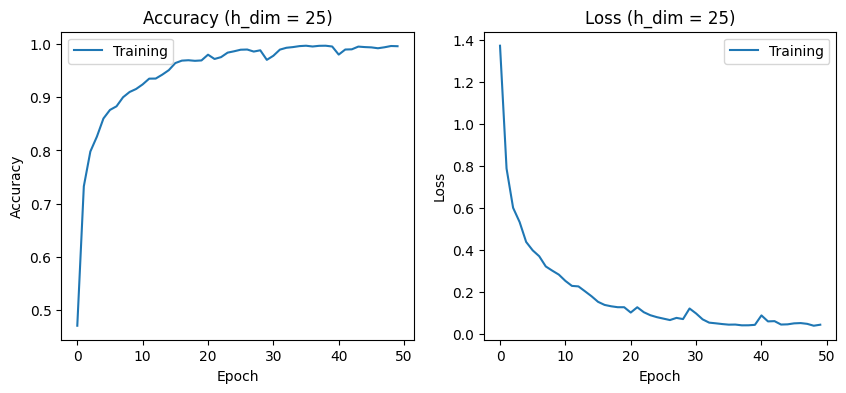

Confusion matrix (training set):


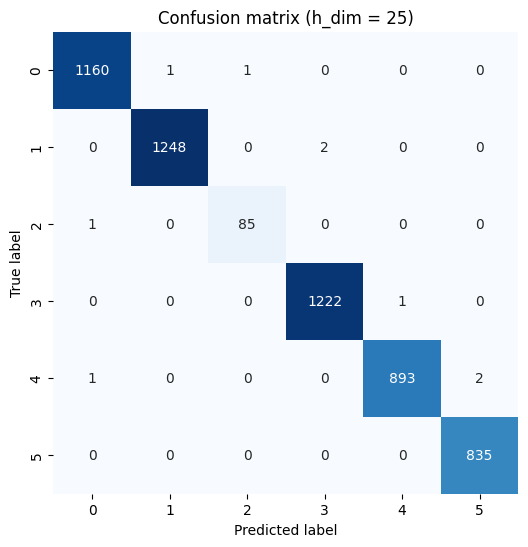

Confusion matrix (test set):


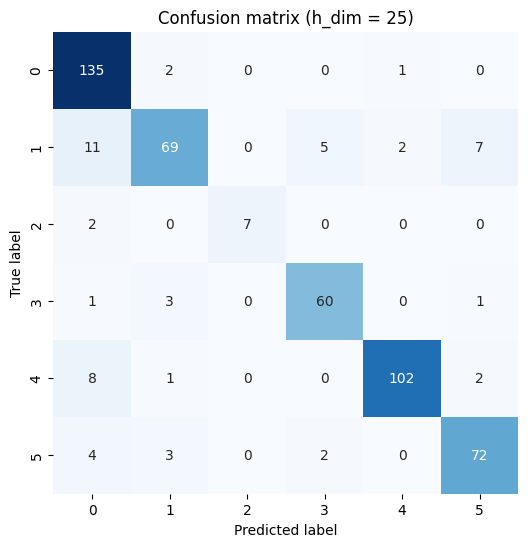



Training model with h_dim = 50
Epoch 1/50
86/86 - 10s - loss: 1.1915 - accuracy: 0.5541 - 10s/epoch - 114ms/step
Epoch 2/50
86/86 - 6s - loss: 0.6207 - accuracy: 0.7949 - 6s/epoch - 73ms/step
Epoch 3/50
86/86 - 5s - loss: 0.4975 - accuracy: 0.8329 - 5s/epoch - 58ms/step
Epoch 4/50
86/86 - 5s - loss: 0.4076 - accuracy: 0.8696 - 5s/epoch - 62ms/step
Epoch 5/50
86/86 - 6s - loss: 0.3538 - accuracy: 0.8877 - 6s/epoch - 68ms/step
Epoch 6/50
86/86 - 5s - loss: 0.3094 - accuracy: 0.9044 - 5s/epoch - 58ms/step
Epoch 7/50
86/86 - 7s - loss: 0.2951 - accuracy: 0.9061 - 7s/epoch - 80ms/step
Epoch 8/50
86/86 - 5s - loss: 0.2351 - accuracy: 0.9298 - 5s/epoch - 58ms/step
Epoch 9/50
86/86 - 6s - loss: 0.2135 - accuracy: 0.9391 - 6s/epoch - 72ms/step
Epoch 10/50
86/86 - 5s - loss: 0.1837 - accuracy: 0.9464 - 5s/epoch - 58ms/step
Epoch 11/50
86/86 - 6s - loss: 0.1604 - accuracy: 0.9571 - 6s/epoch - 72ms/step
Epoch 12/50
86/86 - 5s - loss: 0.1322 - accuracy: 0.9666 - 5s/epoch - 58ms/step
Epoch 13/50
8

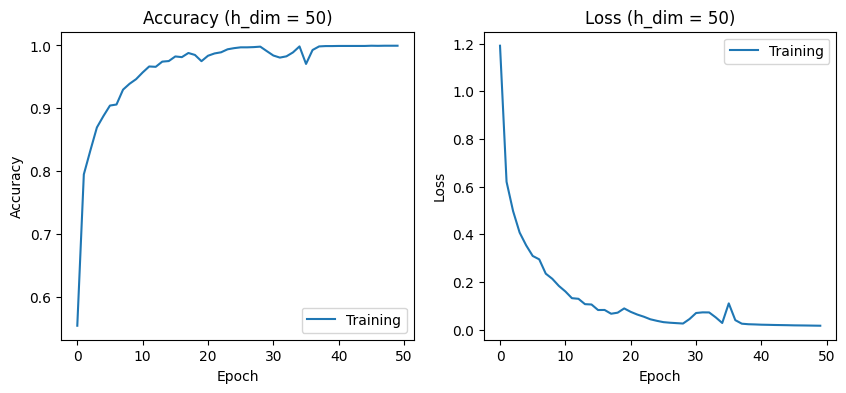

Confusion matrix (training set):


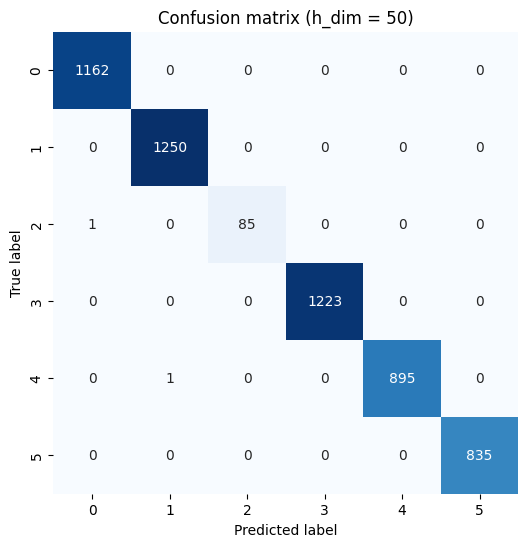

Confusion matrix (test set):


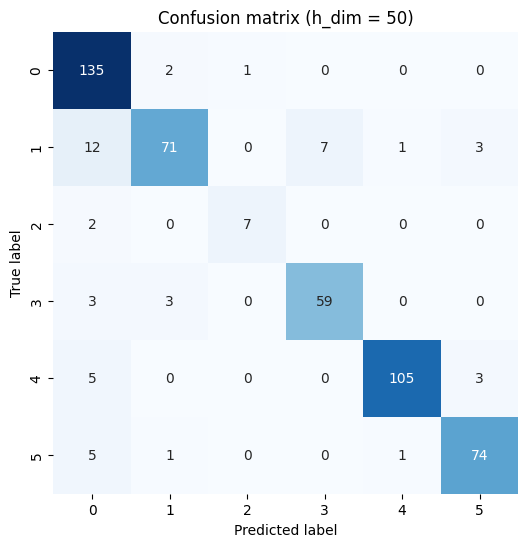



Training model with h_dim = 75
Epoch 1/50
86/86 - 12s - loss: 1.0994 - accuracy: 0.5770 - 12s/epoch - 140ms/step
Epoch 2/50
86/86 - 8s - loss: 0.5867 - accuracy: 0.8030 - 8s/epoch - 94ms/step
Epoch 3/50
86/86 - 7s - loss: 0.4898 - accuracy: 0.8302 - 7s/epoch - 86ms/step
Epoch 4/50
86/86 - 8s - loss: 0.4009 - accuracy: 0.8678 - 8s/epoch - 88ms/step
Epoch 5/50
86/86 - 8s - loss: 0.3230 - accuracy: 0.8956 - 8s/epoch - 94ms/step
Epoch 6/50
86/86 - 7s - loss: 0.2742 - accuracy: 0.9127 - 7s/epoch - 81ms/step
Epoch 7/50
86/86 - 8s - loss: 0.2316 - accuracy: 0.9259 - 8s/epoch - 94ms/step
Epoch 8/50
86/86 - 8s - loss: 0.2010 - accuracy: 0.9402 - 8s/epoch - 88ms/step
Epoch 9/50
86/86 - 7s - loss: 0.1646 - accuracy: 0.9549 - 7s/epoch - 87ms/step
Epoch 10/50
86/86 - 8s - loss: 0.1441 - accuracy: 0.9585 - 8s/epoch - 94ms/step
Epoch 11/50
86/86 - 7s - loss: 0.1175 - accuracy: 0.9663 - 7s/epoch - 82ms/step
Epoch 12/50
86/86 - 8s - loss: 0.0935 - accuracy: 0.9776 - 8s/epoch - 95ms/step
Epoch 13/50
8

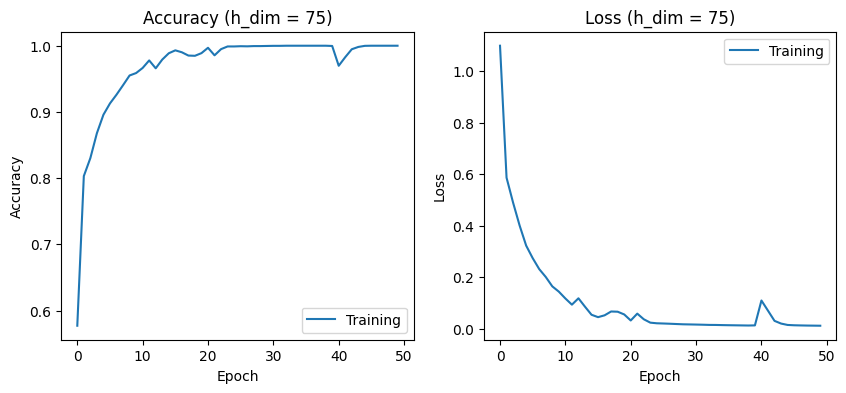

Confusion matrix (training set):


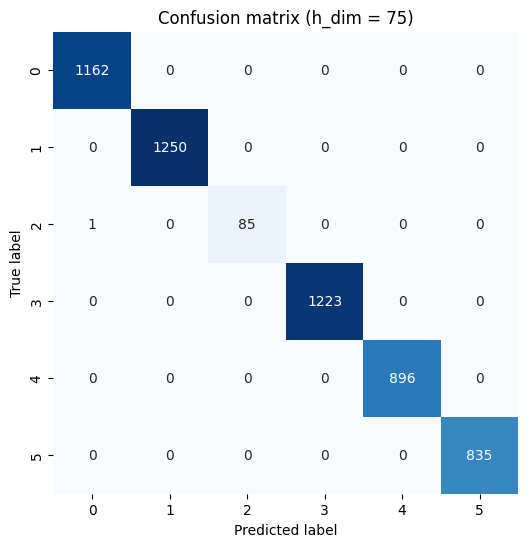

Confusion matrix (test set):


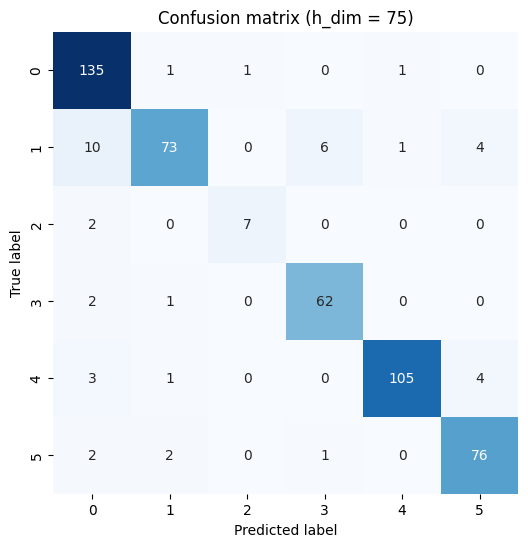



Training model with h_dim = 100
Epoch 1/50
86/86 - 16s - loss: 1.0514 - accuracy: 0.6034 - 16s/epoch - 192ms/step
Epoch 2/50
86/86 - 12s - loss: 0.5797 - accuracy: 0.8054 - 12s/epoch - 135ms/step
Epoch 3/50
86/86 - 10s - loss: 0.4744 - accuracy: 0.8380 - 10s/epoch - 122ms/step
Epoch 4/50
86/86 - 11s - loss: 0.3961 - accuracy: 0.8648 - 11s/epoch - 130ms/step
Epoch 5/50
86/86 - 11s - loss: 0.3156 - accuracy: 0.8944 - 11s/epoch - 134ms/step
Epoch 6/50
86/86 - 12s - loss: 0.2663 - accuracy: 0.9118 - 12s/epoch - 134ms/step
Epoch 7/50
86/86 - 12s - loss: 0.2119 - accuracy: 0.9312 - 12s/epoch - 134ms/step
Epoch 8/50
86/86 - 12s - loss: 0.1856 - accuracy: 0.9411 - 12s/epoch - 134ms/step
Epoch 9/50
86/86 - 11s - loss: 0.1791 - accuracy: 0.9439 - 11s/epoch - 133ms/step
Epoch 10/50
86/86 - 12s - loss: 0.1629 - accuracy: 0.9492 - 12s/epoch - 135ms/step
Epoch 11/50
86/86 - 12s - loss: 0.1013 - accuracy: 0.9714 - 12s/epoch - 134ms/step
Epoch 12/50
86/86 - 11s - loss: 0.0846 - accuracy: 0.9765 - 11

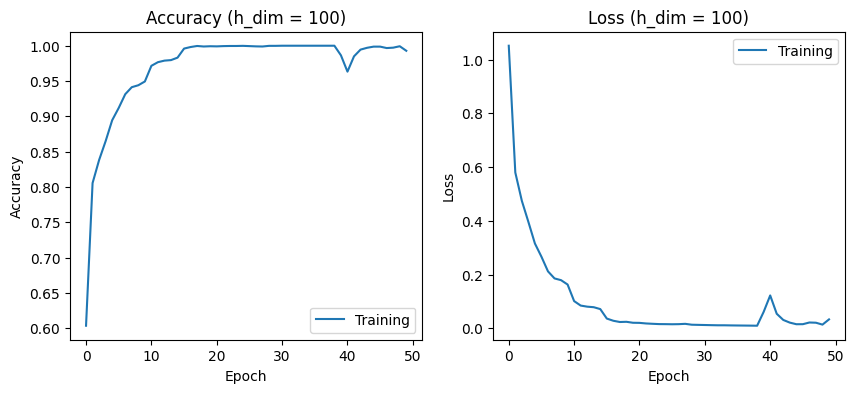

Confusion matrix (training set):


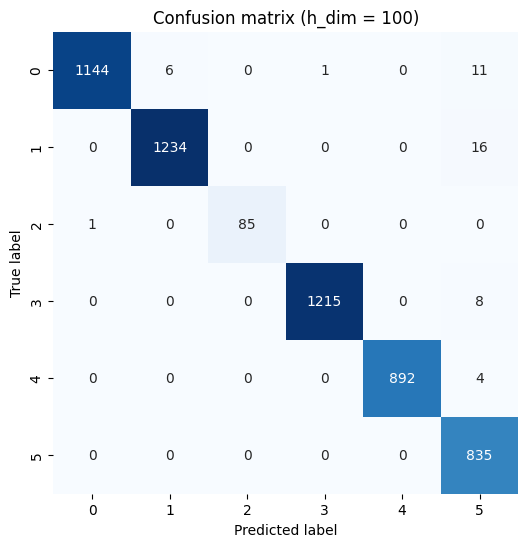

Confusion matrix (test set):


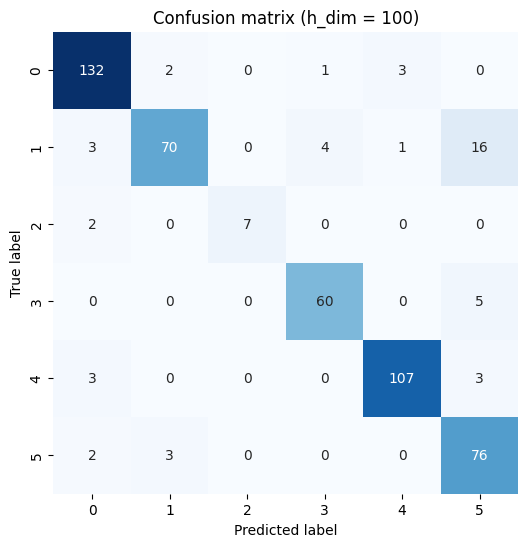

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, return_sequences=True, activation='tanh'))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 50
num_classes = 6
batch_size = 64

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train, num_classes)

    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model{h_dim}confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model{h_dim}confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


Training model with h_dim = 25
Epoch 1/50
86/86 - 10s - loss: 1.3743 - accuracy: 0.4699 - 10s/epoch - 119ms/step
Epoch 2/50
86/86 - 4s - loss: 0.7887 - accuracy: 0.7324 - 4s/epoch - 42ms/step
Epoch 3/50
86/86 - 4s - loss: 0.6017 - accuracy: 0.7979 - 4s/epoch - 42ms/step
Epoch 4/50
86/86 - 5s - loss: 0.5335 - accuracy: 0.8259 - 5s/epoch - 57ms/step
Epoch 5/50
86/86 - 4s - loss: 0.4387 - accuracy: 0.8601 - 4s/epoch - 42ms/step
Epoch 6/50
86/86 - 4s - loss: 0.3987 - accuracy: 0.8762 - 4s/epoch - 42ms/step
Epoch 7/50
86/86 - 5s - loss: 0.3705 - accuracy: 0.8830 - 5s/epoch - 58ms/step
Epoch 8/50
86/86 - 4s - loss: 0.3219 - accuracy: 0.9000 - 4s/epoch - 42ms/step
Epoch 9/50
86/86 - 4s - loss: 0.3018 - accuracy: 0.9099 - 4s/epoch - 43ms/step
Epoch 10/50
86/86 - 5s - loss: 0.2830 - accuracy: 0.9156 - 5s/epoch - 57ms/step
Epoch 11/50
86/86 - 4s - loss: 0.2531 - accuracy: 0.9242 - 4s/epoch - 51ms/step
Epoch 12/50
86/86 - 4s - loss: 0.2292 - accuracy: 0.9351 - 4s/epoch - 43ms/step
Epoch 13/50
86/

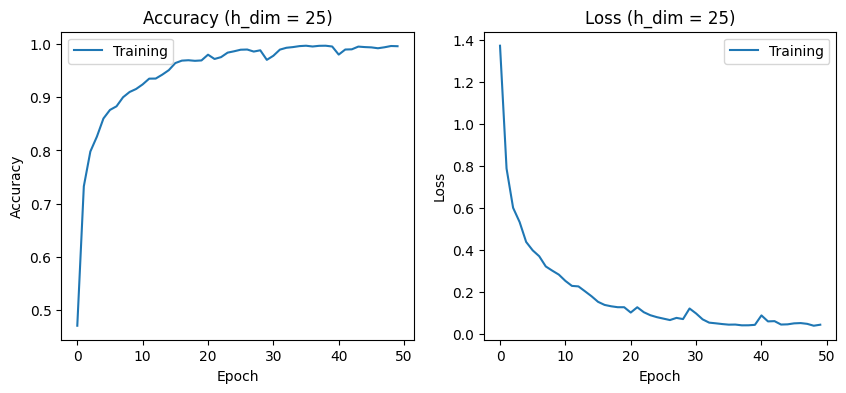

Confusion matrix (training set):


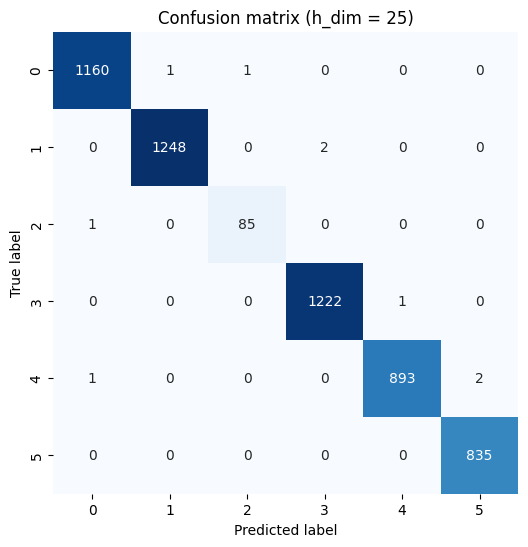

Confusion matrix (test set):


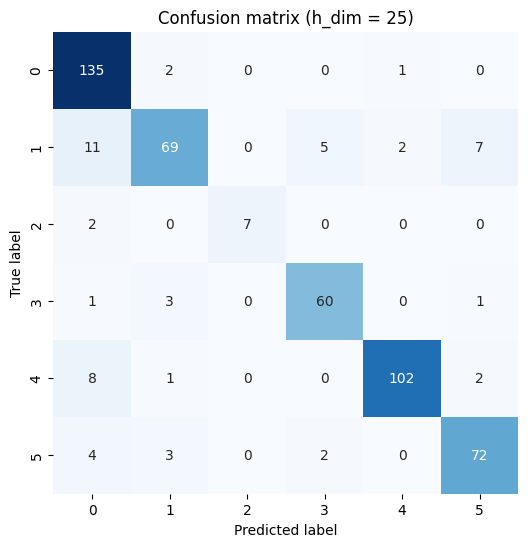



Training model with h_dim = 50
Epoch 1/50
86/86 - 10s - loss: 1.1915 - accuracy: 0.5541 - 10s/epoch - 114ms/step
Epoch 2/50
86/86 - 6s - loss: 0.6207 - accuracy: 0.7949 - 6s/epoch - 73ms/step
Epoch 3/50
86/86 - 5s - loss: 0.4975 - accuracy: 0.8329 - 5s/epoch - 58ms/step
Epoch 4/50
86/86 - 5s - loss: 0.4076 - accuracy: 0.8696 - 5s/epoch - 62ms/step
Epoch 5/50
86/86 - 6s - loss: 0.3538 - accuracy: 0.8877 - 6s/epoch - 68ms/step
Epoch 6/50
86/86 - 5s - loss: 0.3094 - accuracy: 0.9044 - 5s/epoch - 58ms/step
Epoch 7/50
86/86 - 7s - loss: 0.2951 - accuracy: 0.9061 - 7s/epoch - 80ms/step
Epoch 8/50
86/86 - 5s - loss: 0.2351 - accuracy: 0.9298 - 5s/epoch - 58ms/step
Epoch 9/50
86/86 - 6s - loss: 0.2135 - accuracy: 0.9391 - 6s/epoch - 72ms/step
Epoch 10/50
86/86 - 5s - loss: 0.1837 - accuracy: 0.9464 - 5s/epoch - 58ms/step
Epoch 11/50
86/86 - 6s - loss: 0.1604 - accuracy: 0.9571 - 6s/epoch - 72ms/step
Epoch 12/50
86/86 - 5s - loss: 0.1322 - accuracy: 0.9666 - 5s/epoch - 58ms/step
Epoch 13/50
8

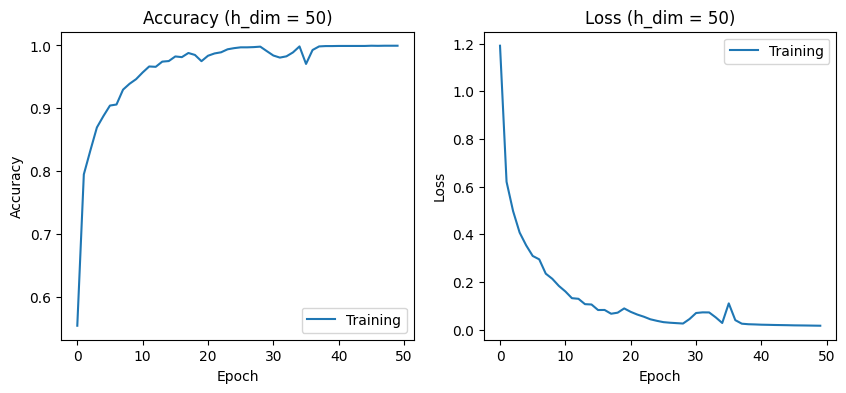

Confusion matrix (training set):


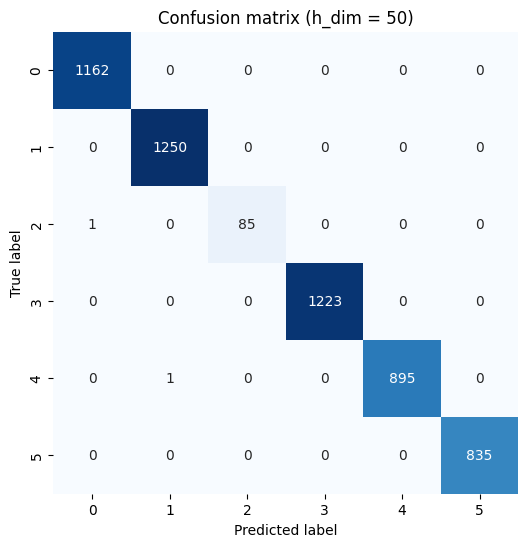

Confusion matrix (test set):


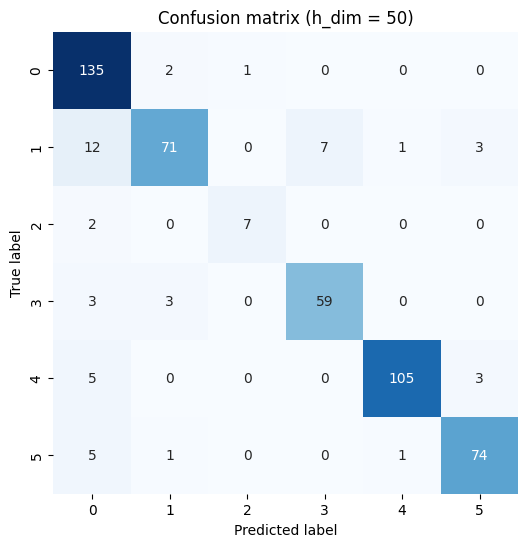



Training model with h_dim = 75
Epoch 1/50
86/86 - 12s - loss: 1.0994 - accuracy: 0.5770 - 12s/epoch - 140ms/step
Epoch 2/50
86/86 - 8s - loss: 0.5867 - accuracy: 0.8030 - 8s/epoch - 94ms/step
Epoch 3/50
86/86 - 7s - loss: 0.4898 - accuracy: 0.8302 - 7s/epoch - 86ms/step
Epoch 4/50
86/86 - 8s - loss: 0.4009 - accuracy: 0.8678 - 8s/epoch - 88ms/step
Epoch 5/50
86/86 - 8s - loss: 0.3230 - accuracy: 0.8956 - 8s/epoch - 94ms/step
Epoch 6/50
86/86 - 7s - loss: 0.2742 - accuracy: 0.9127 - 7s/epoch - 81ms/step
Epoch 7/50
86/86 - 8s - loss: 0.2316 - accuracy: 0.9259 - 8s/epoch - 94ms/step
Epoch 8/50
86/86 - 8s - loss: 0.2010 - accuracy: 0.9402 - 8s/epoch - 88ms/step
Epoch 9/50
86/86 - 7s - loss: 0.1646 - accuracy: 0.9549 - 7s/epoch - 87ms/step
Epoch 10/50
86/86 - 8s - loss: 0.1441 - accuracy: 0.9585 - 8s/epoch - 94ms/step
Epoch 11/50
86/86 - 7s - loss: 0.1175 - accuracy: 0.9663 - 7s/epoch - 82ms/step
Epoch 12/50
86/86 - 8s - loss: 0.0935 - accuracy: 0.9776 - 8s/epoch - 95ms/step
Epoch 13/50
8

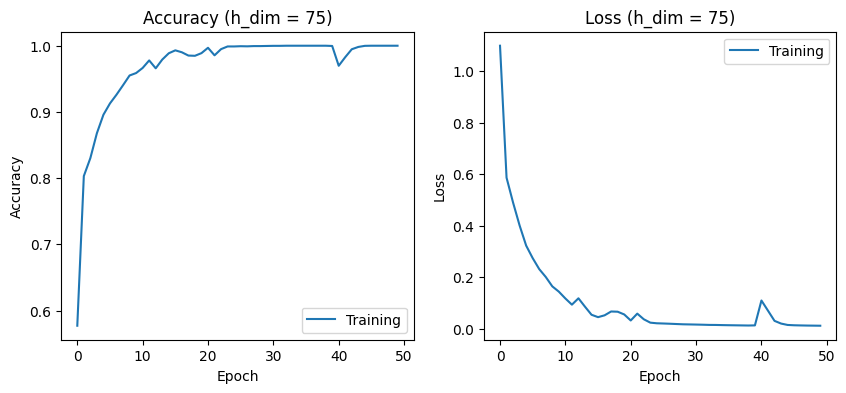

Confusion matrix (training set):


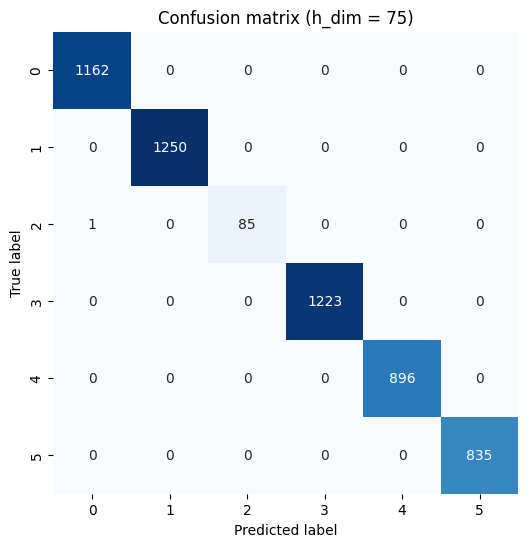

Confusion matrix (test set):


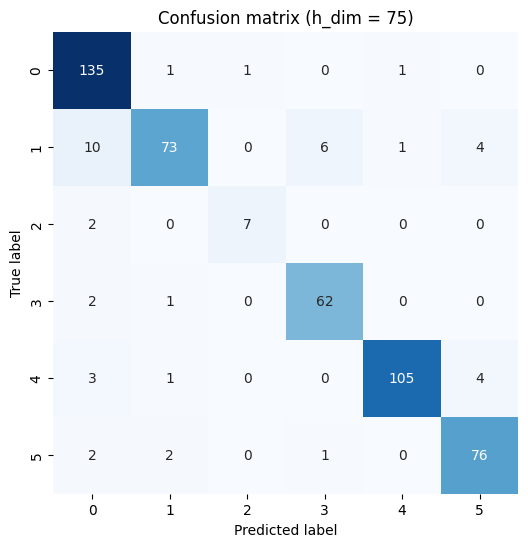



Training model with h_dim = 100
Epoch 1/50
86/86 - 16s - loss: 1.0514 - accuracy: 0.6034 - 16s/epoch - 192ms/step
Epoch 2/50
86/86 - 12s - loss: 0.5797 - accuracy: 0.8054 - 12s/epoch - 135ms/step
Epoch 3/50
86/86 - 10s - loss: 0.4744 - accuracy: 0.8380 - 10s/epoch - 122ms/step
Epoch 4/50
86/86 - 11s - loss: 0.3961 - accuracy: 0.8648 - 11s/epoch - 130ms/step
Epoch 5/50
86/86 - 11s - loss: 0.3156 - accuracy: 0.8944 - 11s/epoch - 134ms/step
Epoch 6/50
86/86 - 12s - loss: 0.2663 - accuracy: 0.9118 - 12s/epoch - 134ms/step
Epoch 7/50
86/86 - 12s - loss: 0.2119 - accuracy: 0.9312 - 12s/epoch - 134ms/step
Epoch 8/50
86/86 - 12s - loss: 0.1856 - accuracy: 0.9411 - 12s/epoch - 134ms/step
Epoch 9/50
86/86 - 11s - loss: 0.1791 - accuracy: 0.9439 - 11s/epoch - 133ms/step
Epoch 10/50
86/86 - 12s - loss: 0.1629 - accuracy: 0.9492 - 12s/epoch - 135ms/step
Epoch 11/50
86/86 - 12s - loss: 0.1013 - accuracy: 0.9714 - 12s/epoch - 134ms/step
Epoch 12/50
86/86 - 11s - loss: 0.0846 - accuracy: 0.9765 - 11

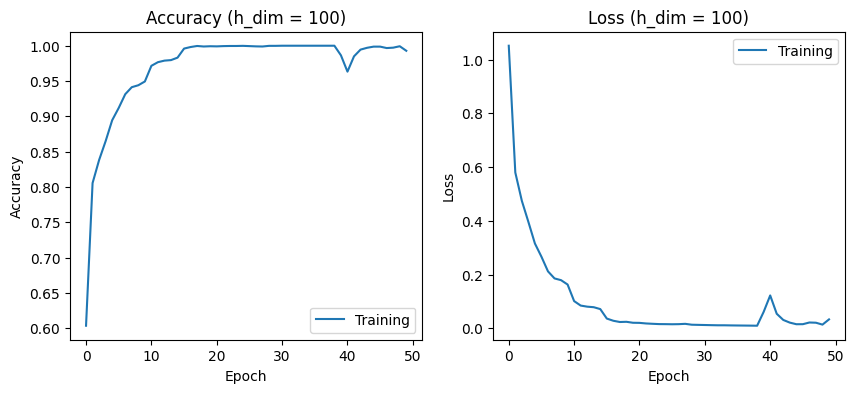

Confusion matrix (training set):


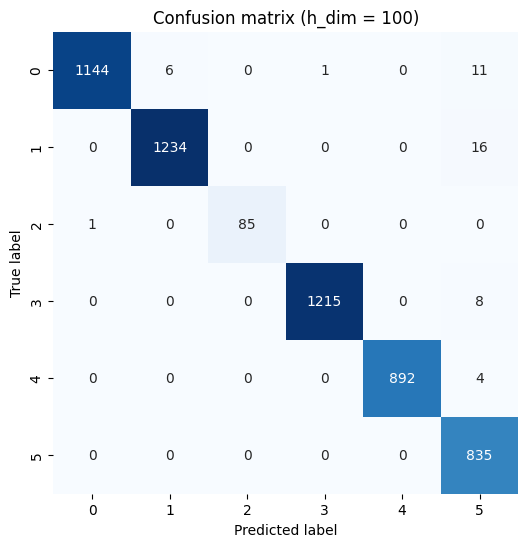

Confusion matrix (test set):


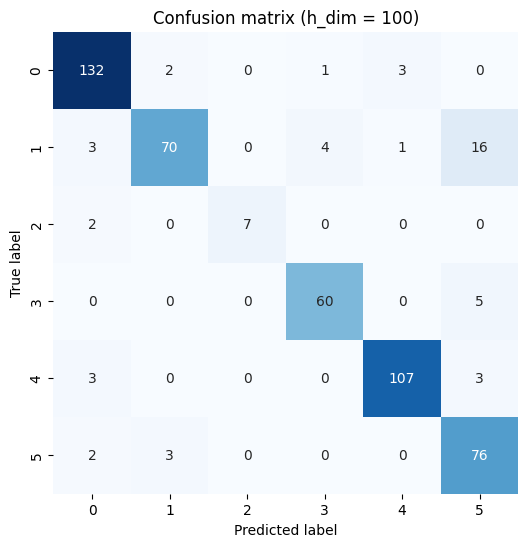

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, return_sequences=True, activation='tanh'))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 50
num_classes = 6
batch_size = 64

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train, num_classes)

    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model{h_dim}confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model{h_dim}confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


Training model with h_dim = 100
Epoch 1/50
86/86 - 16s - loss: 1.0765 - accuracy: 0.6036 - 16s/epoch - 187ms/step
Epoch 2/50
86/86 - 11s - loss: 0.5901 - accuracy: 0.7960 - 11s/epoch - 126ms/step
Epoch 3/50
86/86 - 11s - loss: 0.4689 - accuracy: 0.8380 - 11s/epoch - 127ms/step
Epoch 4/50
86/86 - 11s - loss: 0.3901 - accuracy: 0.8712 - 11s/epoch - 128ms/step
Epoch 5/50
86/86 - 11s - loss: 0.3226 - accuracy: 0.8938 - 11s/epoch - 127ms/step
Epoch 6/50
86/86 - 11s - loss: 0.2691 - accuracy: 0.9121 - 11s/epoch - 128ms/step
Epoch 7/50
86/86 - 11s - loss: 0.2366 - accuracy: 0.9239 - 11s/epoch - 128ms/step
Epoch 8/50
86/86 - 11s - loss: 0.1802 - accuracy: 0.9411 - 11s/epoch - 127ms/step
Epoch 9/50
86/86 - 11s - loss: 0.1395 - accuracy: 0.9585 - 11s/epoch - 129ms/step
Epoch 10/50
86/86 - 11s - loss: 0.1245 - accuracy: 0.9650 - 11s/epoch - 127ms/step
Epoch 11/50
86/86 - 10s - loss: 0.0966 - accuracy: 0.9730 - 10s/epoch - 118ms/step
Epoch 12/50
86/86 - 11s - loss: 0.0775 - accuracy: 0.9820 - 11s/

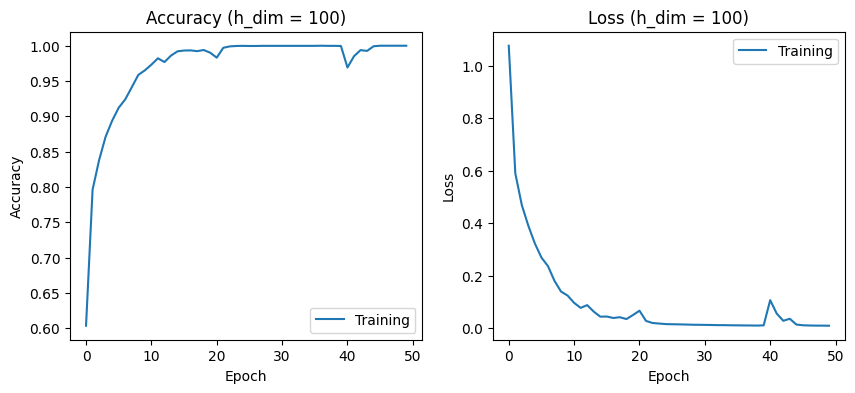

Confusion matrix (training set):


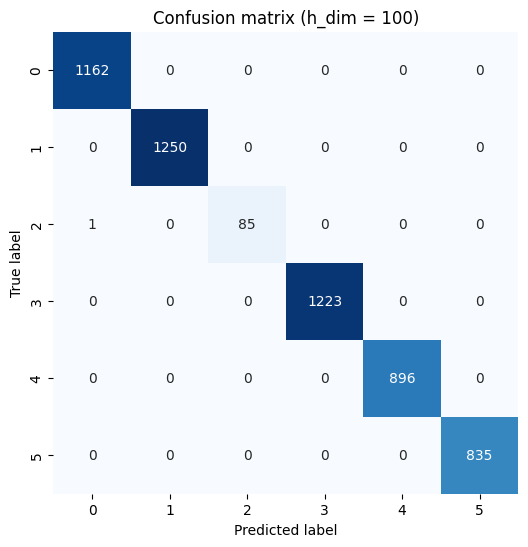

Confusion matrix (test set):


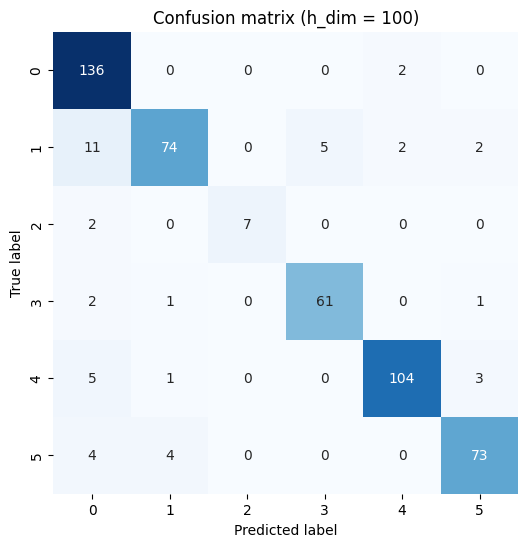

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, return_sequences=True, activation='tanh'))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [100]
epochs = 50
num_classes = 6
batch_size = 64

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train, num_classes)

    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model{h_dim}confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model{h_dim}confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


Training model with h_dim = 100
Epoch 1/50
171/171 - 19s - loss: 0.9291 - accuracy: 0.6550 - 19s/epoch - 112ms/step
Epoch 2/50
171/171 - 15s - loss: 0.5264 - accuracy: 0.8226 - 15s/epoch - 87ms/step
Epoch 3/50
171/171 - 22s - loss: 0.4162 - accuracy: 0.8545 - 22s/epoch - 126ms/step
Epoch 4/50
171/171 - 14s - loss: 0.3269 - accuracy: 0.8887 - 14s/epoch - 80ms/step
Epoch 5/50
171/171 - 14s - loss: 0.2657 - accuracy: 0.9153 - 14s/epoch - 81ms/step
Epoch 6/50
171/171 - 15s - loss: 0.2060 - accuracy: 0.9353 - 15s/epoch - 85ms/step
Epoch 7/50
171/171 - 14s - loss: 0.1564 - accuracy: 0.9510 - 14s/epoch - 82ms/step
Epoch 8/50
171/171 - 14s - loss: 0.1207 - accuracy: 0.9648 - 14s/epoch - 80ms/step
Epoch 9/50
171/171 - 14s - loss: 0.0886 - accuracy: 0.9767 - 14s/epoch - 80ms/step
Epoch 10/50
171/171 - 14s - loss: 0.0815 - accuracy: 0.9776 - 14s/epoch - 81ms/step
Epoch 11/50
171/171 - 14s - loss: 0.0533 - accuracy: 0.9875 - 14s/epoch - 80ms/step
Epoch 12/50
171/171 - 19s - loss: 0.0663 - accuracy

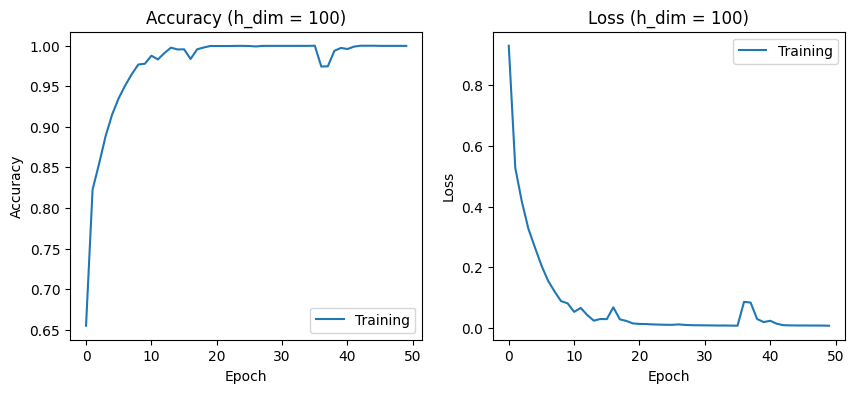

Confusion matrix (training set):


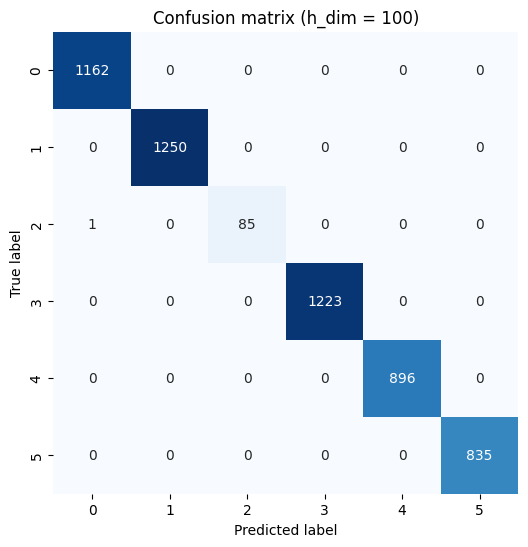

Confusion matrix (test set):


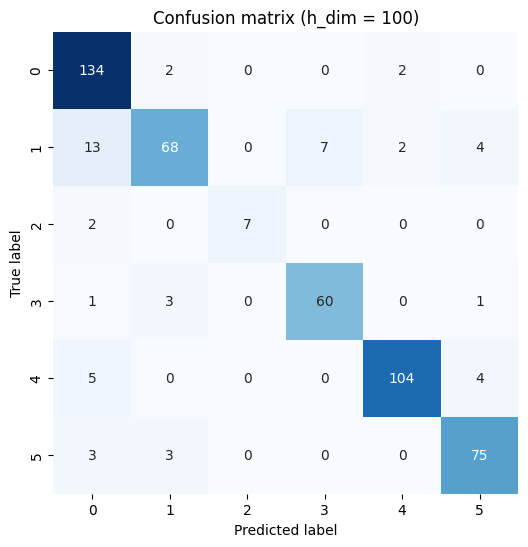

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, return_sequences=True, activation='tanh'))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [100]
epochs = 50
num_classes = 6
batch_size = 32

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train, num_classes)

    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model{h_dim}confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model{h_dim}confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


### Method 1 (+ Val)

Training model with h_dim = 25
Epoch 1/23
60/60 - 8s - loss: 1.4789 - accuracy: 0.4135 - val_loss: 1.1256 - val_accuracy: 0.6131 - 8s/epoch - 135ms/step
Epoch 2/23
60/60 - 4s - loss: 0.9264 - accuracy: 0.6829 - val_loss: 0.8009 - val_accuracy: 0.7317 - 4s/epoch - 70ms/step
Epoch 3/23
60/60 - 3s - loss: 0.7014 - accuracy: 0.7689 - val_loss: 0.7161 - val_accuracy: 0.7555 - 3s/epoch - 48ms/step
Epoch 4/23
60/60 - 3s - loss: 0.5862 - accuracy: 0.8145 - val_loss: 0.6484 - val_accuracy: 0.7873 - 3s/epoch - 52ms/step
Epoch 5/23
60/60 - 3s - loss: 0.5214 - accuracy: 0.8278 - val_loss: 0.6041 - val_accuracy: 0.8013 - 3s/epoch - 52ms/step
Epoch 6/23
60/60 - 4s - loss: 0.4597 - accuracy: 0.8551 - val_loss: 0.6129 - val_accuracy: 0.8123 - 4s/epoch - 71ms/step
Epoch 7/23
60/60 - 3s - loss: 0.4240 - accuracy: 0.8682 - val_loss: 0.5714 - val_accuracy: 0.8185 - 3s/epoch - 53ms/step
Epoch 8/23
60/60 - 3s - loss: 0.3712 - accuracy: 0.8818 - val_loss: 0.5789 - val_accuracy: 0.8264 - 3s/epoch - 52ms/step


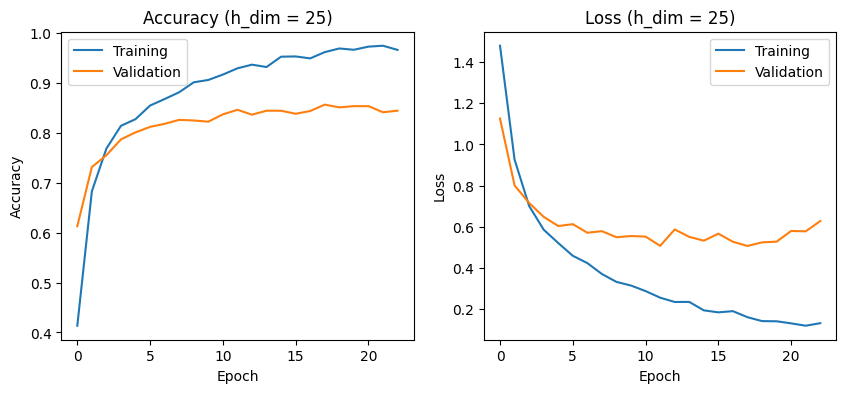

Confusion matrix (training set):


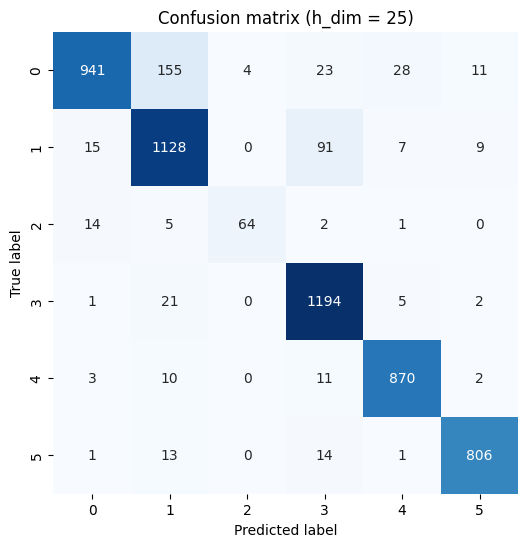

Confusion matrix (test set):


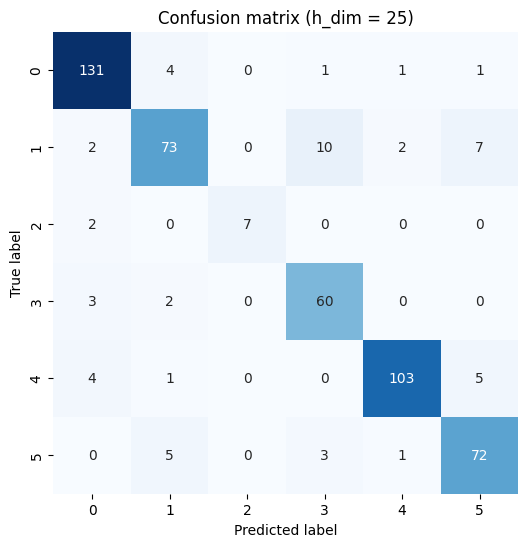



Training model with h_dim = 50
Epoch 1/23
60/60 - 9s - loss: 1.3084 - accuracy: 0.5160 - val_loss: 0.8505 - val_accuracy: 0.7213 - 9s/epoch - 155ms/step
Epoch 2/23
60/60 - 5s - loss: 0.6888 - accuracy: 0.7723 - val_loss: 0.6502 - val_accuracy: 0.7751 - 5s/epoch - 88ms/step
Epoch 3/23
60/60 - 4s - loss: 0.5510 - accuracy: 0.8210 - val_loss: 0.6064 - val_accuracy: 0.7934 - 4s/epoch - 69ms/step
Epoch 4/23
60/60 - 4s - loss: 0.4768 - accuracy: 0.8436 - val_loss: 0.6015 - val_accuracy: 0.7879 - 4s/epoch - 68ms/step
Epoch 5/23
60/60 - 5s - loss: 0.4003 - accuracy: 0.8721 - val_loss: 0.6272 - val_accuracy: 0.7928 - 5s/epoch - 88ms/step
Epoch 6/23
60/60 - 4s - loss: 0.3708 - accuracy: 0.8829 - val_loss: 0.5324 - val_accuracy: 0.8270 - 4s/epoch - 68ms/step
Epoch 7/23
60/60 - 5s - loss: 0.3148 - accuracy: 0.9038 - val_loss: 0.5391 - val_accuracy: 0.8270 - 5s/epoch - 78ms/step
Epoch 8/23
60/60 - 5s - loss: 0.2622 - accuracy: 0.9203 - val_loss: 0.5280 - val_accuracy: 0.8350 - 5s/epoch - 78ms/ste

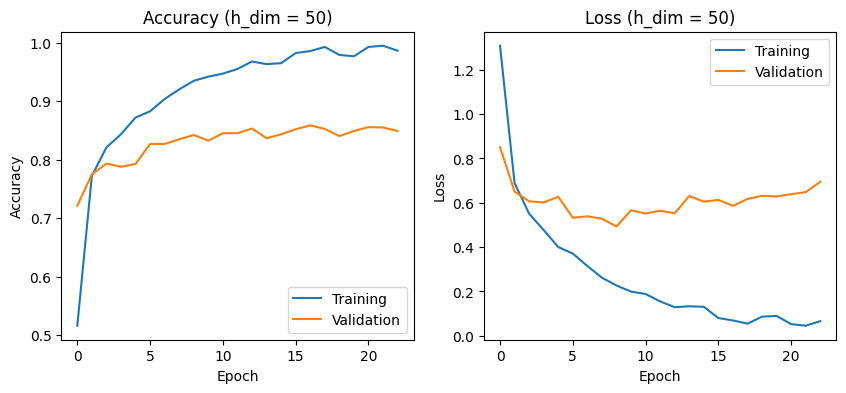

Confusion matrix (training set):


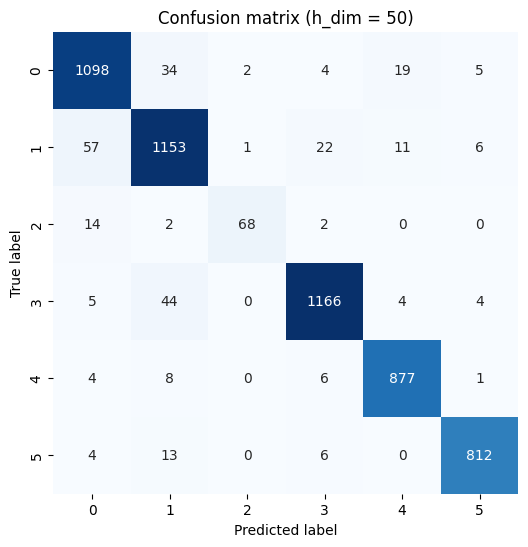

Confusion matrix (test set):


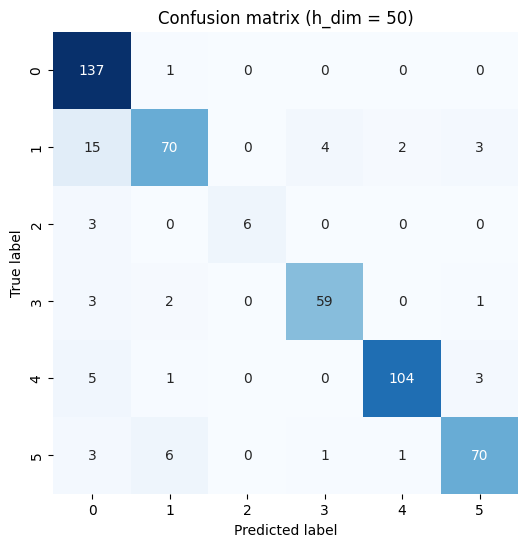



Training model with h_dim = 75
Epoch 1/23
60/60 - 11s - loss: 1.2374 - accuracy: 0.5278 - val_loss: 0.8660 - val_accuracy: 0.7042 - 11s/epoch - 180ms/step
Epoch 2/23
60/60 - 7s - loss: 0.6833 - accuracy: 0.7704 - val_loss: 0.6797 - val_accuracy: 0.7604 - 7s/epoch - 115ms/step
Epoch 3/23
60/60 - 6s - loss: 0.5270 - accuracy: 0.8173 - val_loss: 0.5929 - val_accuracy: 0.7934 - 6s/epoch - 101ms/step
Epoch 4/23
60/60 - 6s - loss: 0.4318 - accuracy: 0.8546 - val_loss: 0.5765 - val_accuracy: 0.8038 - 6s/epoch - 106ms/step
Epoch 5/23
60/60 - 7s - loss: 0.3811 - accuracy: 0.8792 - val_loss: 0.6522 - val_accuracy: 0.7910 - 7s/epoch - 108ms/step
Epoch 6/23
60/60 - 6s - loss: 0.3320 - accuracy: 0.8933 - val_loss: 0.5429 - val_accuracy: 0.8362 - 6s/epoch - 102ms/step
Epoch 7/23
60/60 - 7s - loss: 0.2604 - accuracy: 0.9198 - val_loss: 0.5655 - val_accuracy: 0.8270 - 7s/epoch - 114ms/step
Epoch 8/23
60/60 - 6s - loss: 0.2402 - accuracy: 0.9253 - val_loss: 0.5332 - val_accuracy: 0.8331 - 6s/epoch - 

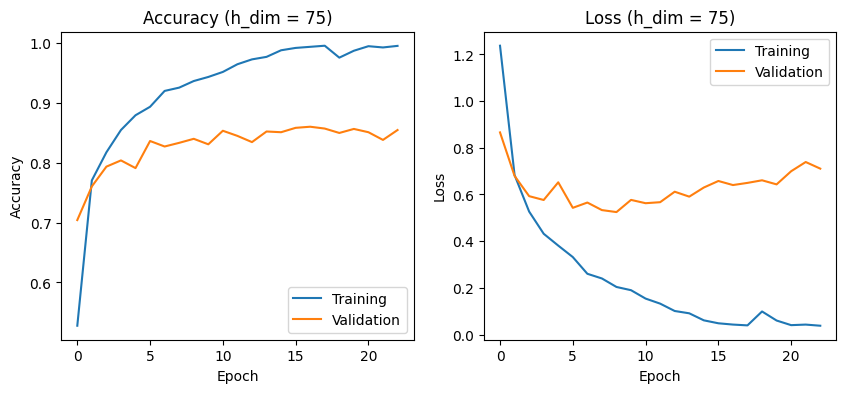

Confusion matrix (training set):


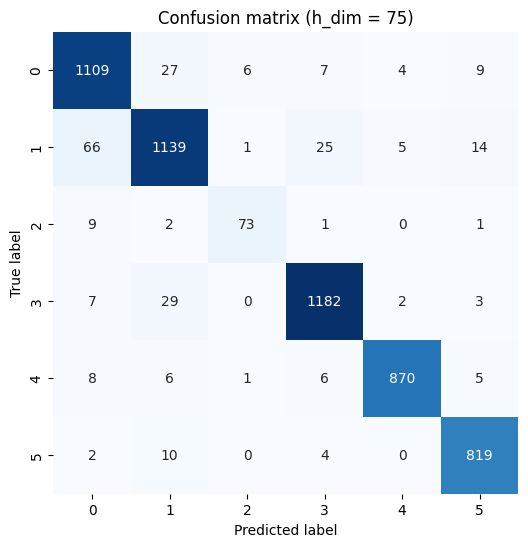

Confusion matrix (test set):


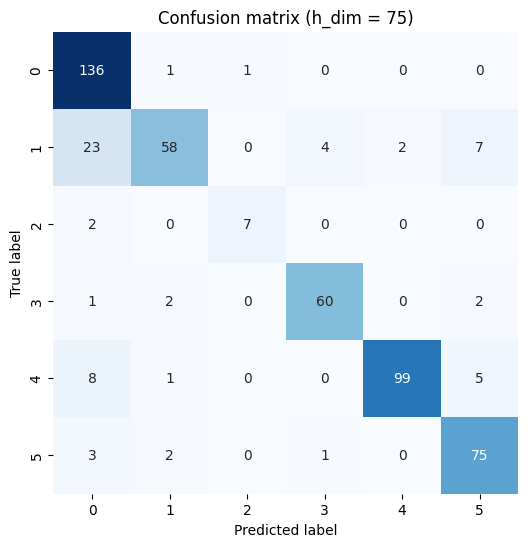



Training model with h_dim = 100
Epoch 1/23
60/60 - 16s - loss: 1.2146 - accuracy: 0.5335 - val_loss: 0.8959 - val_accuracy: 0.6925 - 16s/epoch - 259ms/step
Epoch 2/23
60/60 - 9s - loss: 0.6802 - accuracy: 0.7678 - val_loss: 0.6009 - val_accuracy: 0.7848 - 9s/epoch - 156ms/step
Epoch 3/23
60/60 - 8s - loss: 0.5143 - accuracy: 0.8221 - val_loss: 0.5522 - val_accuracy: 0.8111 - 8s/epoch - 141ms/step
Epoch 4/23
60/60 - 9s - loss: 0.4151 - accuracy: 0.8611 - val_loss: 0.5415 - val_accuracy: 0.8289 - 9s/epoch - 155ms/step
Epoch 5/23
60/60 - 9s - loss: 0.3461 - accuracy: 0.8834 - val_loss: 0.6454 - val_accuracy: 0.7952 - 9s/epoch - 154ms/step
Epoch 6/23
60/60 - 9s - loss: 0.2998 - accuracy: 0.9030 - val_loss: 0.5223 - val_accuracy: 0.8405 - 9s/epoch - 154ms/step
Epoch 7/23
60/60 - 10s - loss: 0.2464 - accuracy: 0.9167 - val_loss: 0.5364 - val_accuracy: 0.8380 - 10s/epoch - 163ms/step
Epoch 8/23
60/60 - 9s - loss: 0.2156 - accuracy: 0.9306 - val_loss: 0.5051 - val_accuracy: 0.8545 - 9s/epoch

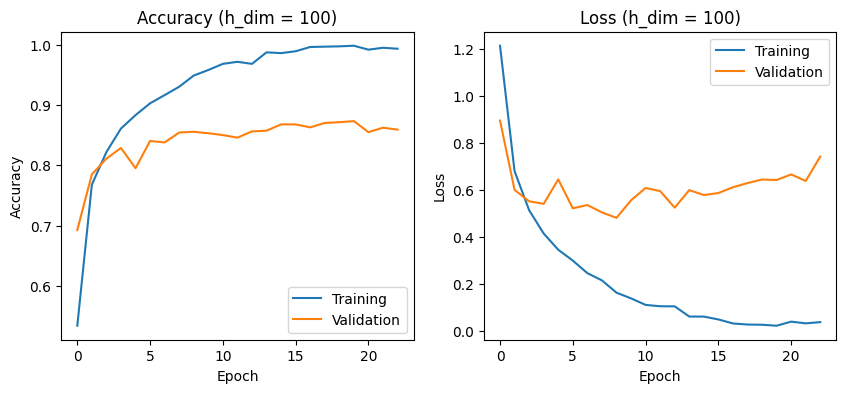

Confusion matrix (training set):


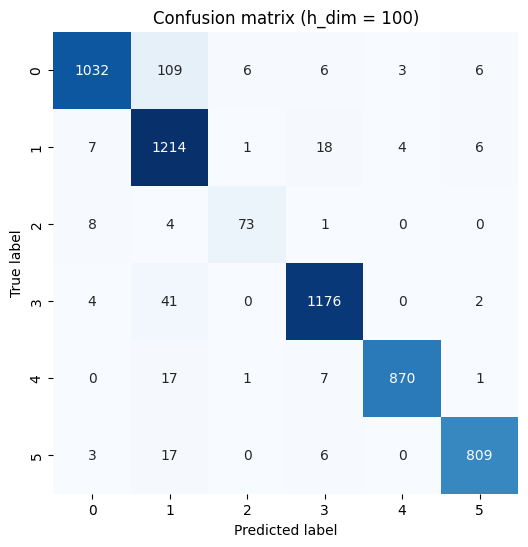

Confusion matrix (test set):


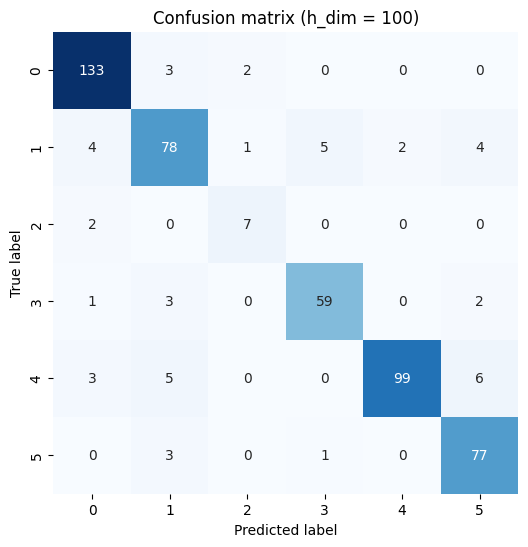

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, return_sequences=True, activation='tanh'))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 23
num_classes = 6
batch_size = 64

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Split the training set for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train_split, num_classes)
    y_val_encoded = encode_labels(y_val_split, num_classes)

    history = model.fit(X_train_split, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_encoded), verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model_{h_dim}_confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model_{h_dim}_confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


### Method 2

Training model with h_dim = 25
Epoch 1/50
171/171 - 10s - loss: 1.2288 - accuracy: 0.5200 - 10s/epoch - 57ms/step
Epoch 2/50
171/171 - 4s - loss: 0.6747 - accuracy: 0.7652 - 4s/epoch - 22ms/step
Epoch 3/50
171/171 - 4s - loss: 0.5192 - accuracy: 0.8283 - 4s/epoch - 21ms/step
Epoch 4/50
171/171 - 3s - loss: 0.4353 - accuracy: 0.8536 - 3s/epoch - 18ms/step
Epoch 5/50
171/171 - 3s - loss: 0.3735 - accuracy: 0.8736 - 3s/epoch - 19ms/step
Epoch 6/50
171/171 - 4s - loss: 0.3188 - accuracy: 0.8953 - 4s/epoch - 24ms/step
Epoch 7/50
171/171 - 3s - loss: 0.2655 - accuracy: 0.9147 - 3s/epoch - 19ms/step
Epoch 8/50
171/171 - 3s - loss: 0.2462 - accuracy: 0.9215 - 3s/epoch - 19ms/step
Epoch 9/50
171/171 - 3s - loss: 0.2044 - accuracy: 0.9347 - 3s/epoch - 19ms/step
Epoch 10/50
171/171 - 4s - loss: 0.1768 - accuracy: 0.9477 - 4s/epoch - 23ms/step
Epoch 11/50
171/171 - 3s - loss: 0.1542 - accuracy: 0.9551 - 3s/epoch - 19ms/step
Epoch 12/50
171/171 - 3s - loss: 0.1399 - accuracy: 0.9598 - 3s/epoch - 19

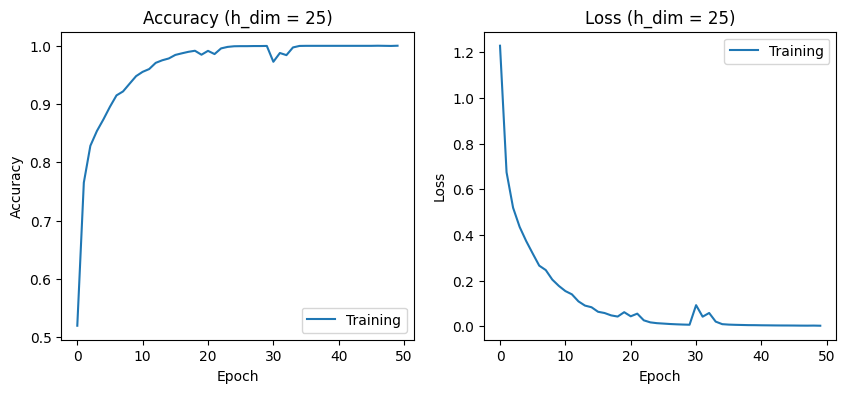

Confusion matrix (training set):


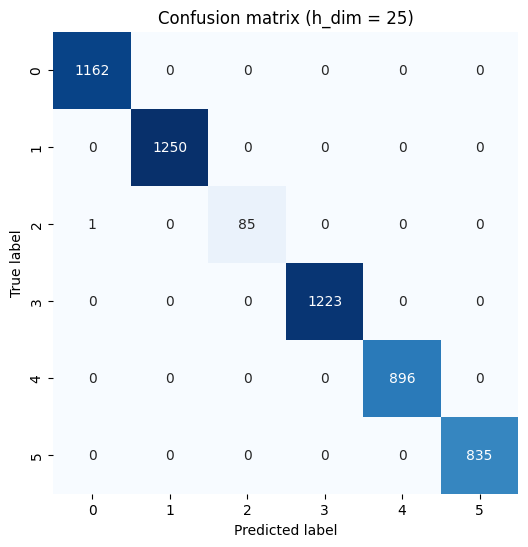

Confusion matrix (test set):


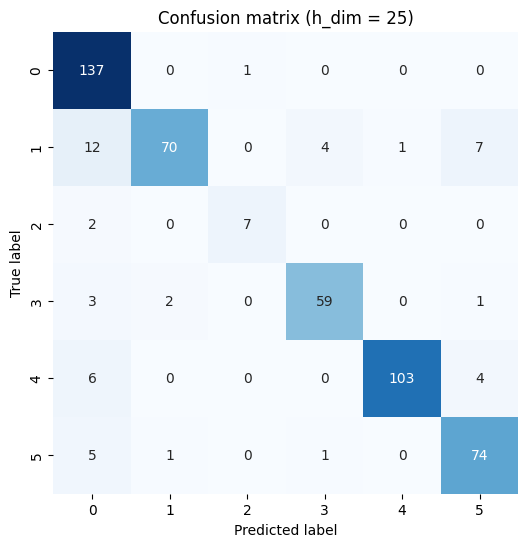



Training model with h_dim = 50
Epoch 1/50
171/171 - 8s - loss: 1.1036 - accuracy: 0.5609 - 8s/epoch - 45ms/step
Epoch 2/50
171/171 - 5s - loss: 0.5724 - accuracy: 0.8019 - 5s/epoch - 31ms/step
Epoch 3/50
171/171 - 5s - loss: 0.4419 - accuracy: 0.8485 - 5s/epoch - 27ms/step
Epoch 4/50
171/171 - 6s - loss: 0.3590 - accuracy: 0.8793 - 6s/epoch - 35ms/step
Epoch 5/50
171/171 - 5s - loss: 0.2922 - accuracy: 0.9017 - 5s/epoch - 27ms/step
Epoch 6/50
171/171 - 6s - loss: 0.2457 - accuracy: 0.9171 - 6s/epoch - 35ms/step
Epoch 7/50
171/171 - 5s - loss: 0.1952 - accuracy: 0.9362 - 5s/epoch - 27ms/step
Epoch 8/50
171/171 - 5s - loss: 0.1596 - accuracy: 0.9492 - 5s/epoch - 27ms/step
Epoch 9/50
171/171 - 6s - loss: 0.1204 - accuracy: 0.9639 - 6s/epoch - 35ms/step
Epoch 10/50
171/171 - 5s - loss: 0.1112 - accuracy: 0.9652 - 5s/epoch - 27ms/step
Epoch 11/50
171/171 - 6s - loss: 0.0964 - accuracy: 0.9729 - 6s/epoch - 36ms/step
Epoch 12/50
171/171 - 5s - loss: 0.0665 - accuracy: 0.9818 - 5s/epoch - 27

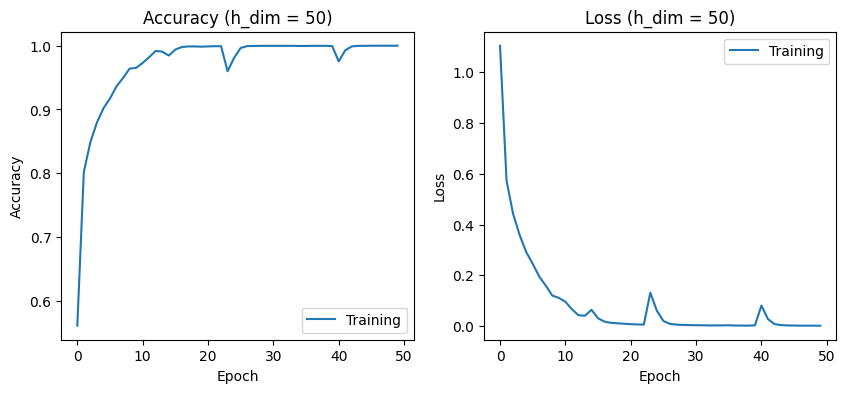

Confusion matrix (training set):


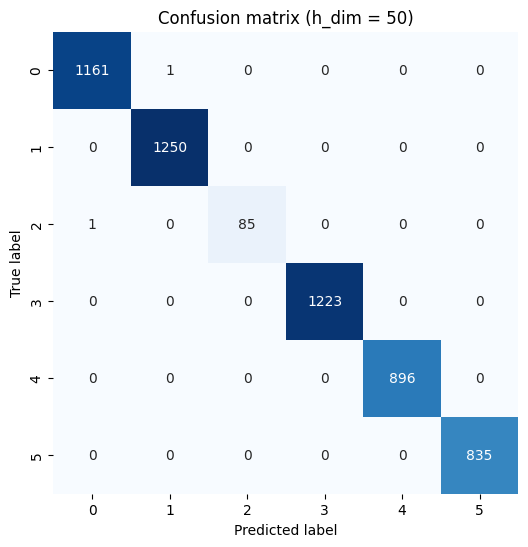

Confusion matrix (test set):


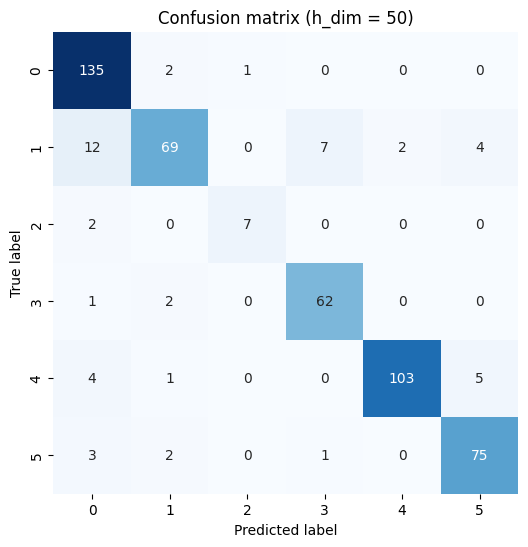



Training model with h_dim = 75
Epoch 1/50
171/171 - 11s - loss: 0.9996 - accuracy: 0.6190 - 11s/epoch - 64ms/step
Epoch 2/50
171/171 - 6s - loss: 0.5265 - accuracy: 0.8175 - 6s/epoch - 35ms/step
Epoch 3/50
171/171 - 7s - loss: 0.4110 - accuracy: 0.8608 - 7s/epoch - 43ms/step
Epoch 4/50
171/171 - 6s - loss: 0.3214 - accuracy: 0.8859 - 6s/epoch - 35ms/step
Epoch 5/50
171/171 - 7s - loss: 0.2507 - accuracy: 0.9145 - 7s/epoch - 43ms/step
Epoch 6/50
171/171 - 6s - loss: 0.2043 - accuracy: 0.9294 - 6s/epoch - 35ms/step
Epoch 7/50
171/171 - 7s - loss: 0.1543 - accuracy: 0.9527 - 7s/epoch - 42ms/step
Epoch 8/50
171/171 - 6s - loss: 0.1190 - accuracy: 0.9624 - 6s/epoch - 35ms/step
Epoch 9/50
171/171 - 7s - loss: 0.0744 - accuracy: 0.9796 - 7s/epoch - 43ms/step
Epoch 10/50
171/171 - 6s - loss: 0.0591 - accuracy: 0.9855 - 6s/epoch - 35ms/step
Epoch 11/50
171/171 - 7s - loss: 0.0828 - accuracy: 0.9762 - 7s/epoch - 43ms/step
Epoch 12/50
171/171 - 6s - loss: 0.0283 - accuracy: 0.9945 - 6s/epoch - 

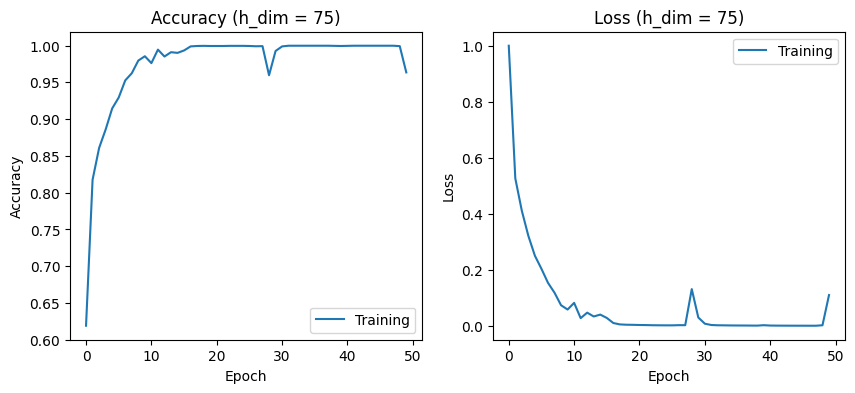

Confusion matrix (training set):


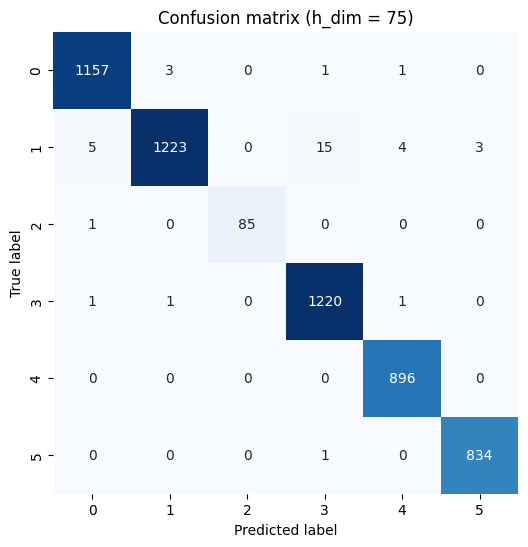

Confusion matrix (test set):


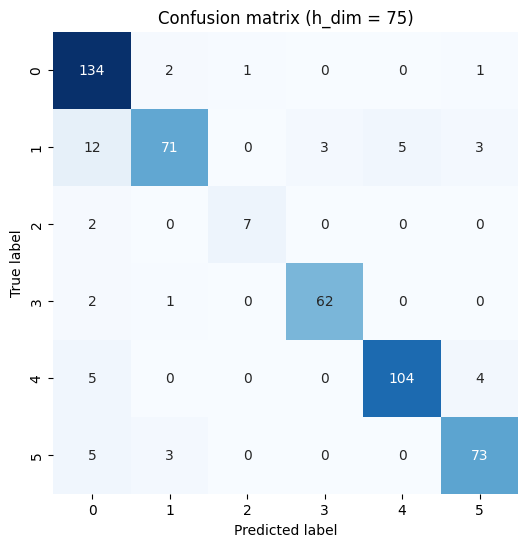



Training model with h_dim = 100
Epoch 1/50
171/171 - 11s - loss: 0.9835 - accuracy: 0.6256 - 11s/epoch - 64ms/step
Epoch 2/50
171/171 - 7s - loss: 0.5161 - accuracy: 0.8195 - 7s/epoch - 44ms/step
Epoch 3/50
171/171 - 9s - loss: 0.3881 - accuracy: 0.8632 - 9s/epoch - 51ms/step
Epoch 4/50
171/171 - 9s - loss: 0.3082 - accuracy: 0.8890 - 9s/epoch - 51ms/step
Epoch 5/50
171/171 - 7s - loss: 0.2375 - accuracy: 0.9222 - 7s/epoch - 44ms/step
Epoch 6/50
171/171 - 9s - loss: 0.1742 - accuracy: 0.9430 - 9s/epoch - 51ms/step
Epoch 7/50
171/171 - 9s - loss: 0.1336 - accuracy: 0.9565 - 9s/epoch - 50ms/step
Epoch 8/50
171/171 - 8s - loss: 0.0945 - accuracy: 0.9712 - 8s/epoch - 45ms/step
Epoch 9/50
171/171 - 9s - loss: 0.0884 - accuracy: 0.9743 - 9s/epoch - 52ms/step
Epoch 10/50
171/171 - 9s - loss: 0.0540 - accuracy: 0.9822 - 9s/epoch - 51ms/step
Epoch 11/50
171/171 - 8s - loss: 0.0353 - accuracy: 0.9917 - 8s/epoch - 45ms/step
Epoch 12/50
171/171 - 9s - loss: 0.0390 - accuracy: 0.9895 - 9s/epoch -

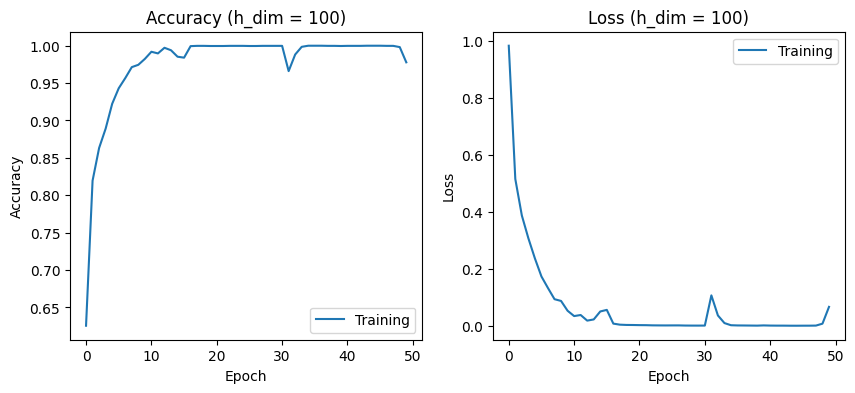

Confusion matrix (training set):


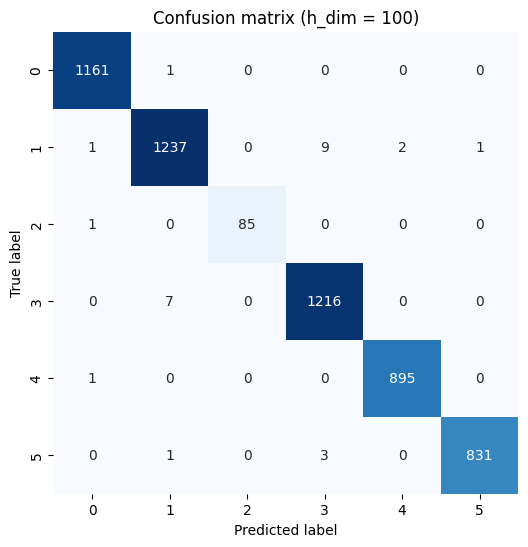

Confusion matrix (test set):


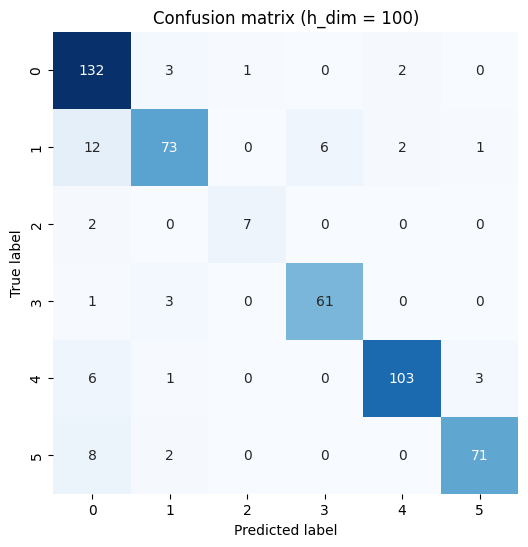

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Function to encode labels as one-hot vectors
def encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

from keras.regularizers import l2

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 50
num_classes = 6
batch_size = 32

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Encode labels as one-hot vectors
    y_train_encoded = encode_labels(y_train, num_classes)

    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    train_accuracy = model.evaluate(X_train, encode_labels(y_train, num_classes), verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, encode_labels(y_test, num_classes), verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model{h_dim}confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model{h_dim}confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


### Method 2 (+ Val)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data
X_train = train_padded_sequences
y_train = train_data['encoded_labels']
X_test = test_padded_sequences
y_test = test_data['encoded_labels']

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 25
num_classes = 6
batch_size = 32

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(h_dim, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

Training model with h_dim = 25
Epoch 1/25
137/137 - 10s - loss: 1.2869 - accuracy: 0.5022 - val_loss: 0.9505 - val_accuracy: 0.6792 - 10s/epoch - 71ms/step
Epoch 2/25
137/137 - 3s - loss: 0.7601 - accuracy: 0.7365 - val_loss: 0.6633 - val_accuracy: 0.7736 - 3s/epoch - 21ms/step
Epoch 3/25
137/137 - 3s - loss: 0.5662 - accuracy: 0.8104 - val_loss: 0.5784 - val_accuracy: 0.7956 - 3s/epoch - 21ms/step
Epoch 4/25
137/137 - 3s - loss: 0.4744 - accuracy: 0.8454 - val_loss: 0.5260 - val_accuracy: 0.8258 - 3s/epoch - 21ms/step
Epoch 5/25
137/137 - 4s - loss: 0.3973 - accuracy: 0.8746 - val_loss: 0.4918 - val_accuracy: 0.8332 - 4s/epoch - 29ms/step
Epoch 6/25
137/137 - 3s - loss: 0.3421 - accuracy: 0.8906 - val_loss: 0.5111 - val_accuracy: 0.8295 - 3s/epoch - 21ms/step
Epoch 7/25
137/137 - 3s - loss: 0.3219 - accuracy: 0.8950 - val_loss: 0.4370 - val_accuracy: 0.8524 - 3s/epoch - 21ms/step
Epoch 8/25
137/137 - 3s - loss: 0.2546 - accuracy: 0.9170 - val_loss: 0.4706 - val_accuracy: 0.8524 - 3s/e

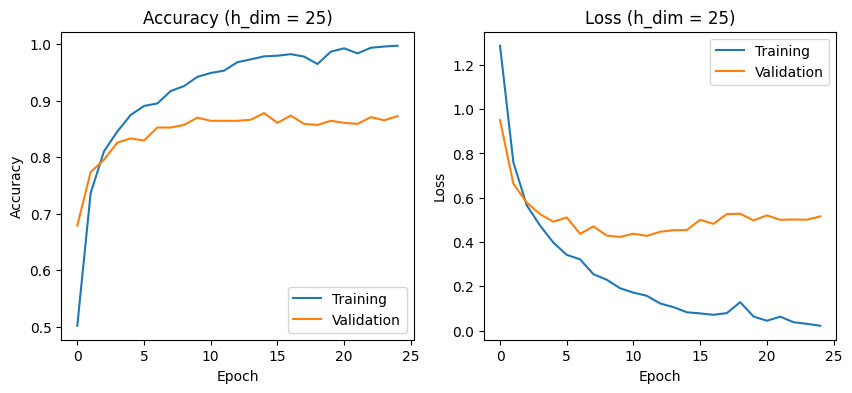

Confusion matrix (training set):


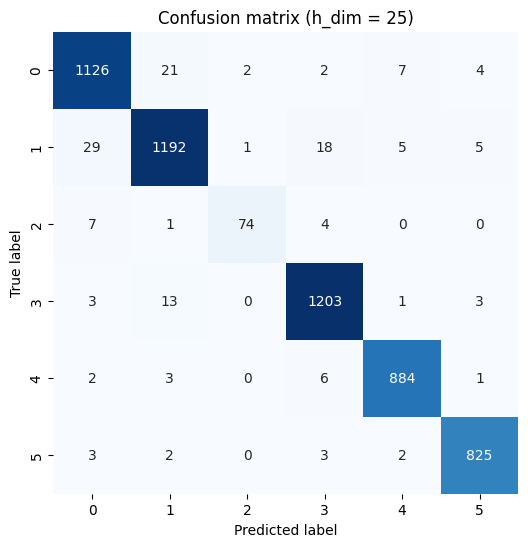

Confusion matrix (test set):


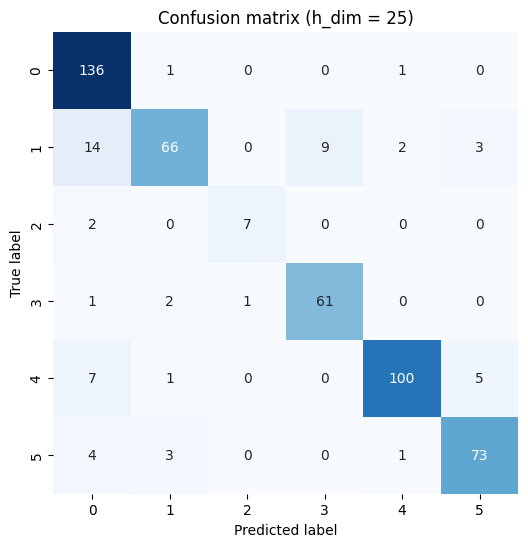



Training model with h_dim = 50
Epoch 1/25
137/137 - 28s - loss: 1.1919 - accuracy: 0.5414 - val_loss: 0.7787 - val_accuracy: 0.6975 - 28s/epoch - 203ms/step
Epoch 2/25
137/137 - 4s - loss: 0.6299 - accuracy: 0.7769 - val_loss: 0.5814 - val_accuracy: 0.7929 - 4s/epoch - 32ms/step
Epoch 3/25
137/137 - 5s - loss: 0.4745 - accuracy: 0.8372 - val_loss: 0.5564 - val_accuracy: 0.8029 - 5s/epoch - 37ms/step
Epoch 4/25
137/137 - 5s - loss: 0.3941 - accuracy: 0.8654 - val_loss: 0.4960 - val_accuracy: 0.8286 - 5s/epoch - 35ms/step
Epoch 5/25
137/137 - 4s - loss: 0.3233 - accuracy: 0.8911 - val_loss: 0.4825 - val_accuracy: 0.8323 - 4s/epoch - 32ms/step
Epoch 6/25
137/137 - 6s - loss: 0.2710 - accuracy: 0.9092 - val_loss: 0.4454 - val_accuracy: 0.8396 - 6s/epoch - 41ms/step
Epoch 7/25
137/137 - 4s - loss: 0.2081 - accuracy: 0.9340 - val_loss: 0.4003 - val_accuracy: 0.8689 - 4s/epoch - 31ms/step
Epoch 8/25
137/137 - 4s - loss: 0.1707 - accuracy: 0.9479 - val_loss: 0.4704 - val_accuracy: 0.8414 - 4

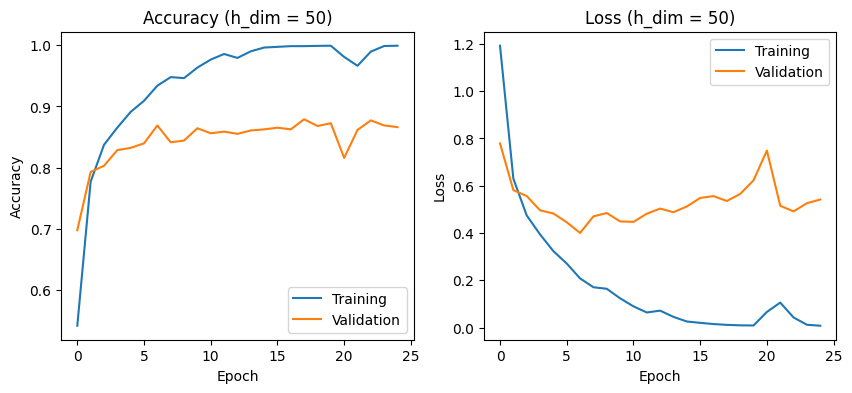

Confusion matrix (training set):


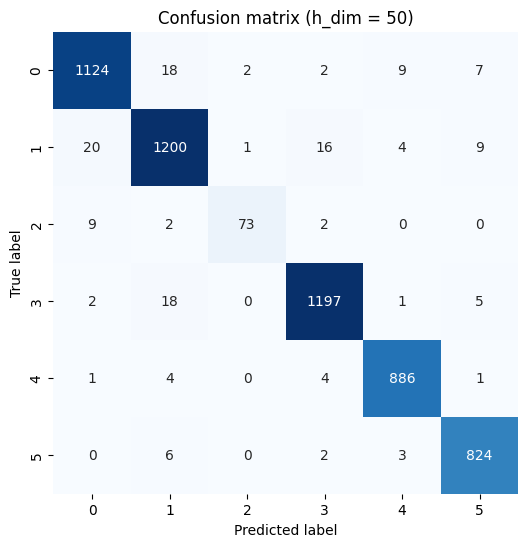

Confusion matrix (test set):


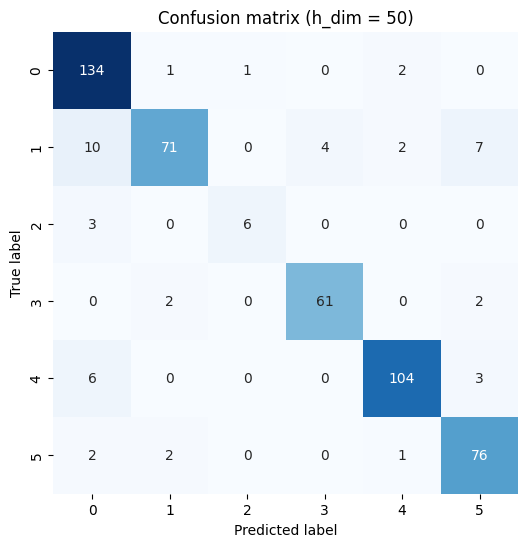



Training model with h_dim = 75
Epoch 1/25
137/137 - 8s - loss: 1.1490 - accuracy: 0.5506 - val_loss: 0.7709 - val_accuracy: 0.7360 - 8s/epoch - 59ms/step
Epoch 2/25
137/137 - 7s - loss: 0.6101 - accuracy: 0.7906 - val_loss: 0.5496 - val_accuracy: 0.8093 - 7s/epoch - 48ms/step
Epoch 3/25
137/137 - 5s - loss: 0.4461 - accuracy: 0.8516 - val_loss: 0.5025 - val_accuracy: 0.8130 - 5s/epoch - 39ms/step
Epoch 4/25
137/137 - 7s - loss: 0.3543 - accuracy: 0.8812 - val_loss: 0.4697 - val_accuracy: 0.8258 - 7s/epoch - 48ms/step
Epoch 5/25
137/137 - 5s - loss: 0.2851 - accuracy: 0.9005 - val_loss: 0.4829 - val_accuracy: 0.8295 - 5s/epoch - 38ms/step
Epoch 6/25
137/137 - 6s - loss: 0.2216 - accuracy: 0.9236 - val_loss: 0.4340 - val_accuracy: 0.8543 - 6s/epoch - 47ms/step
Epoch 7/25
137/137 - 6s - loss: 0.1649 - accuracy: 0.9457 - val_loss: 0.4193 - val_accuracy: 0.8717 - 6s/epoch - 41ms/step
Epoch 8/25
137/137 - 6s - loss: 0.1280 - accuracy: 0.9596 - val_loss: 0.4680 - val_accuracy: 0.8570 - 6s/e

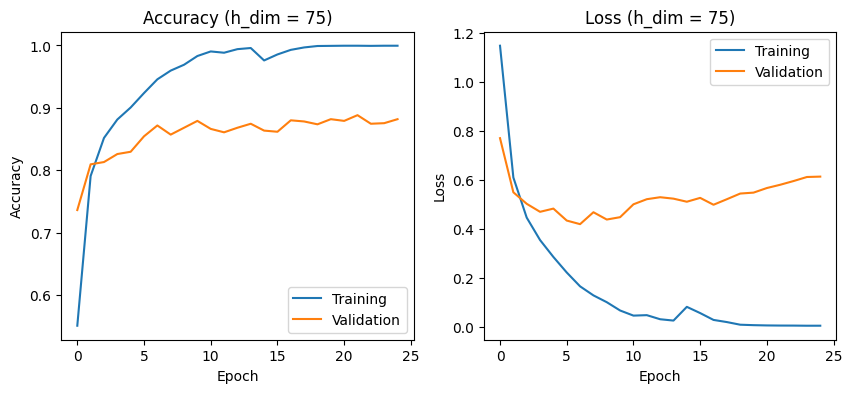

Confusion matrix (training set):


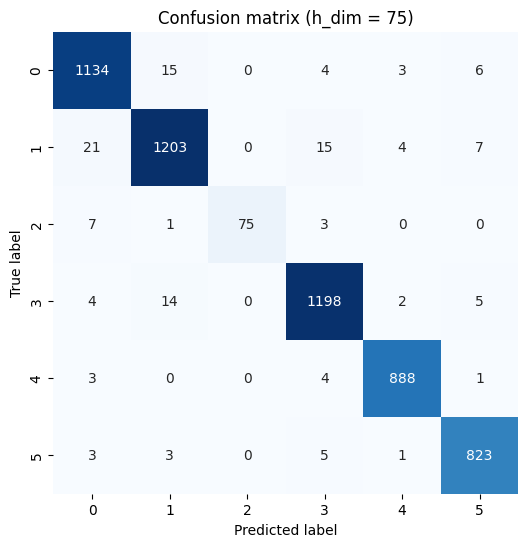

Confusion matrix (test set):


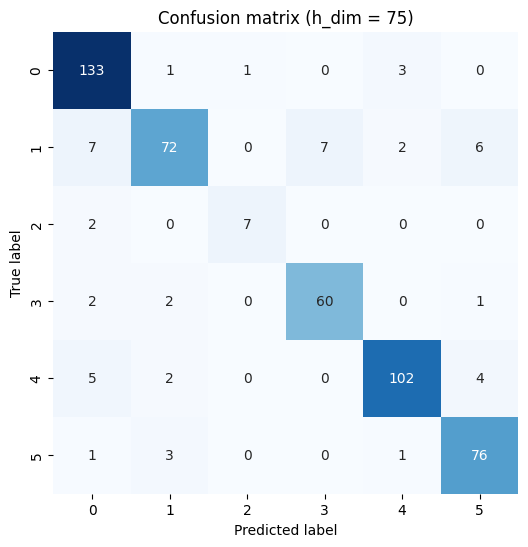



Training model with h_dim = 100
Epoch 1/25
137/137 - 11s - loss: 1.0703 - accuracy: 0.5939 - val_loss: 0.7056 - val_accuracy: 0.7434 - 11s/epoch - 82ms/step
Epoch 2/25
137/137 - 9s - loss: 0.5755 - accuracy: 0.8007 - val_loss: 0.5392 - val_accuracy: 0.8084 - 9s/epoch - 68ms/step
Epoch 3/25
137/137 - 7s - loss: 0.4252 - accuracy: 0.8537 - val_loss: 0.5013 - val_accuracy: 0.8148 - 7s/epoch - 49ms/step
Epoch 4/25
137/137 - 8s - loss: 0.3395 - accuracy: 0.8796 - val_loss: 0.4932 - val_accuracy: 0.8258 - 8s/epoch - 58ms/step
Epoch 5/25
137/137 - 7s - loss: 0.2924 - accuracy: 0.8975 - val_loss: 0.4832 - val_accuracy: 0.8268 - 7s/epoch - 53ms/step
Epoch 6/25
137/137 - 8s - loss: 0.2149 - accuracy: 0.9255 - val_loss: 0.4392 - val_accuracy: 0.8561 - 8s/epoch - 58ms/step
Epoch 7/25
137/137 - 8s - loss: 0.1514 - accuracy: 0.9523 - val_loss: 0.4589 - val_accuracy: 0.8515 - 8s/epoch - 56ms/step
Epoch 8/25
137/137 - 7s - loss: 0.1313 - accuracy: 0.9553 - val_loss: 0.4571 - val_accuracy: 0.8643 - 7

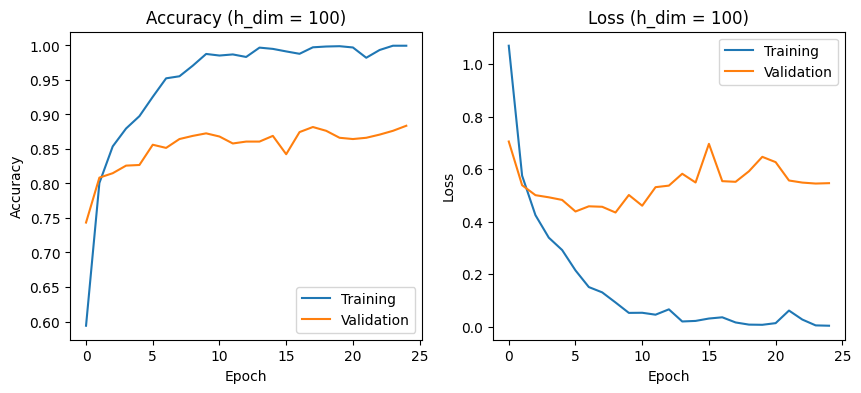

Confusion matrix (training set):


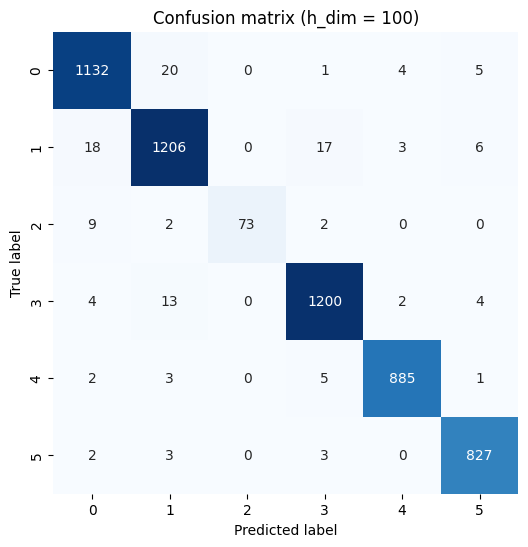

Confusion matrix (test set):


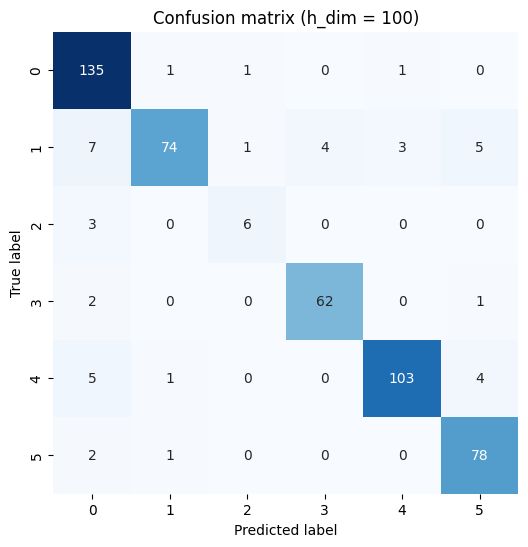

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time

# Function to save plots to PDF
def save_plots_to_pdf(filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy (h_dim = {h_dim})')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss (h_dim = {h_dim})')

        pdf.savefig(bbox_inches='tight')

        # Show the plots in Colab output
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion matrix (h_dim = {h_dim})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot in Colab output
    plt.show()
    plt.close()

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim, num_classes)

    # Split the training set for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    history = model.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_split), verbose=2)
    train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1] * 100
    print(f"Training set accuracy: {train_accuracy:.2f}%")
    print(f"Test set accuracy: {test_accuracy:.2f}%")

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    test_precision = precision_score(y_test, y_pred_test, average='weighted')

    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')

    print(f"Training set F1-score: {train_f1:.2f}")
    print(f"Test set F1-score: {test_f1:.2f}")

    print(f"Training set Precision: {train_precision:.2f}")
    print(f"Test set Precision: {test_precision:.2f}")

    print(f"Training set Recall: {train_recall:.2f}")
    print(f"Test set Recall: {test_recall:.2f}")

    save_plots_to_pdf(f"model_{h_dim}_plots.pdf")

    print("Confusion matrix (training set):")
    save_confusion_matrix_to_pdf(y_train, y_pred_train, f"model_{h_dim}_confusion_matrix_train.pdf")

    print("Confusion matrix (test set):")
    save_confusion_matrix_to_pdf(y_test, y_pred_test, f"model_{h_dim}_confusion_matrix_test.pdf")

    print("\n")

    time.sleep(2)  # Wait for 2 seconds before proceeding to the next h_dim


## **3.2 (Model 2)**

### Method1 (Val = Test, like Paper)

Training model with h_dim = 25
Epoch 1/50
86/86 [==============================] - 4s 18ms/step - loss: 4.9492 - main_output_loss: 1.5376 - sub_output_loss: 3.4116 - main_output_accuracy: 0.3795 - sub_output_accuracy: 0.1361 - val_loss: 4.3800 - val_main_output_loss: 1.2597 - val_sub_output_loss: 3.1203 - val_main_output_accuracy: 0.6300 - val_sub_output_accuracy: 0.1760
Epoch 2/50
86/86 [==============================] - 1s 7ms/step - loss: 3.8638 - main_output_loss: 1.0610 - sub_output_loss: 2.8028 - main_output_accuracy: 0.6163 - sub_output_accuracy: 0.3402 - val_loss: 3.4063 - val_main_output_loss: 0.8207 - val_sub_output_loss: 2.5856 - val_main_output_accuracy: 0.7140 - val_sub_output_accuracy: 0.4700
Epoch 3/50
86/86 [==============================] - 1s 6ms/step - loss: 3.0951 - main_output_loss: 0.7643 - sub_output_loss: 2.3309 - main_output_accuracy: 0.7381 - sub_output_accuracy: 0.4332 - val_loss: 2.8626 - val_main_output_loss: 0.6290 - val_sub_output_loss: 2.2336 - val_main_

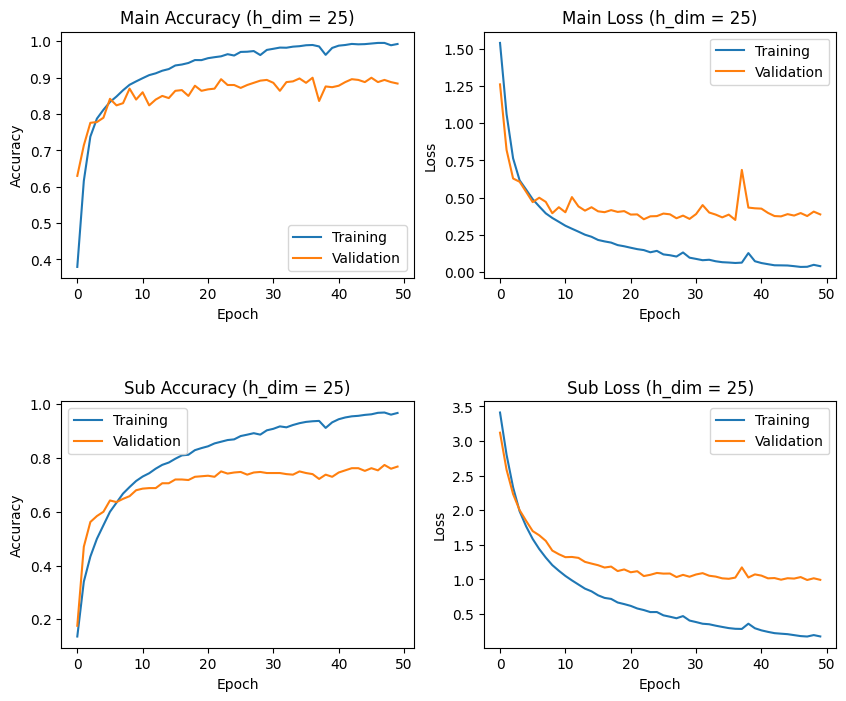

16/16 [==============================] - 0s 2ms/step


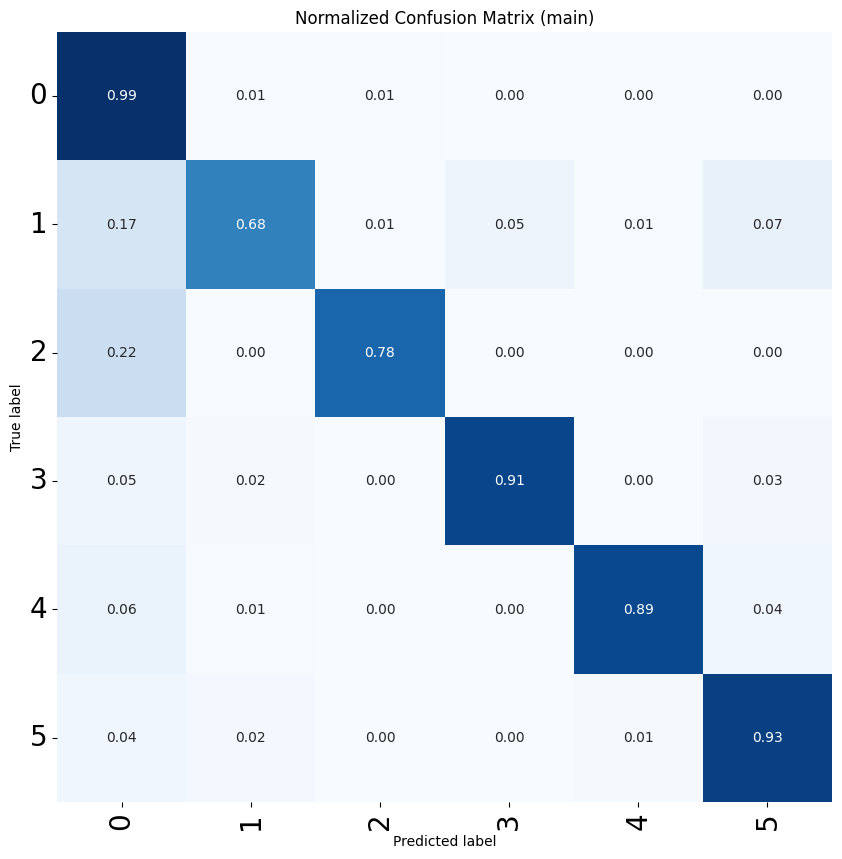

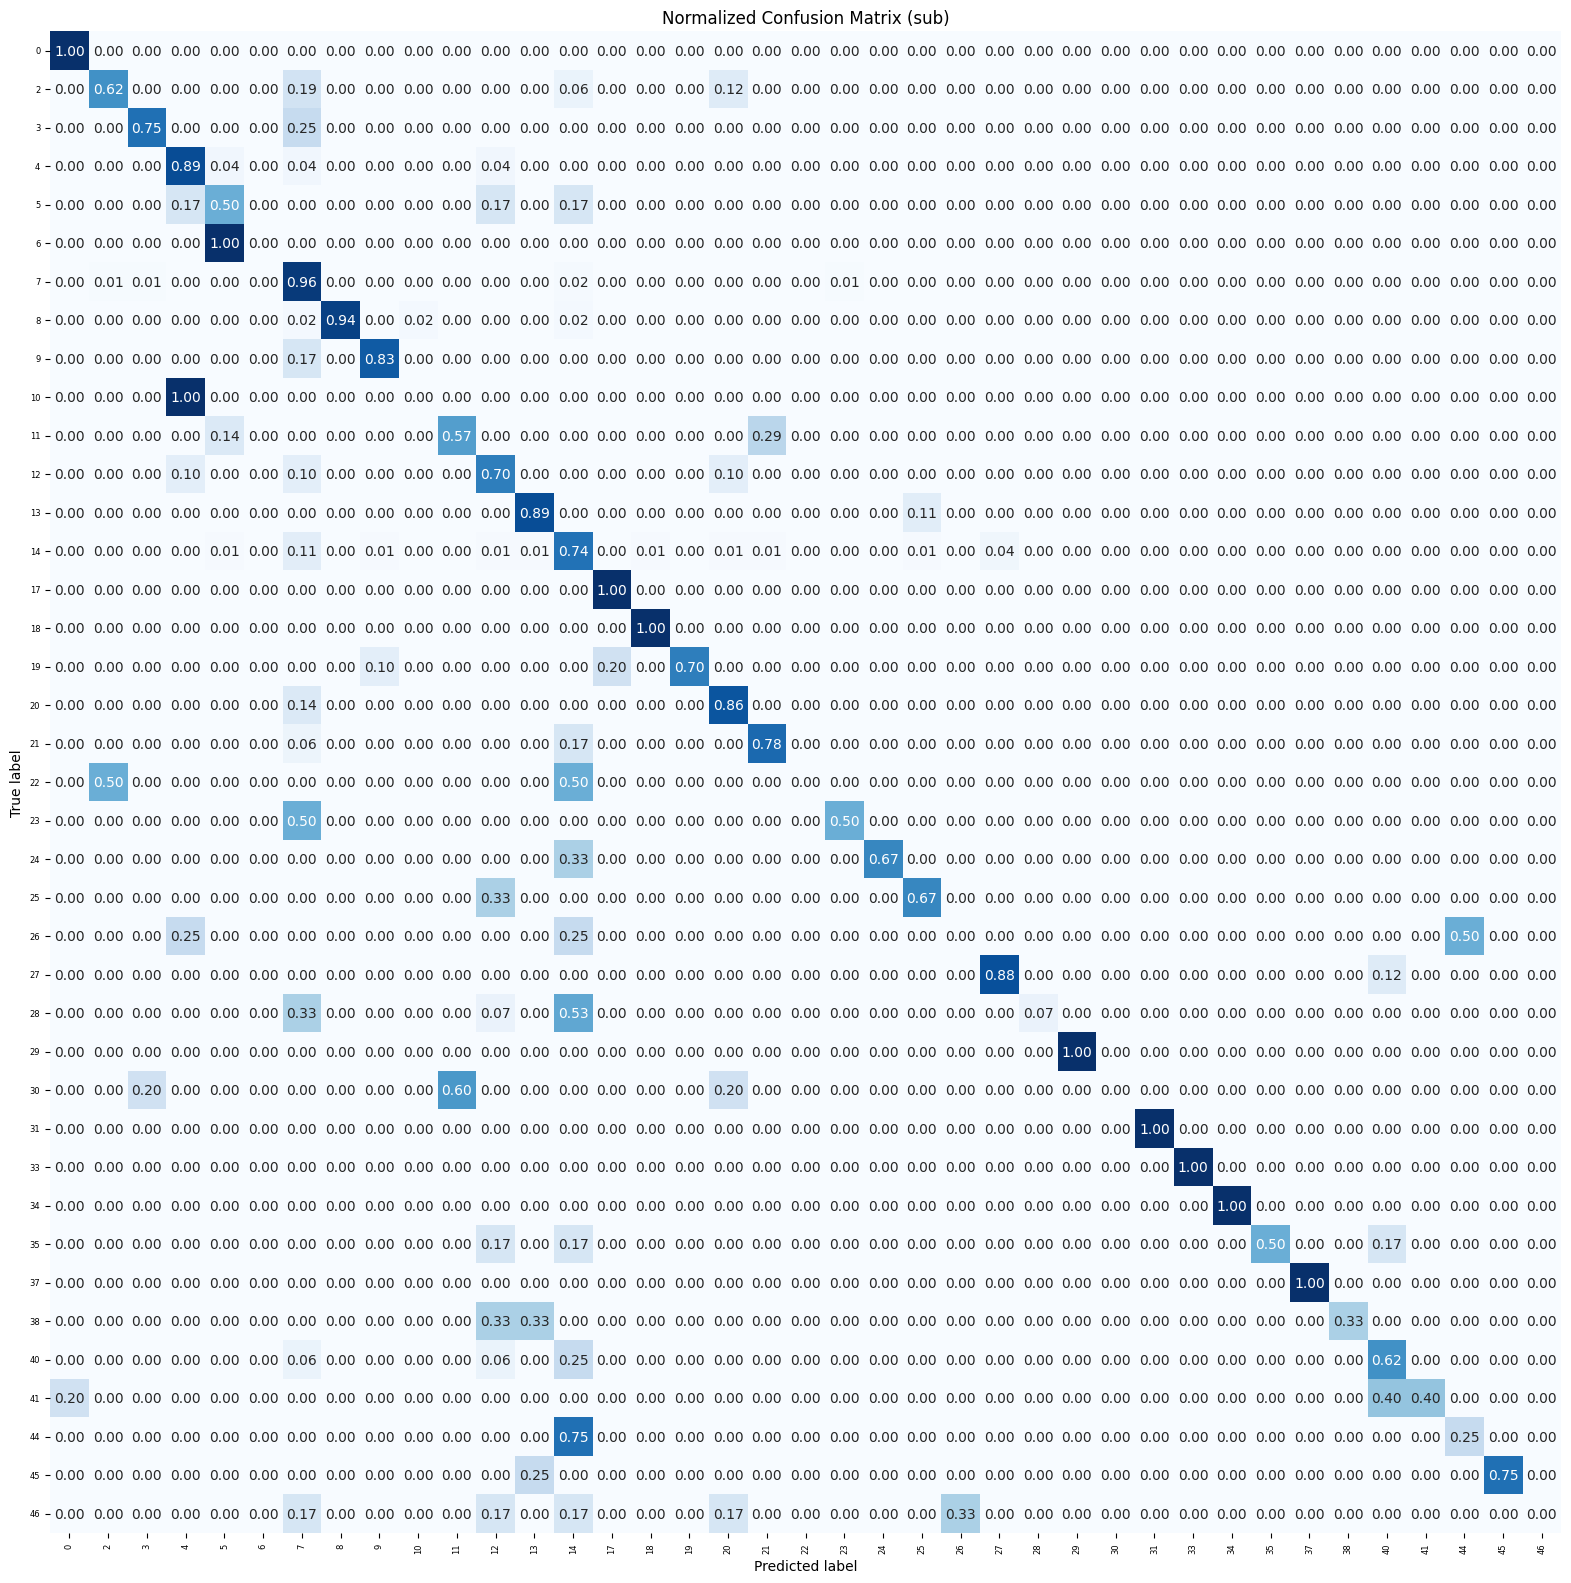

Evaluation metrics (Main):
Accuracy: 0.8840
Precision: 0.8791
Recall: 0.8619
F1-score: 0.8654
Evaluation metrics (Sub):
Accuracy: 0.7680
Precision: 0.6645
Recall: 0.6248
F1-score: 0.6162
Training model with h_dim = 50
Epoch 1/50
86/86 [==============================] - 5s 13ms/step - loss: 4.4424 - main_output_loss: 1.3958 - sub_output_loss: 3.0466 - main_output_accuracy: 0.4453 - sub_output_accuracy: 0.2483 - val_loss: 3.6263 - val_main_output_loss: 1.0236 - val_sub_output_loss: 2.6027 - val_main_output_accuracy: 0.6380 - val_sub_output_accuracy: 0.4760
Epoch 2/50
86/86 [==============================] - 1s 7ms/step - loss: 3.0697 - main_output_loss: 0.8307 - sub_output_loss: 2.2390 - main_output_accuracy: 0.7045 - sub_output_accuracy: 0.4483 - val_loss: 2.7713 - val_main_output_loss: 0.6679 - val_sub_output_loss: 2.1035 - val_main_output_accuracy: 0.7760 - val_sub_output_accuracy: 0.5300
Epoch 3/50
86/86 [==============================] - 1s 7ms/step - loss: 2.3986 - main_output_loss

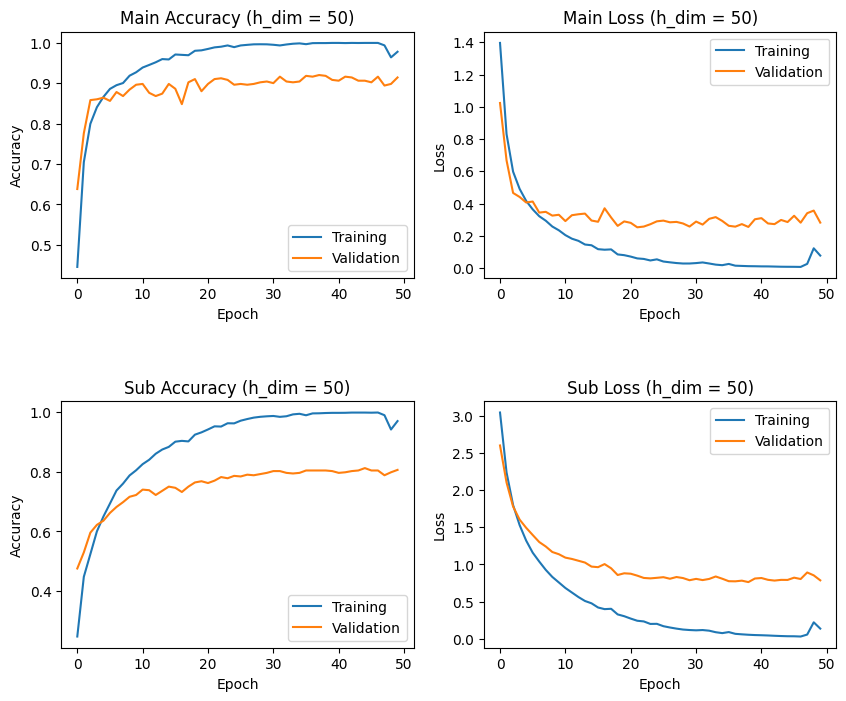

16/16 [==============================] - 0s 3ms/step


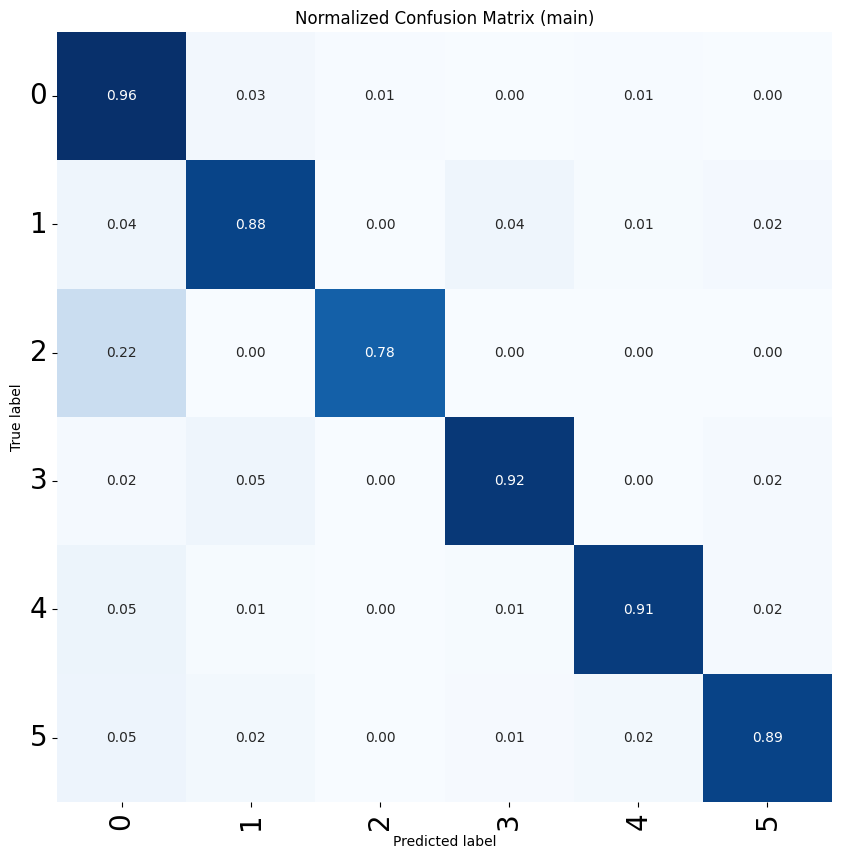

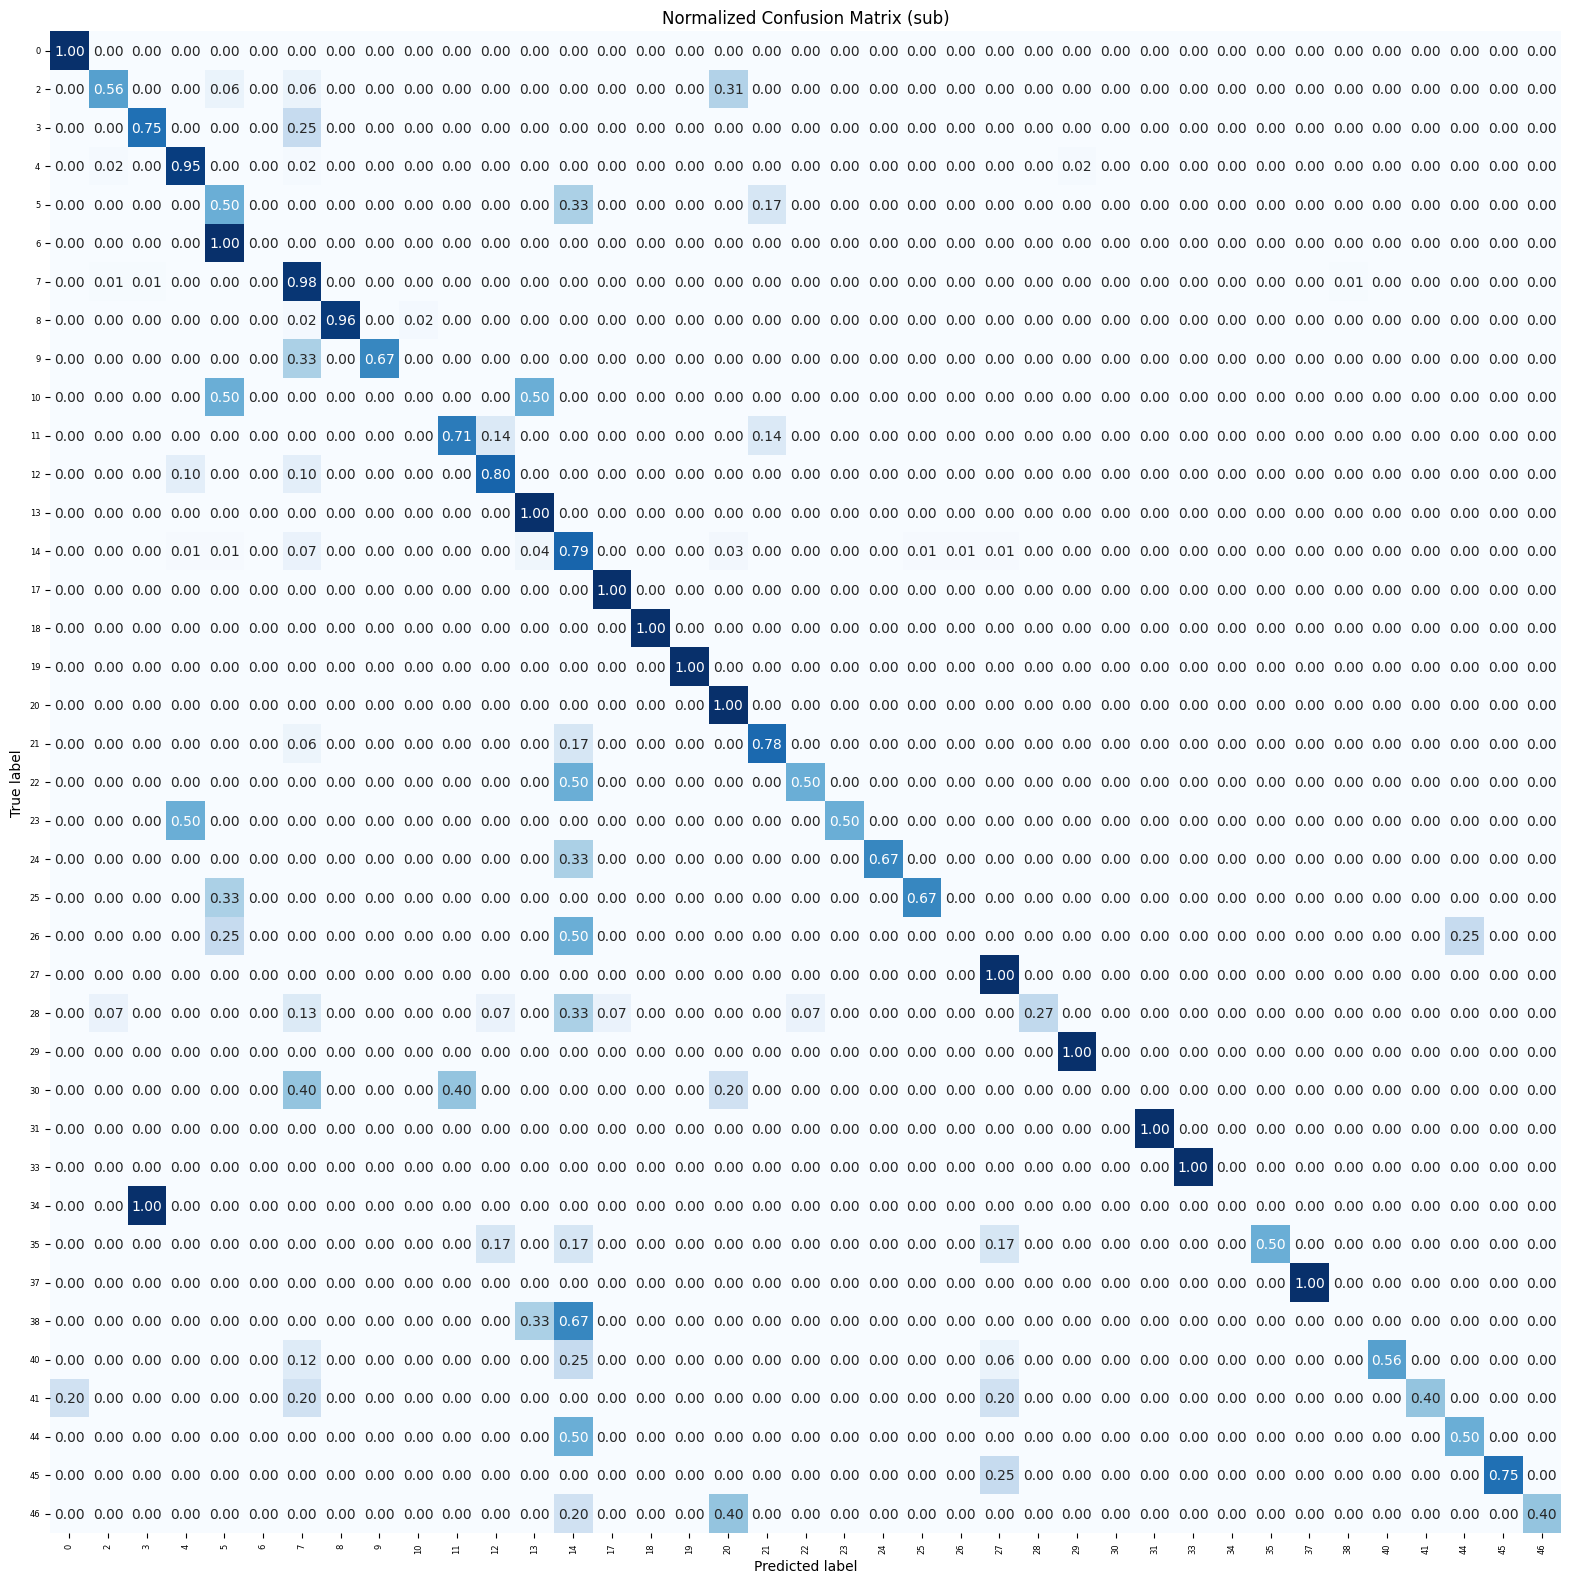

Evaluation metrics (Main):
Accuracy: 0.9140
Precision: 0.9100
Recall: 0.8901
F1-score: 0.8991
Evaluation metrics (Sub):
Accuracy: 0.8060
Precision: 0.6616
Recall: 0.6117
F1-score: 0.6072
Training model with h_dim = 75
Epoch 1/50
86/86 [==============================] - 4s 19ms/step - loss: 4.2196 - main_output_loss: 1.2944 - sub_output_loss: 2.9252 - main_output_accuracy: 0.4872 - sub_output_accuracy: 0.2819 - val_loss: 3.1437 - val_main_output_loss: 0.8079 - val_sub_output_loss: 2.3358 - val_main_output_accuracy: 0.7540 - val_sub_output_accuracy: 0.5080
Epoch 2/50
86/86 [==============================] - 1s 10ms/step - loss: 2.6883 - main_output_loss: 0.7203 - sub_output_loss: 1.9680 - main_output_accuracy: 0.7397 - sub_output_accuracy: 0.4956 - val_loss: 2.4301 - val_main_output_loss: 0.6041 - val_sub_output_loss: 1.8260 - val_main_output_accuracy: 0.7740 - val_sub_output_accuracy: 0.5740
Epoch 3/50
86/86 [==============================] - 1s 8ms/step - loss: 2.0633 - main_output_los

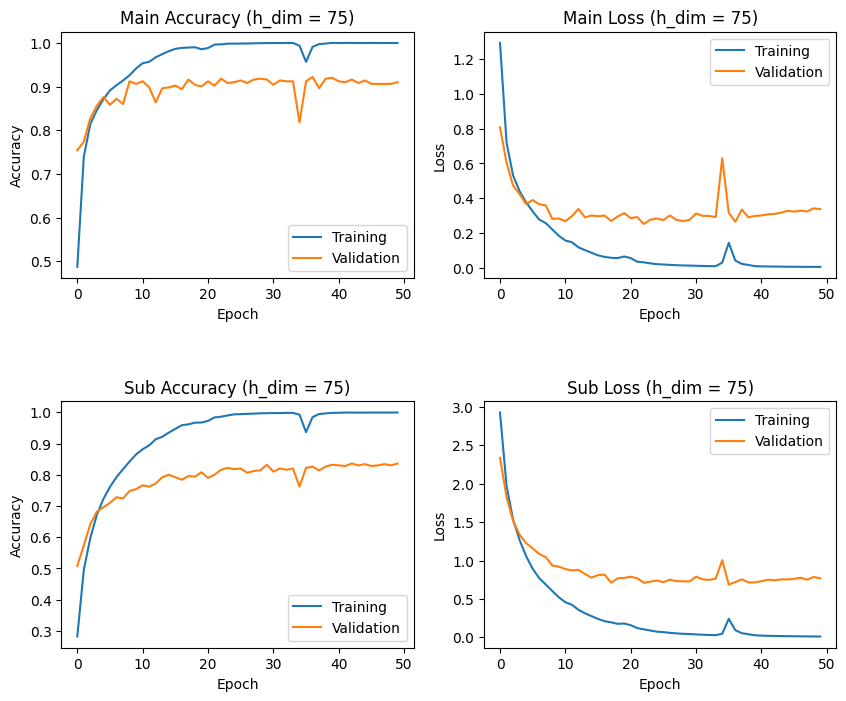

16/16 [==============================] - 0s 3ms/step


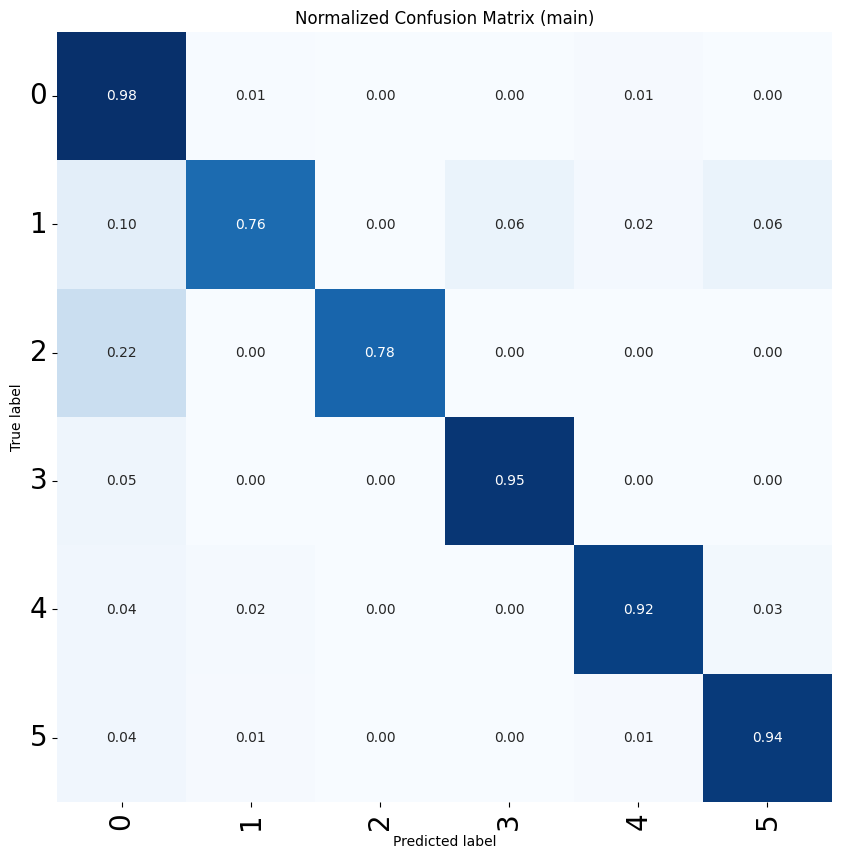

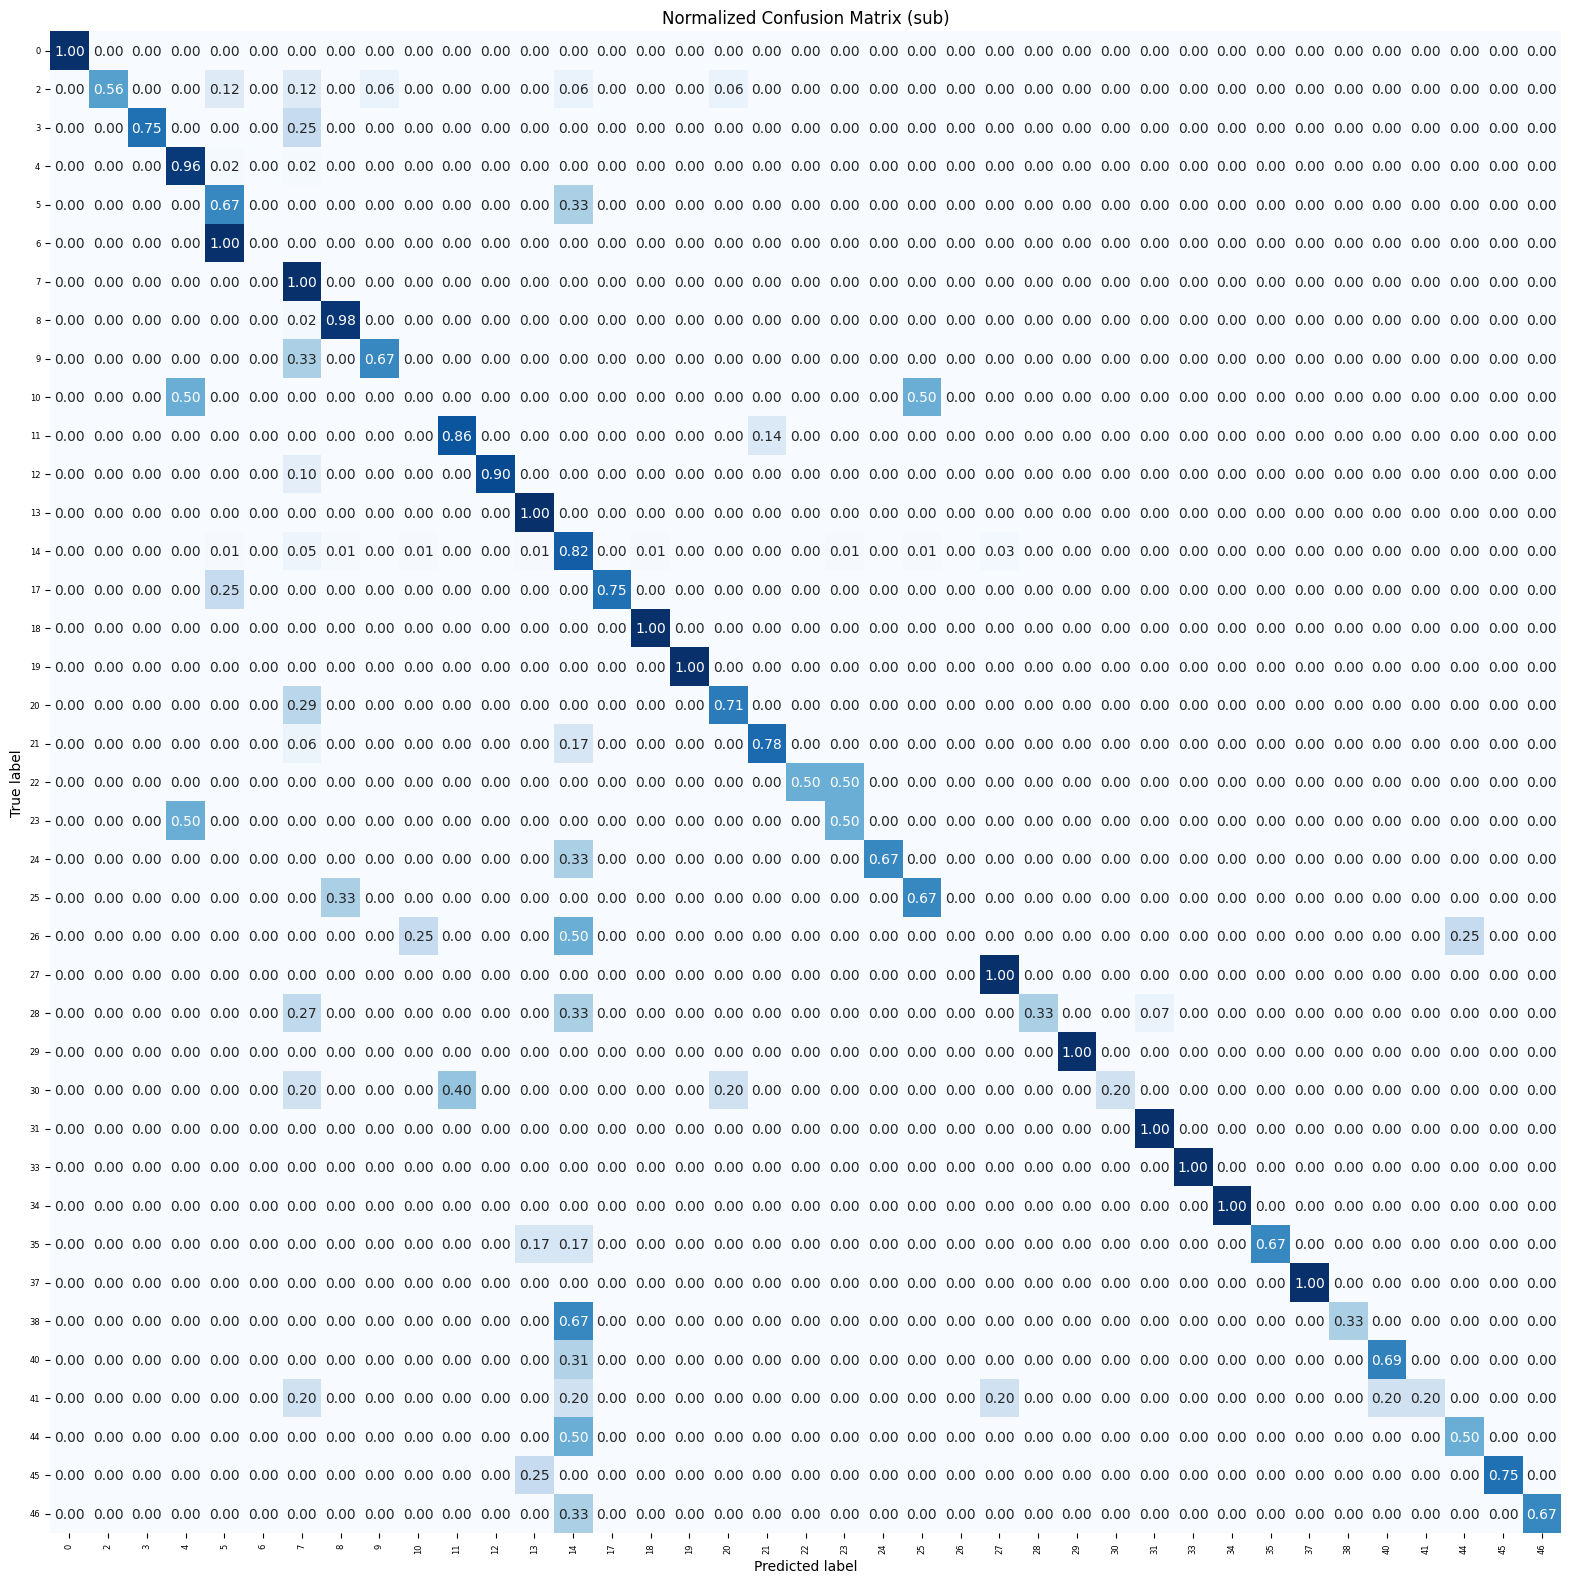

Evaluation metrics (Main):
Accuracy: 0.9100
Precision: 0.9287
Recall: 0.8873
F1-score: 0.9031
Evaluation metrics (Sub):
Accuracy: 0.8360
Precision: 0.7801
Recall: 0.6765
F1-score: 0.6926
Training model with h_dim = 100
Epoch 1/50
86/86 [==============================] - 4s 14ms/step - loss: 4.0669 - main_output_loss: 1.2644 - sub_output_loss: 2.8025 - main_output_accuracy: 0.4941 - sub_output_accuracy: 0.3076 - val_loss: 3.2257 - val_main_output_loss: 0.9328 - val_sub_output_loss: 2.2929 - val_main_output_accuracy: 0.6720 - val_sub_output_accuracy: 0.5120
Epoch 2/50
86/86 [==============================] - 1s 7ms/step - loss: 2.4748 - main_output_loss: 0.6674 - sub_output_loss: 1.8074 - main_output_accuracy: 0.7577 - sub_output_accuracy: 0.5293 - val_loss: 2.2716 - val_main_output_loss: 0.5490 - val_sub_output_loss: 1.7226 - val_main_output_accuracy: 0.8320 - val_sub_output_accuracy: 0.5940
Epoch 3/50
86/86 [==============================] - 1s 8ms/step - loss: 1.8436 - main_output_los

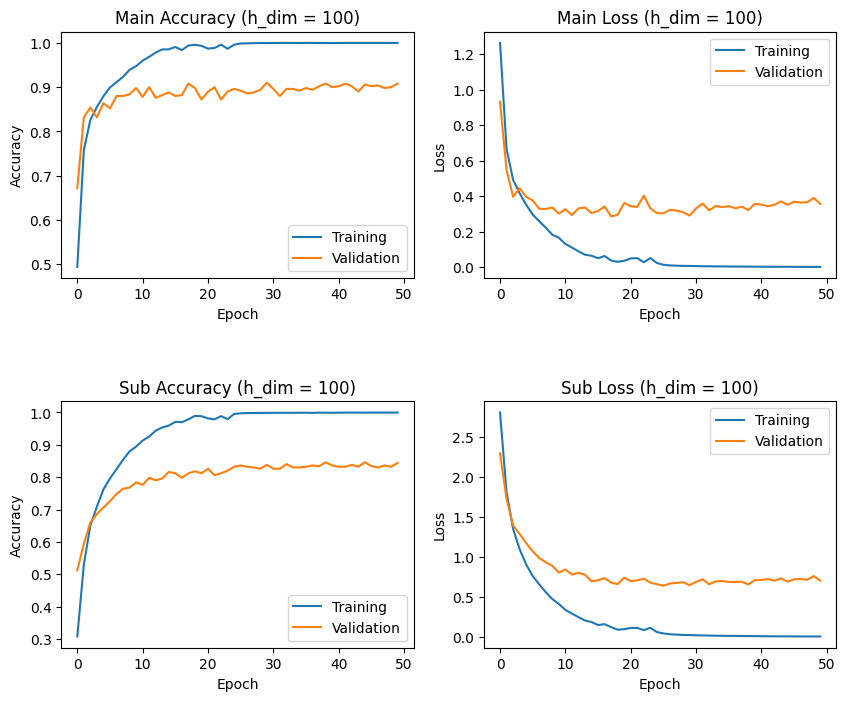

16/16 [==============================] - 0s 3ms/step


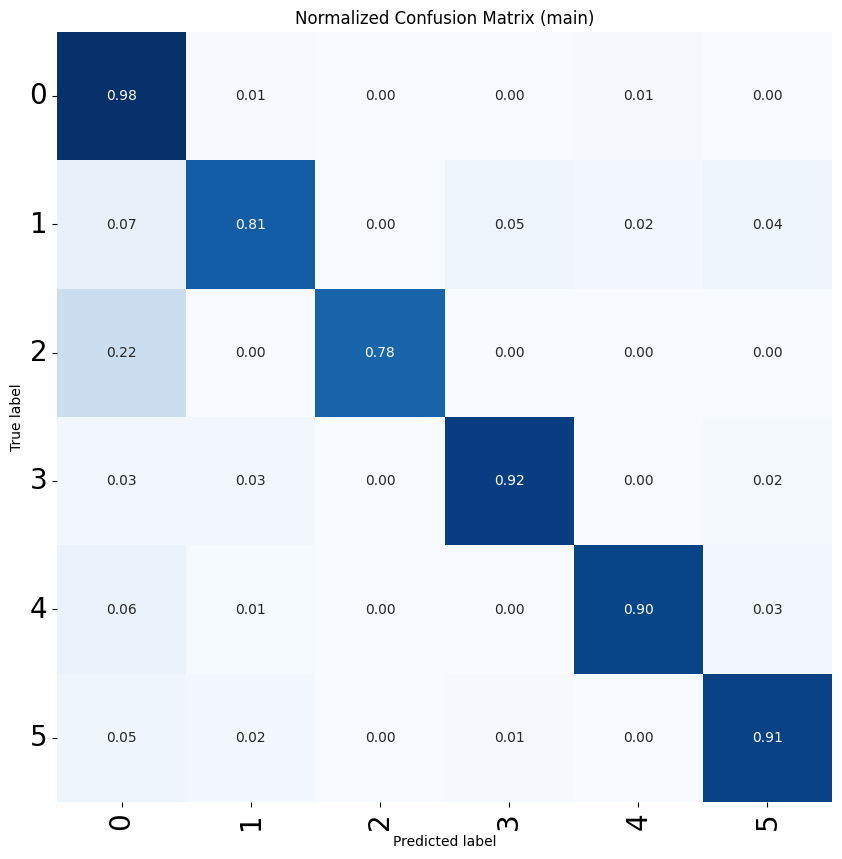

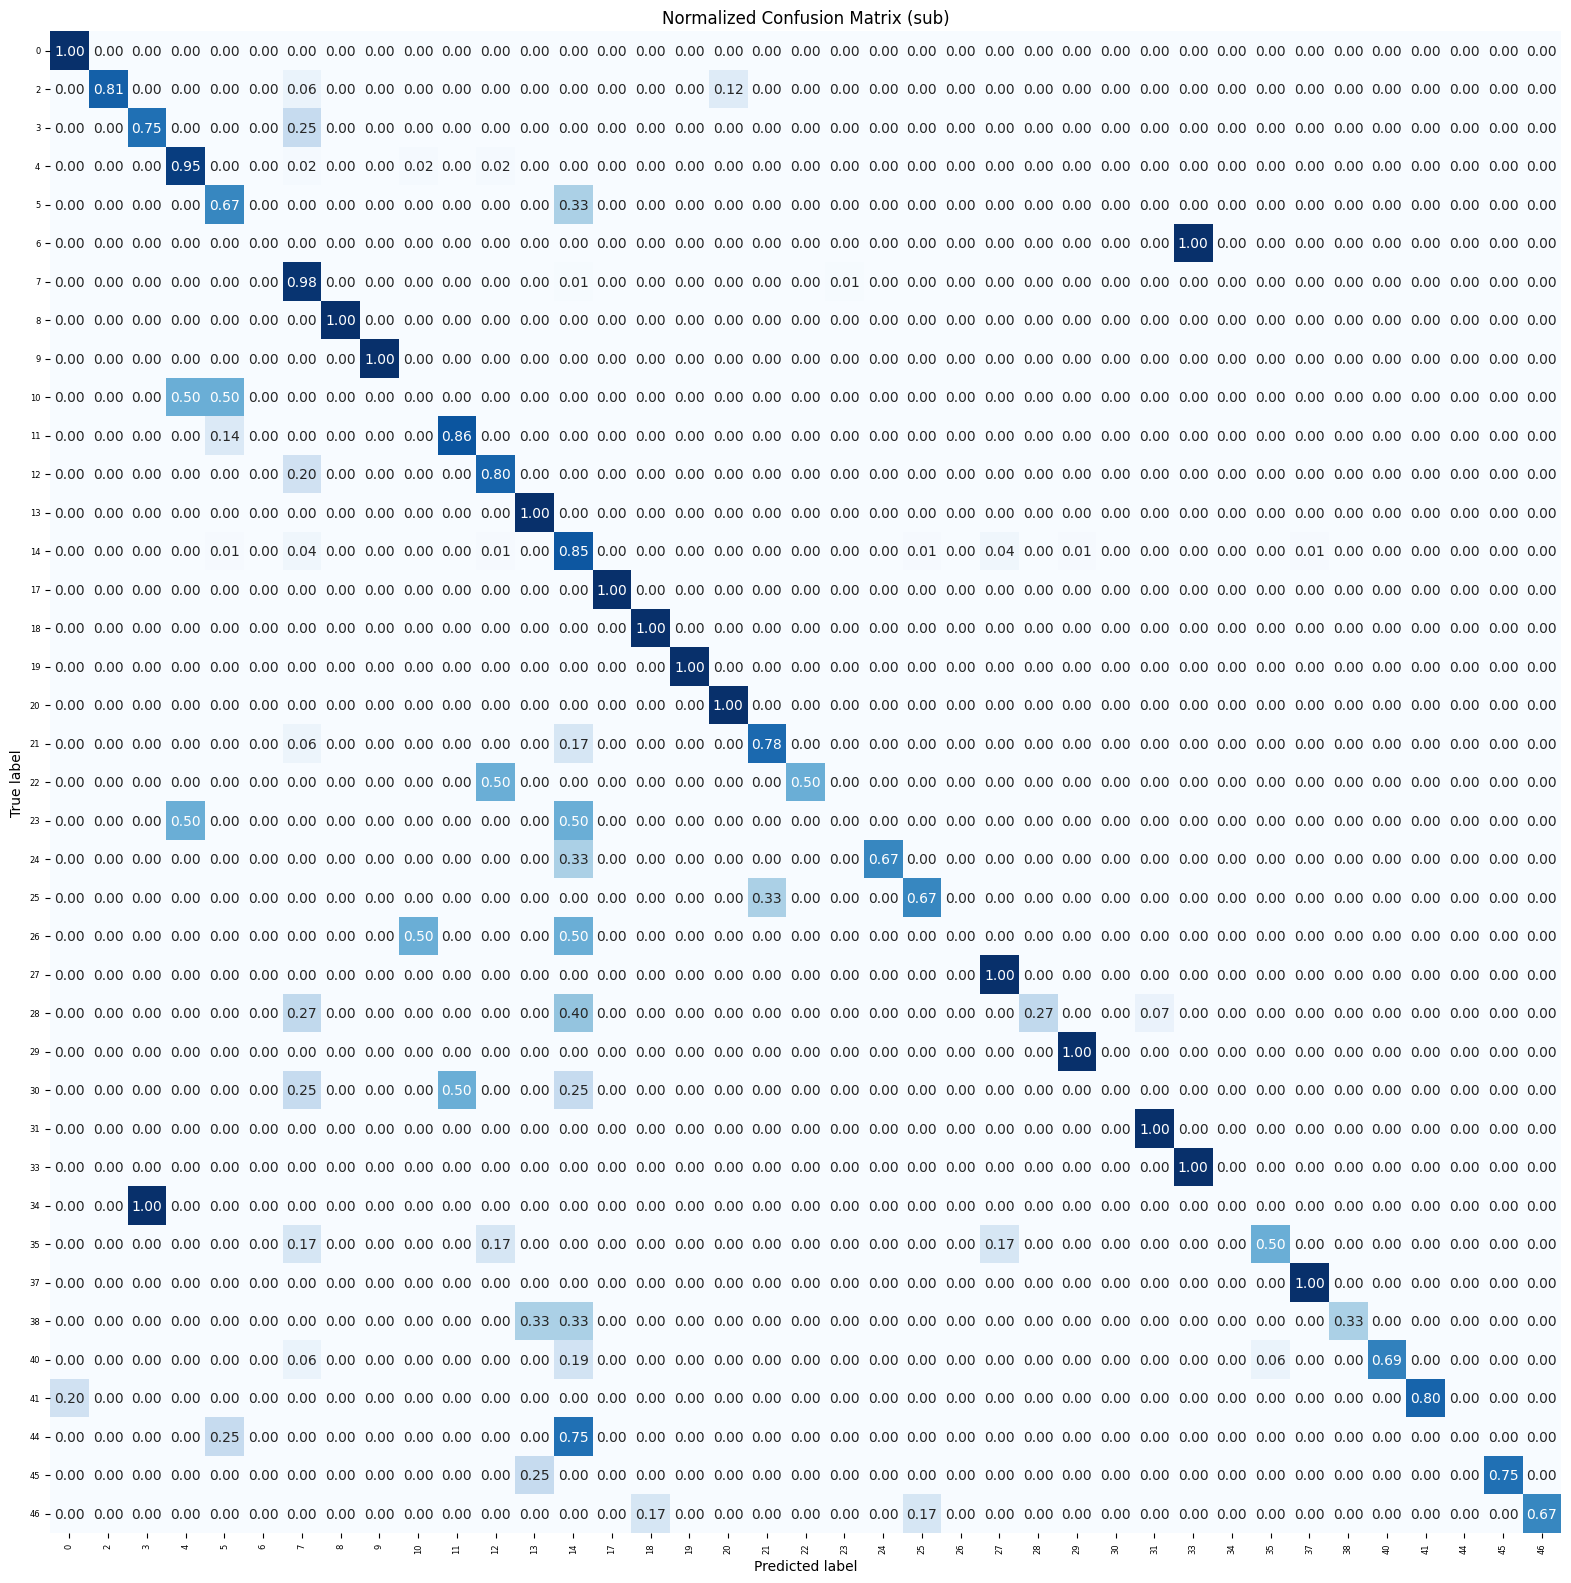

Evaluation metrics (Main):
Accuracy: 0.9080
Precision: 0.9267
Recall: 0.8840
F1-score: 0.9016
Evaluation metrics (Sub):
Accuracy: 0.8440
Precision: 0.6592
Recall: 0.6565
F1-score: 0.6312


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import warnings
from tensorflow.keras.utils import to_categorical

# Ignore all warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 50
batch_size = 64

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    lstm_layer = LSTM(h_dim, activation='tanh', return_sequences=True, return_state=True)
    lstm_outputs, state_h, state_c = lstm_layer(embedding_layer)
    main_output = Dense(len(encoder_main.classes_), activation='softmax', name='main_output')(state_h)
    sub_output = Dense(len(encoder_sub.classes_), activation='softmax', name='sub_output')(lstm_outputs[:, -1, :])
    model = Model(inputs=input_layer, outputs=[main_output, sub_output])
    model.compile(optimizer=Adam(learning_rate=0.001), loss={'main_output': 'sparse_categorical_crossentropy', 'sub_output': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename, history, h_dim):
    with PdfPages(filename) as pdf:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        axs[0, 0].plot(history.history['main_output_accuracy'], label='Training')
        axs[0, 0].plot(history.history['val_main_output_accuracy'], label='Validation')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()
        axs[0, 0].set_title(f'Main Accuracy (h_dim = {h_dim})')

        axs[0, 1].plot(history.history['main_output_loss'], label='Training')
        axs[0, 1].plot(history.history['val_main_output_loss'], label='Validation')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()
        axs[0, 1].set_title(f'Main Loss (h_dim = {h_dim})')

        axs[1, 0].plot(history.history['sub_output_accuracy'], label='Training')
        axs[1, 0].plot(history.history['val_sub_output_accuracy'], label='Validation')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()
        axs[1, 0].set_title(f'Sub Accuracy (h_dim = {h_dim})')

        axs[1, 1].plot(history.history['sub_output_loss'], label='Training')
        axs[1, 1].plot(history.history['val_sub_output_loss'], label='Validation')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].legend()
        axs[1, 1].set_title(f'Sub Loss (h_dim = {h_dim})')

        plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

        pdf.savefig(bbox_inches='tight')

        # Show the plots
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename, label_type):
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    # Calculate the appropriate figure size based on the number of classes
    figsize = max(10, num_classes / 2)

    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)

    # Adjust the font size of the numbers inside the heatmap
    annot_fontsize = max(6, 120 // num_classes)
    plt.tick_params(axis='both', labelsize=annot_fontsize)

    # Map the class indices to their corresponding labels
    class_labels = encoder_sub.inverse_transform(unique_classes)

    plt.xticks(np.arange(num_classes) + 0.5, class_labels, rotation='vertical')
    plt.yticks(np.arange(num_classes) + 0.5, class_labels, rotation='horizontal')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Normalized Confusion Matrix ({label_type})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()

# Function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, label_type):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Evaluation metrics ({label_type}):')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert tokens to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
maxlen = max(len(seq) for seq in train_sequences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=maxlen)
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Encode main labels
encoder_main = LabelEncoder()
encoder_main.fit(train_data['label-coarse'])
train_encoded_main_labels = encoder_main.transform(train_data['label-coarse'])
test_encoded_main_labels = encoder_main.transform(test_data['label-coarse'])

# Encode sub labels
encoder_sub = LabelEncoder()
encoder_sub.fit(train_data['label-fine'])
train_encoded_sub_labels = encoder_sub.transform(train_data['label-fine'])
test_encoded_sub_labels = encoder_sub.transform(test_data['label-fine'])

# Convert main labels to one-hot vectors
y_main_train = to_categorical(train_encoded_main_labels)
y_main_test = to_categorical(test_encoded_main_labels)

# Convert sub labels to one-hot vectors
y_sub_train = to_categorical(train_encoded_sub_labels)
y_sub_test = to_categorical(test_encoded_sub_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim)

    # Fit the model
    history = model.fit(
        train_padded_sequences,
        {'main_output': train_encoded_main_labels, 'sub_output': train_encoded_sub_labels},
        validation_data=(test_padded_sequences, {'main_output': test_encoded_main_labels, 'sub_output': test_encoded_sub_labels}),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save plots and confusion matrices
    timestamp = str(int(time.time()))
    save_plots_to_pdf(f'plots_{h_dim}_{timestamp}.pdf', history, h_dim)

    # Only plot confusion matrices for the test data
    main_output_predictions, sub_output_predictions = model.predict(test_padded_sequences)
    main_output_predictions = np.argmax(main_output_predictions, axis=1)
    sub_output_predictions = np.argmax(sub_output_predictions, axis=1)

    save_confusion_matrix_to_pdf(
        test_encoded_main_labels,
        main_output_predictions,
        f'confusion_matrix_test_main_{h_dim}_{timestamp}.pdf',
        'main'
    )
    save_confusion_matrix_to_pdf(
        test_encoded_sub_labels,
        sub_output_predictions,
        f'confusion_matrix_test_sub_{h_dim}_{timestamp}.pdf',
        'sub'
    )

    print_evaluation_metrics(test_encoded_main_labels, main_output_predictions, 'Main')
    print_evaluation_metrics(test_encoded_sub_labels, sub_output_predictions, 'Sub')


### Method1 (Val = Test, like Paper) + L2Norm

Training model with h_dim = 25
Epoch 1/100
171/171 [==============================] - 5s 10ms/step - loss: 4.5569 - main_output_loss: 1.3762 - sub_output_loss: 3.1372 - main_output_accuracy: 0.4512 - sub_output_accuracy: 0.2390 - val_loss: 3.7882 - val_main_output_loss: 0.9781 - val_sub_output_loss: 2.7631 - val_main_output_accuracy: 0.6460 - val_sub_output_accuracy: 0.4500
Epoch 2/100
171/171 [==============================] - 1s 6ms/step - loss: 3.3234 - main_output_loss: 0.8687 - sub_output_loss: 2.4047 - main_output_accuracy: 0.6889 - sub_output_accuracy: 0.4032 - val_loss: 3.1329 - val_main_output_loss: 0.7549 - val_sub_output_loss: 2.3248 - val_main_output_accuracy: 0.7280 - val_sub_output_accuracy: 0.5020
Epoch 3/100
171/171 [==============================] - 1s 6ms/step - loss: 2.7530 - main_output_loss: 0.6683 - sub_output_loss: 2.0279 - main_output_accuracy: 0.7704 - sub_output_accuracy: 0.4864 - val_loss: 2.6484 - val_main_output_loss: 0.5946 - val_sub_output_loss: 1.9934 - 

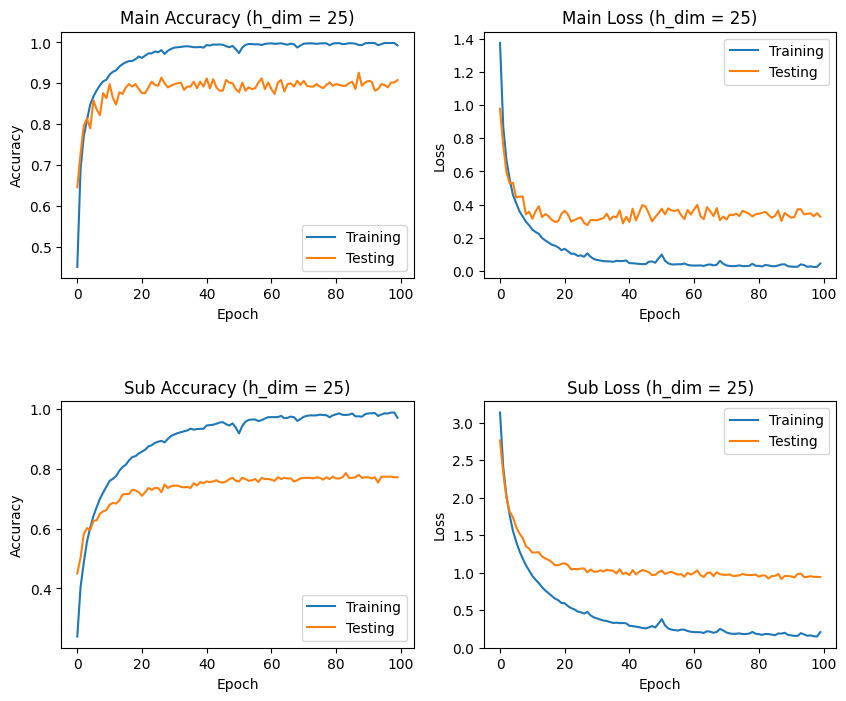

16/16 [==============================] - 0s 3ms/step


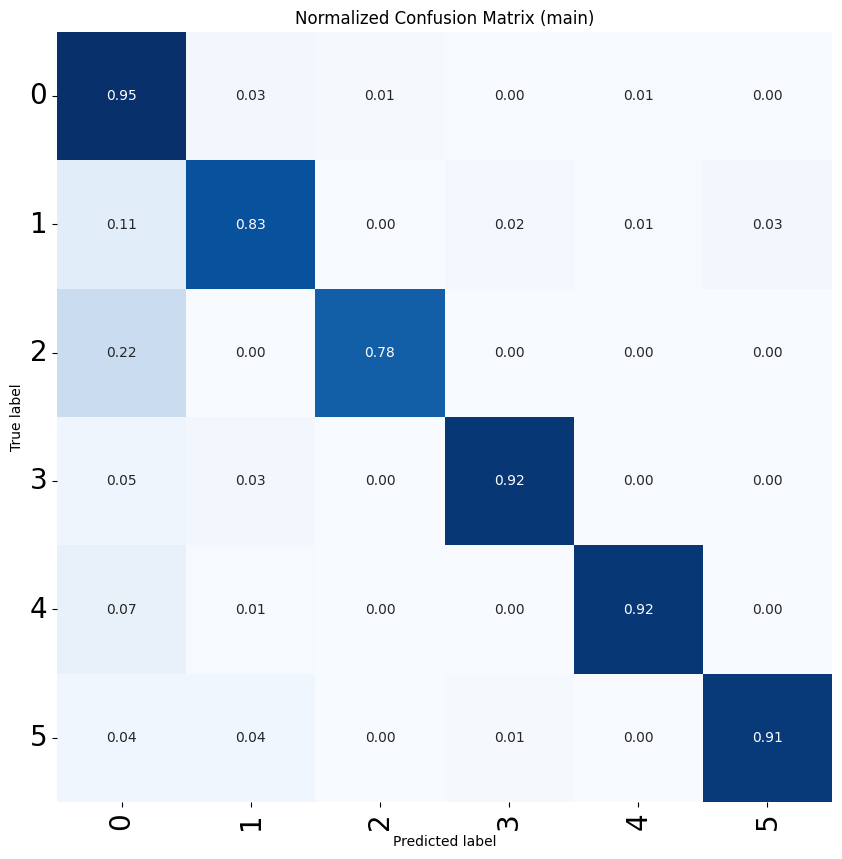

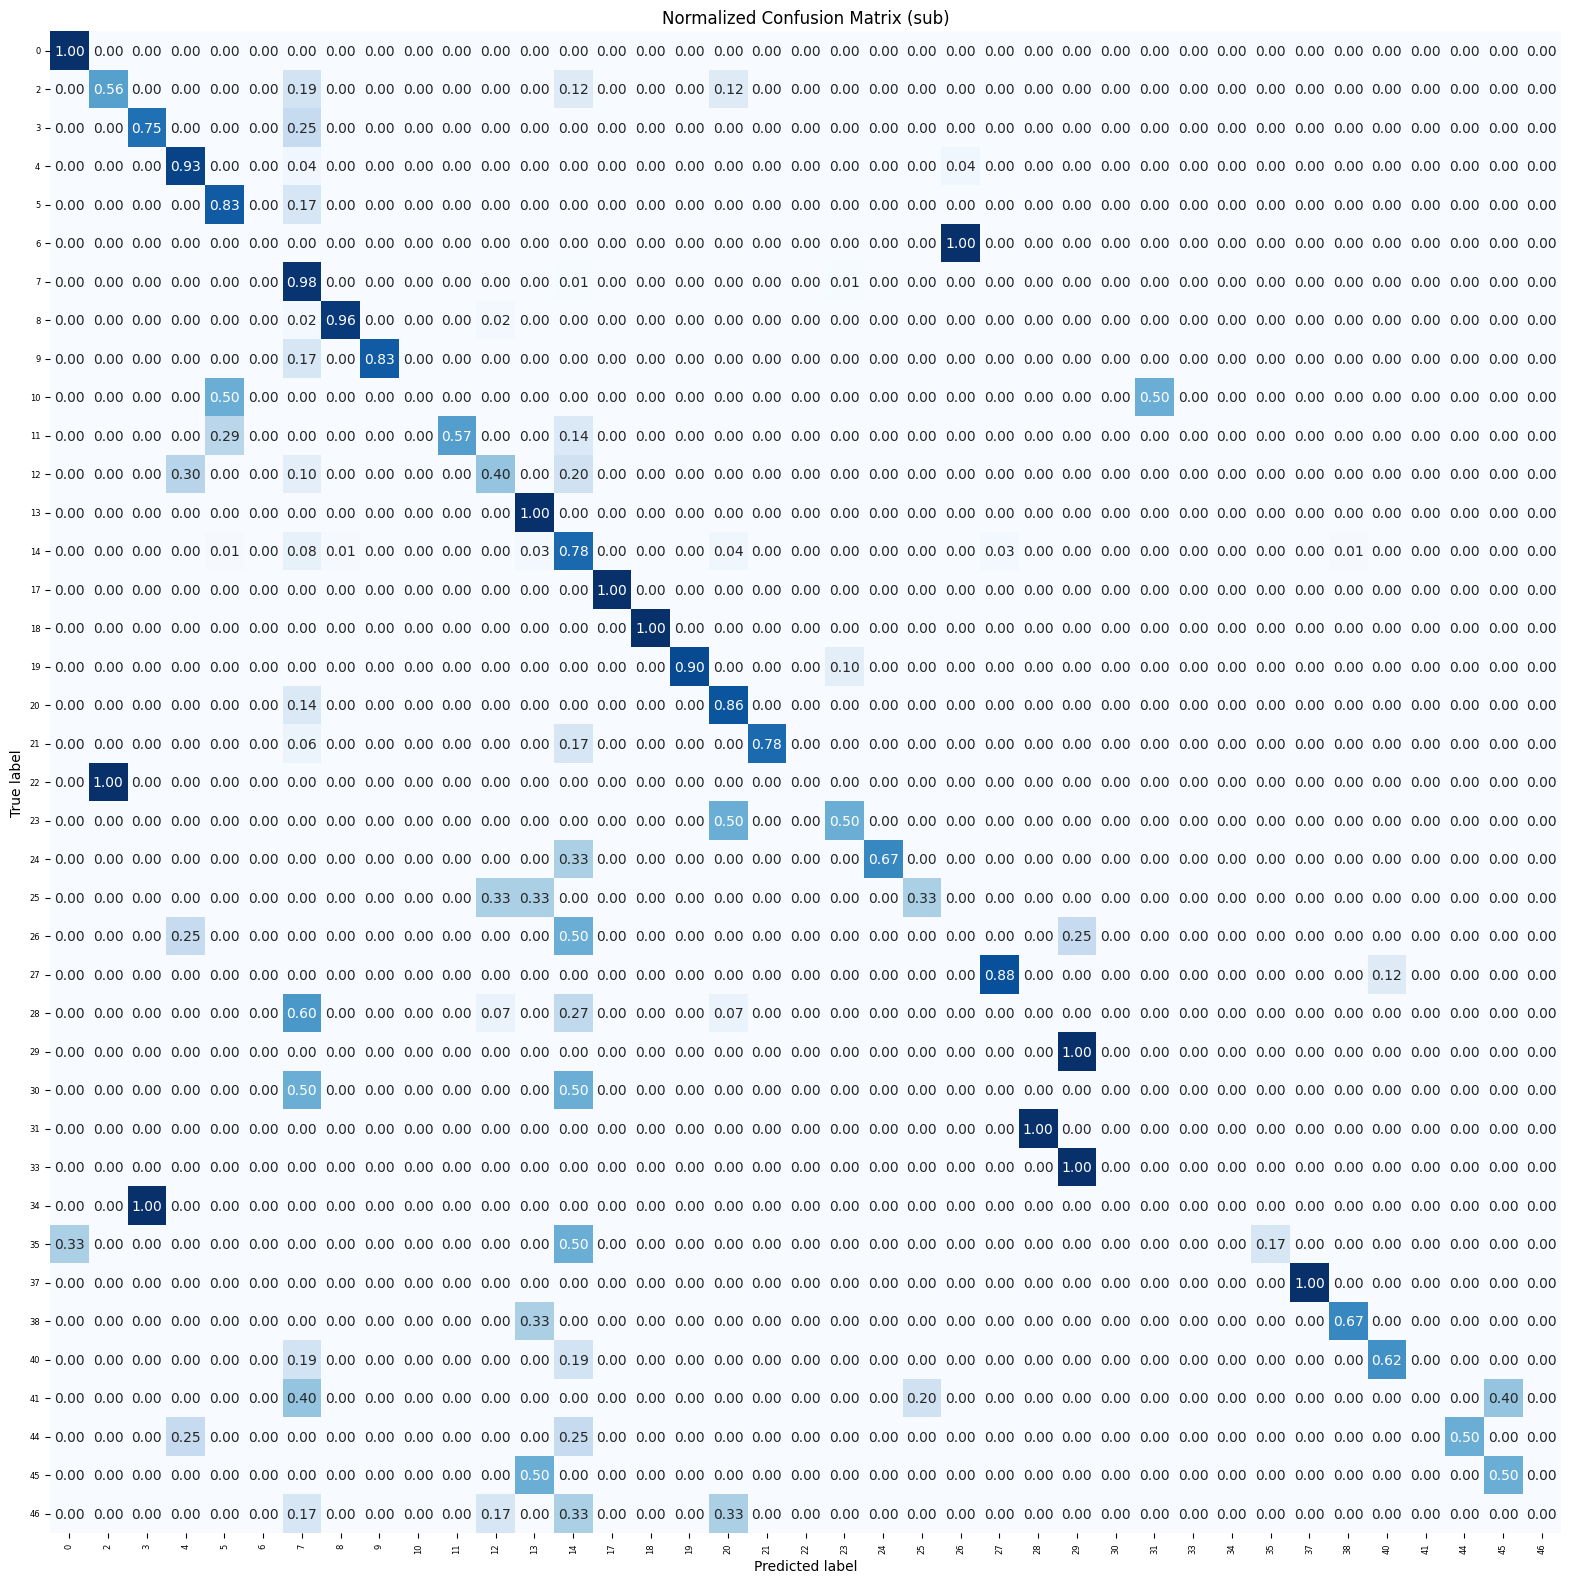

Evaluation metrics (Main):
Accuracy: 0.9080
Precision: 0.8988
Recall: 0.8856
F1-score: 0.8912
Evaluation metrics (Sub):
Accuracy: 0.7720
Precision: 0.5398
Recall: 0.5243
F1-score: 0.5066
Training model with h_dim = 50
Epoch 1/100
171/171 [==============================] - 5s 10ms/step - loss: 4.0961 - main_output_loss: 1.2313 - sub_output_loss: 2.8056 - main_output_accuracy: 0.5270 - sub_output_accuracy: 0.3204 - val_loss: 3.1657 - val_main_output_loss: 0.7486 - val_sub_output_loss: 2.3550 - val_main_output_accuracy: 0.7460 - val_sub_output_accuracy: 0.5080
Epoch 2/100
171/171 [==============================] - 1s 7ms/step - loss: 2.6324 - main_output_loss: 0.6647 - sub_output_loss: 1.9020 - main_output_accuracy: 0.7639 - sub_output_accuracy: 0.5138 - val_loss: 2.4511 - val_main_output_loss: 0.5739 - val_sub_output_loss: 1.8079 - val_main_output_accuracy: 0.7820 - val_sub_output_accuracy: 0.5760
Epoch 3/100
171/171 [==============================] - 1s 7ms/step - loss: 2.0751 - main_ou

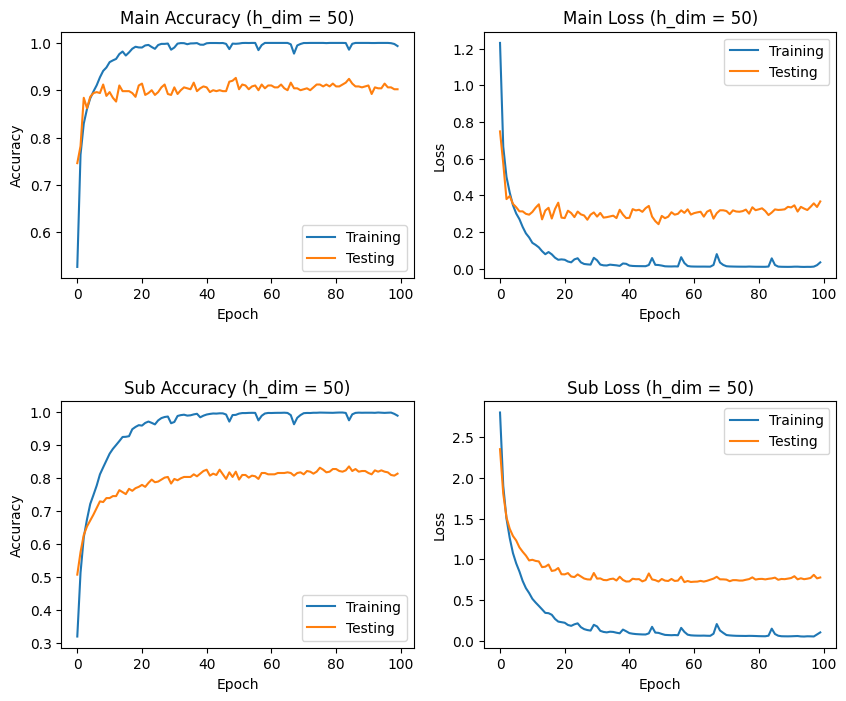

16/16 [==============================] - 0s 3ms/step


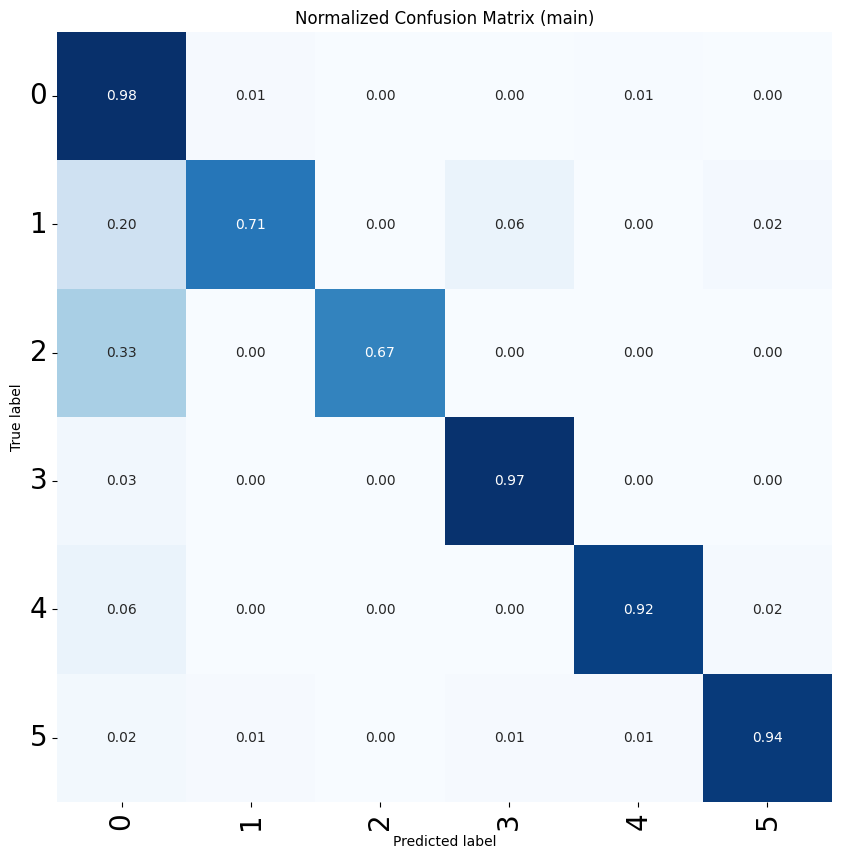

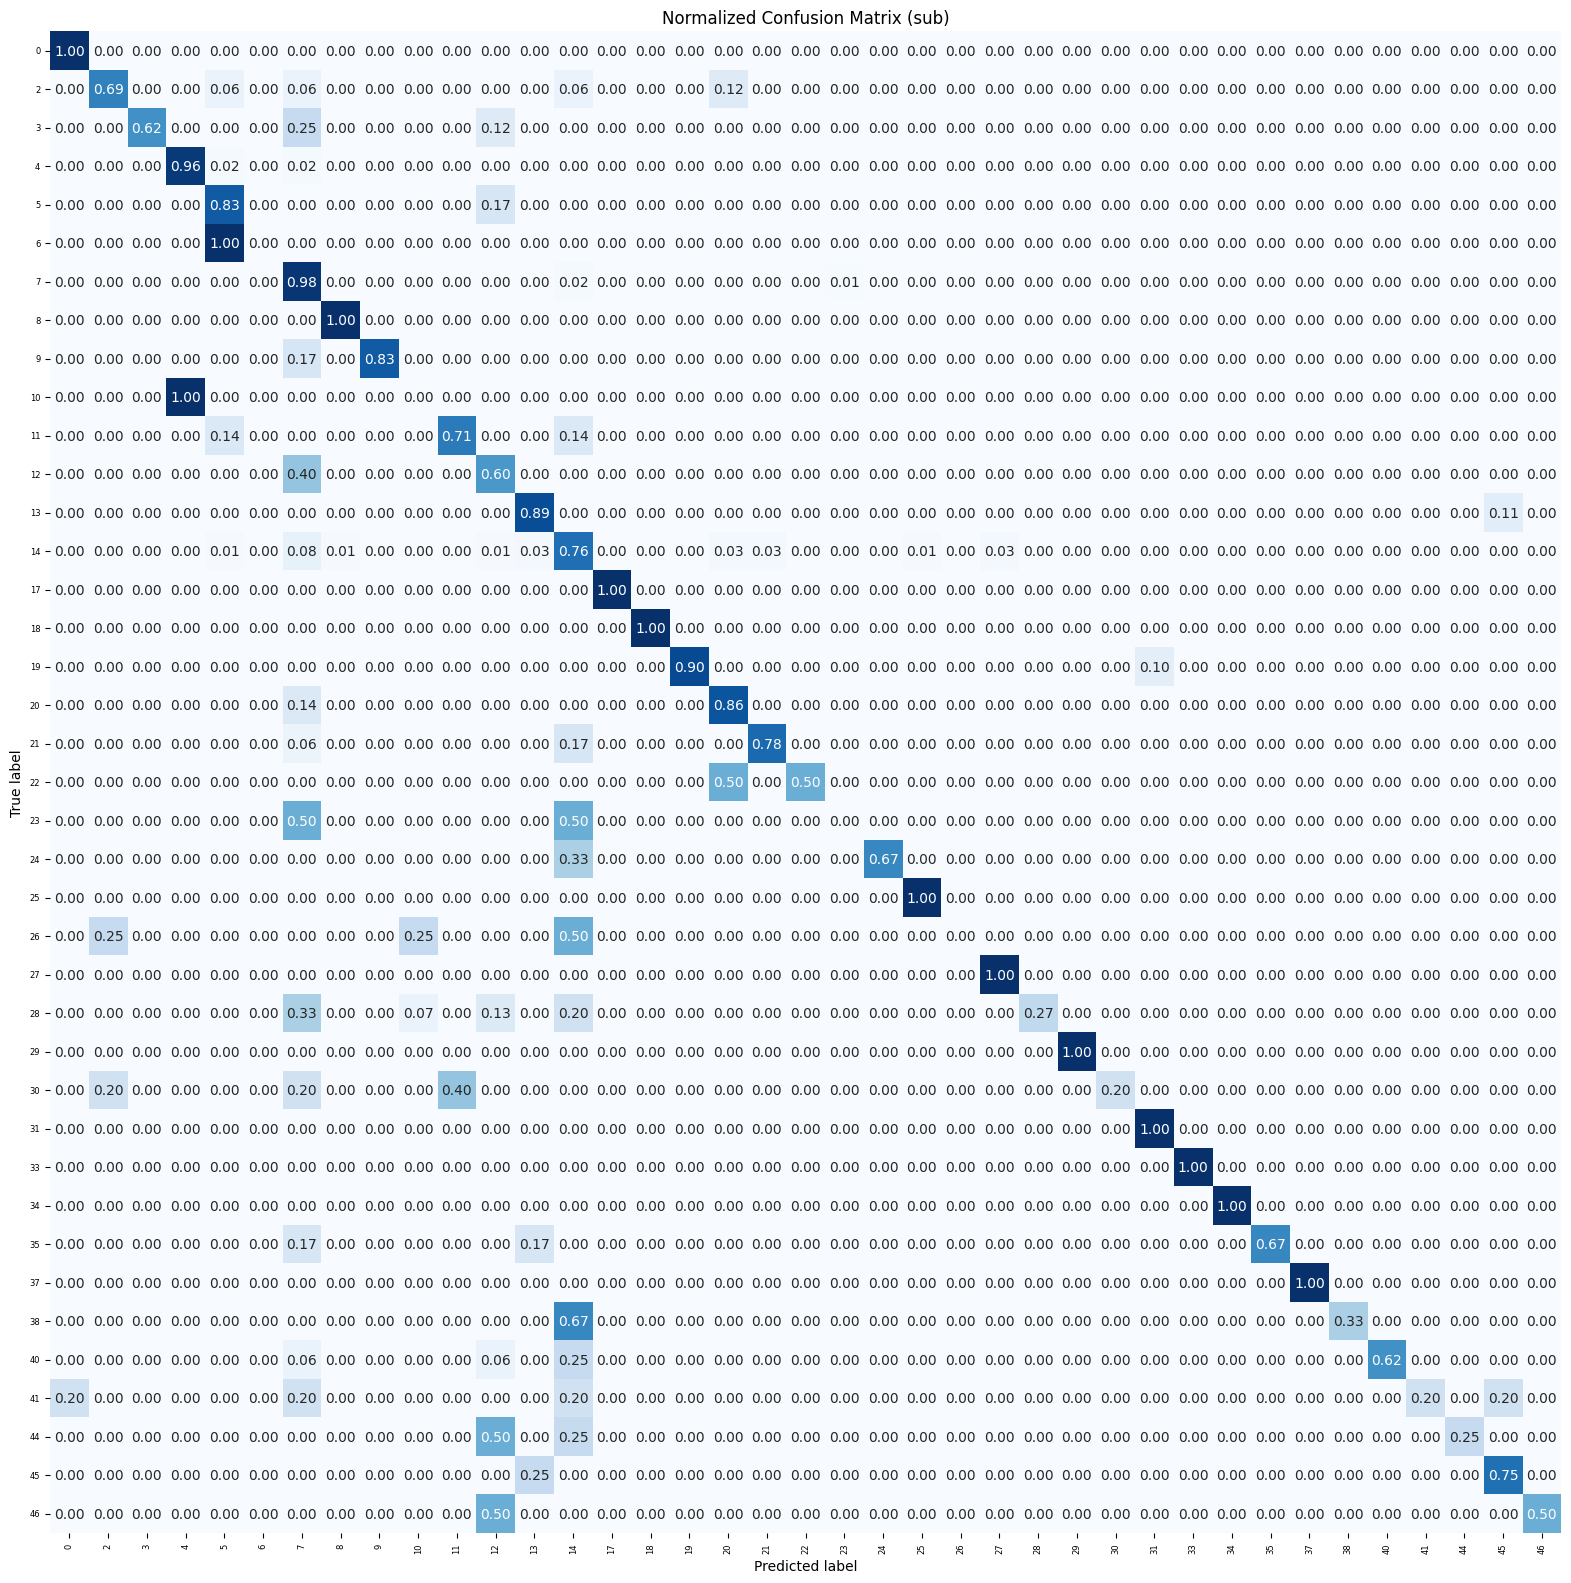

Evaluation metrics (Main):
Accuracy: 0.9020
Precision: 0.9320
Recall: 0.8643
F1-score: 0.8878
Evaluation metrics (Sub):
Accuracy: 0.8140
Precision: 0.7768
Recall: 0.6762
F1-score: 0.6812
Training model with h_dim = 75
Epoch 1/100
171/171 [==============================] - 4s 11ms/step - loss: 3.7897 - main_output_loss: 1.1113 - sub_output_loss: 2.6088 - main_output_accuracy: 0.5682 - sub_output_accuracy: 0.3595 - val_loss: 2.7230 - val_main_output_loss: 0.6222 - val_sub_output_loss: 2.0289 - val_main_output_accuracy: 0.7780 - val_sub_output_accuracy: 0.5720
Epoch 2/100
171/171 [==============================] - 1s 7ms/step - loss: 2.2958 - main_output_loss: 0.5916 - sub_output_loss: 1.6295 - main_output_accuracy: 0.7935 - sub_output_accuracy: 0.5816 - val_loss: 2.2981 - val_main_output_loss: 0.6018 - val_sub_output_loss: 1.6184 - val_main_output_accuracy: 0.7940 - val_sub_output_accuracy: 0.6120
Epoch 3/100
171/171 [==============================] - 1s 7ms/step - loss: 1.8058 - main_ou

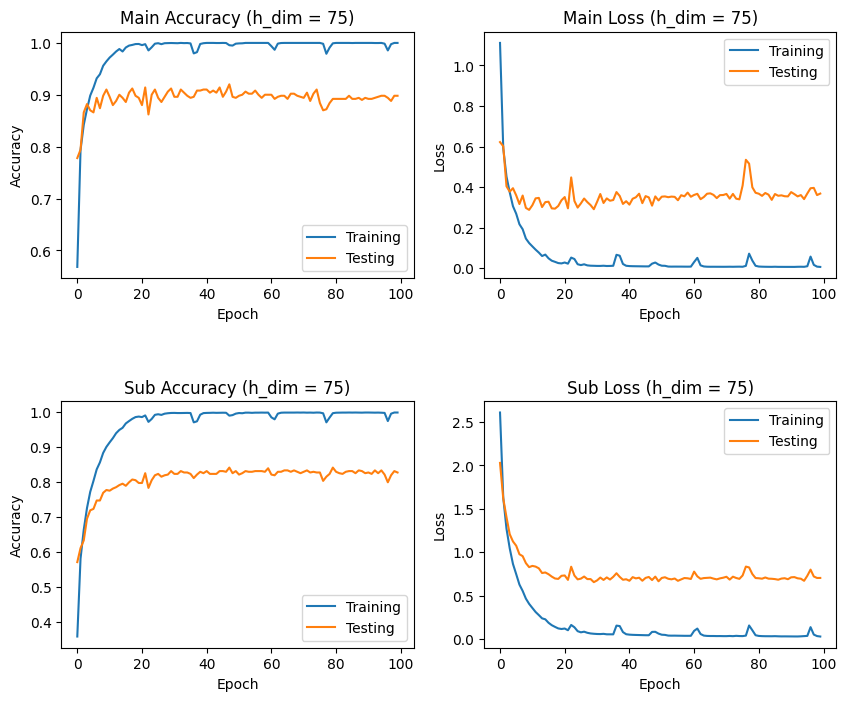

16/16 [==============================] - 0s 3ms/step


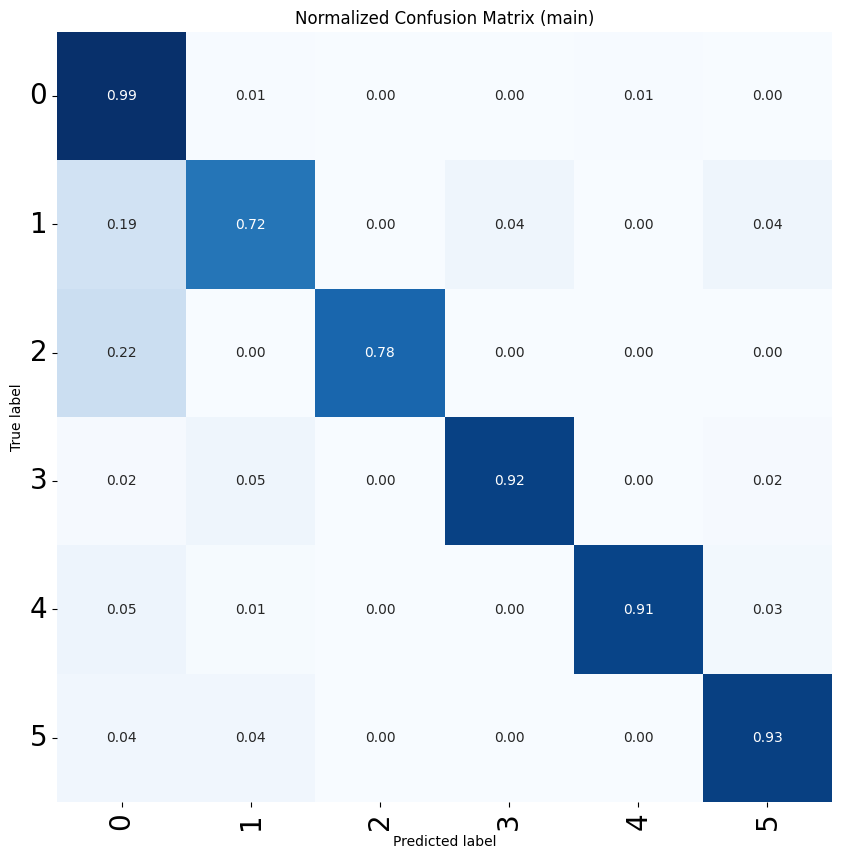

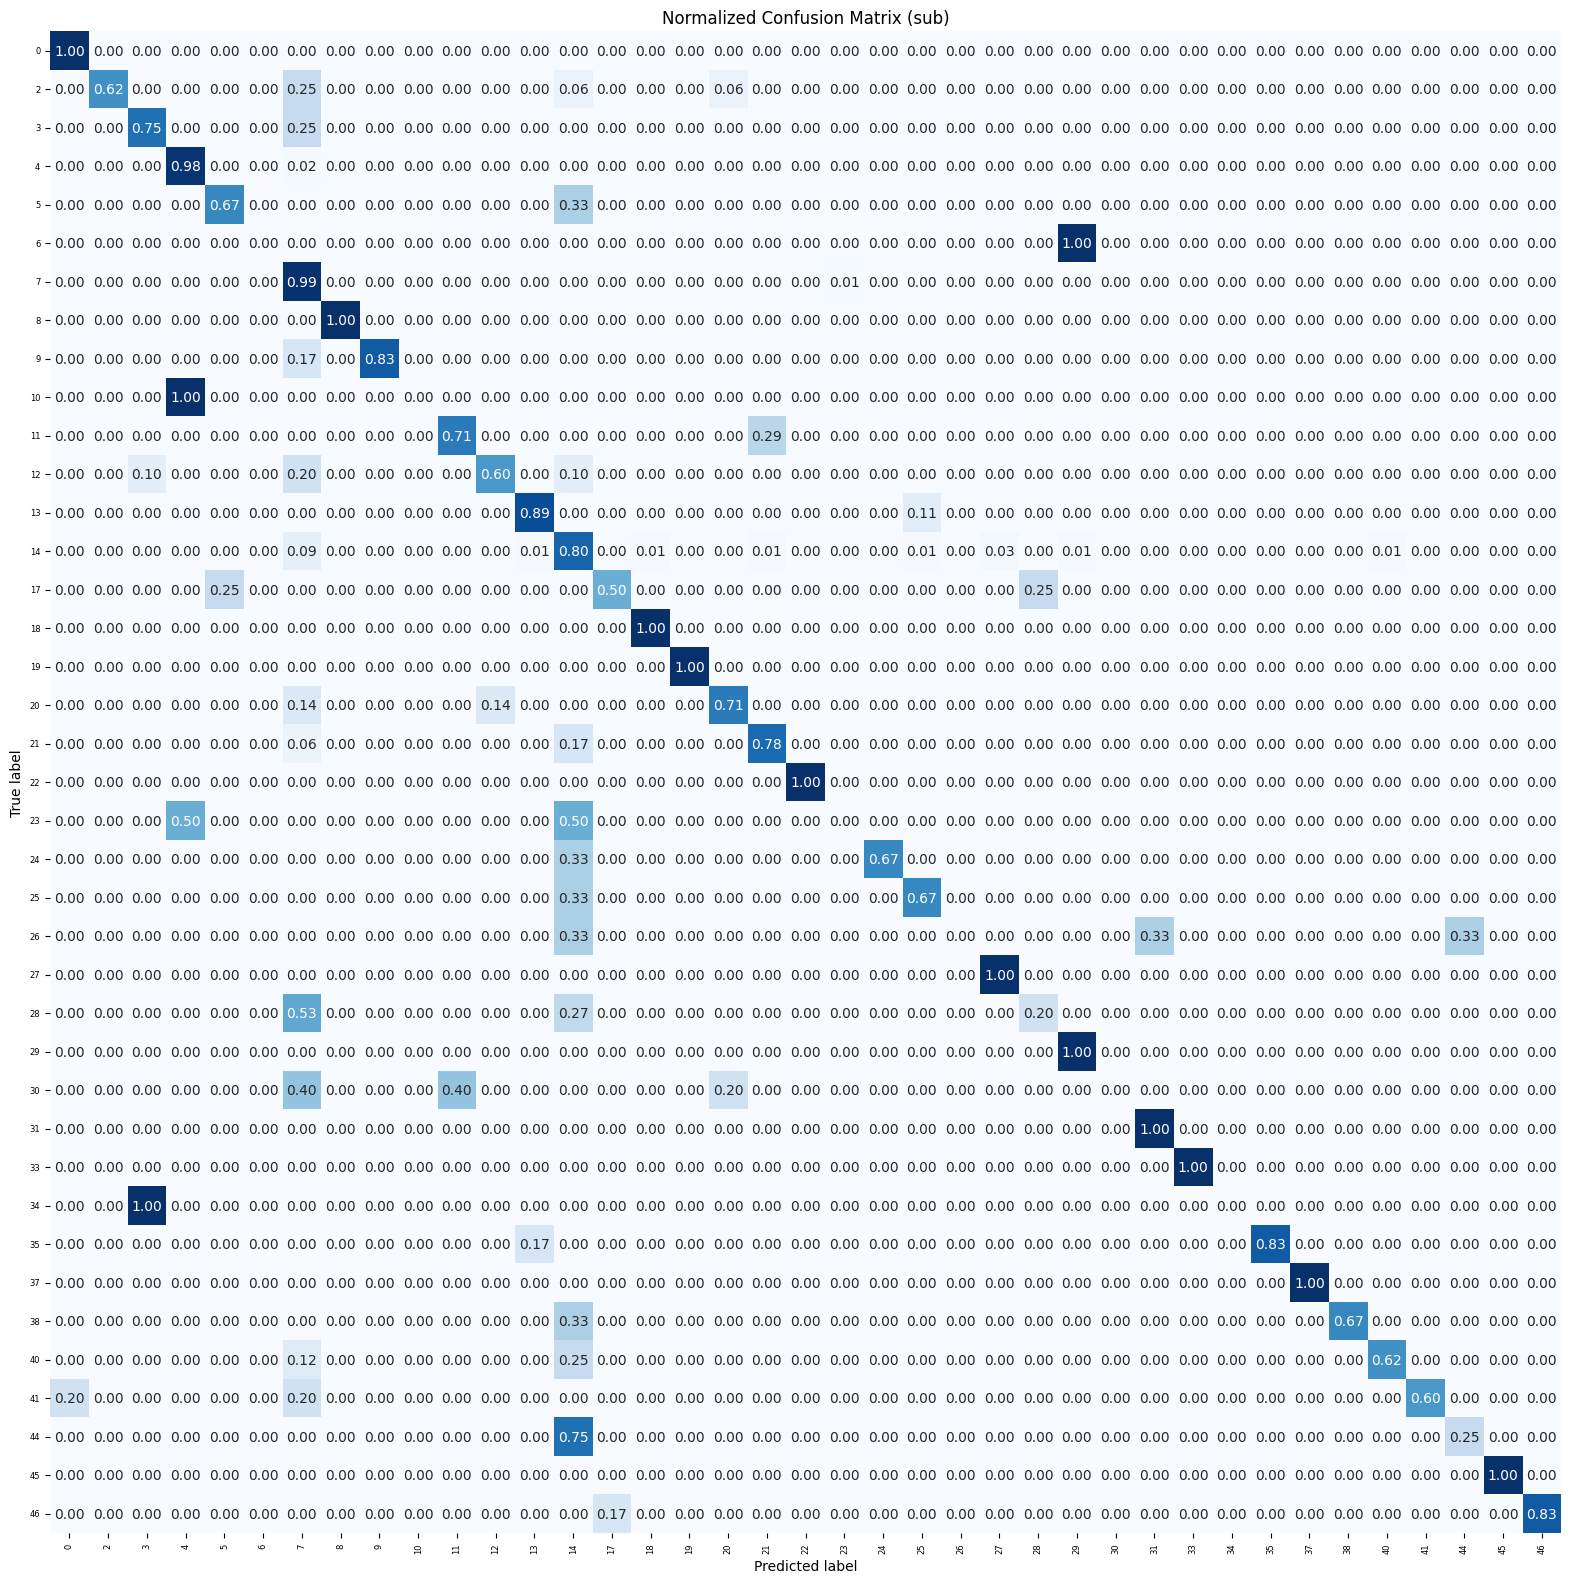

Evaluation metrics (Main):
Accuracy: 0.8980
Precision: 0.9243
Recall: 0.8745
F1-score: 0.8940
Evaluation metrics (Sub):
Accuracy: 0.8280
Precision: 0.6824
Recall: 0.6546
F1-score: 0.6487
Training model with h_dim = 100
Epoch 1/100
171/171 [==============================] - 4s 10ms/step - loss: 3.6908 - main_output_loss: 1.0873 - sub_output_loss: 2.5304 - main_output_accuracy: 0.5765 - sub_output_accuracy: 0.3650 - val_loss: 2.6221 - val_main_output_loss: 0.6228 - val_sub_output_loss: 1.9242 - val_main_output_accuracy: 0.7900 - val_sub_output_accuracy: 0.5920
Epoch 2/100
171/171 [==============================] - 1s 7ms/step - loss: 2.1590 - main_output_loss: 0.5682 - sub_output_loss: 1.5122 - main_output_accuracy: 0.8010 - sub_output_accuracy: 0.6064 - val_loss: 2.1426 - val_main_output_loss: 0.5339 - val_sub_output_loss: 1.5264 - val_main_output_accuracy: 0.7900 - val_sub_output_accuracy: 0.6160
Epoch 3/100
171/171 [==============================] - 2s 9ms/step - loss: 1.6515 - main_o

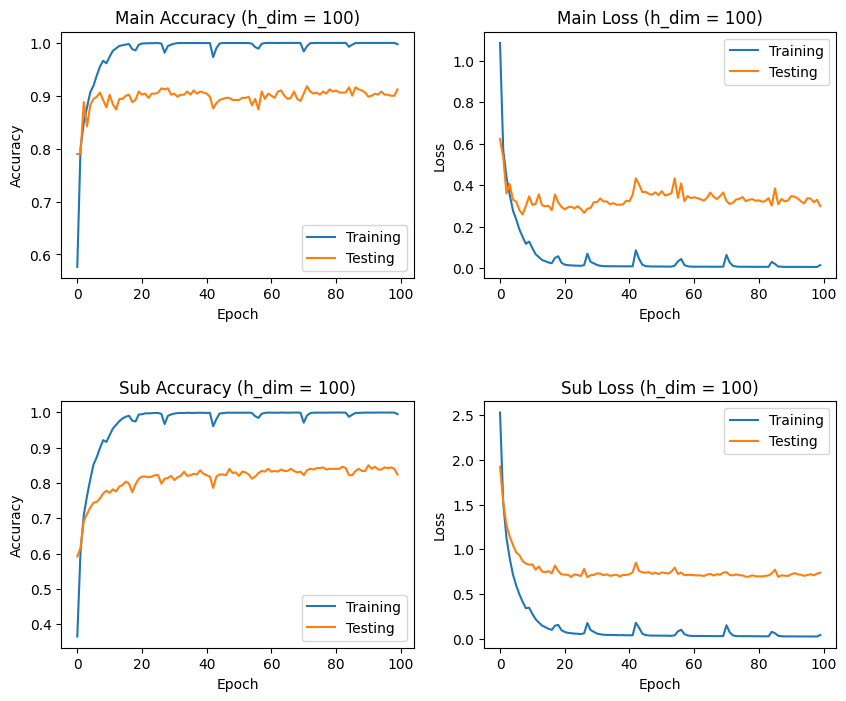

16/16 [==============================] - 0s 3ms/step


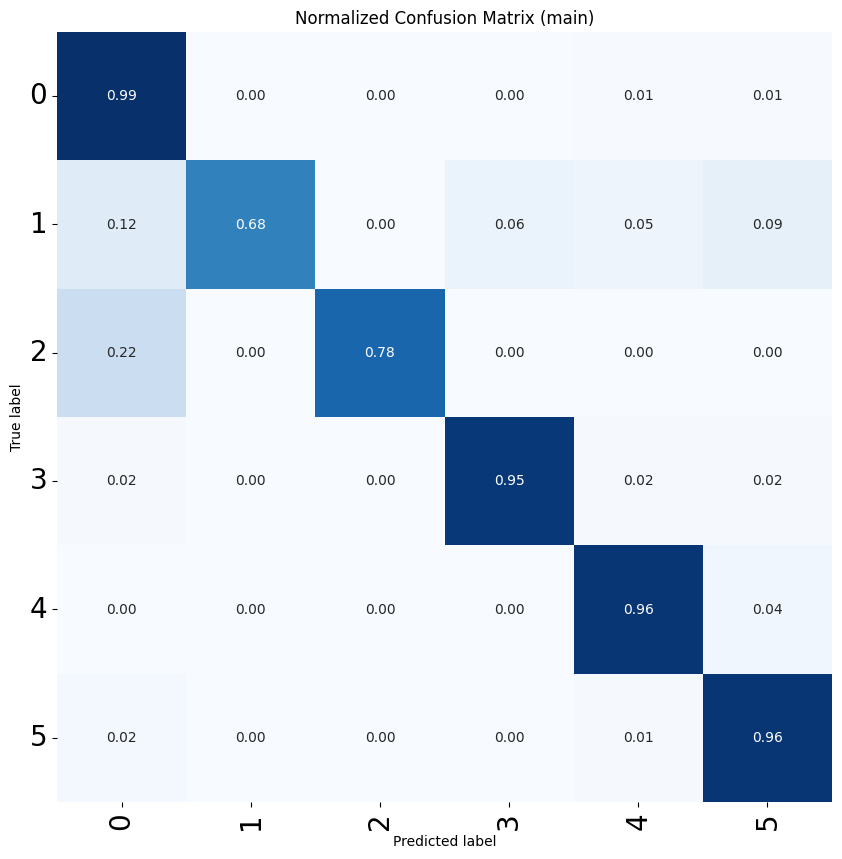

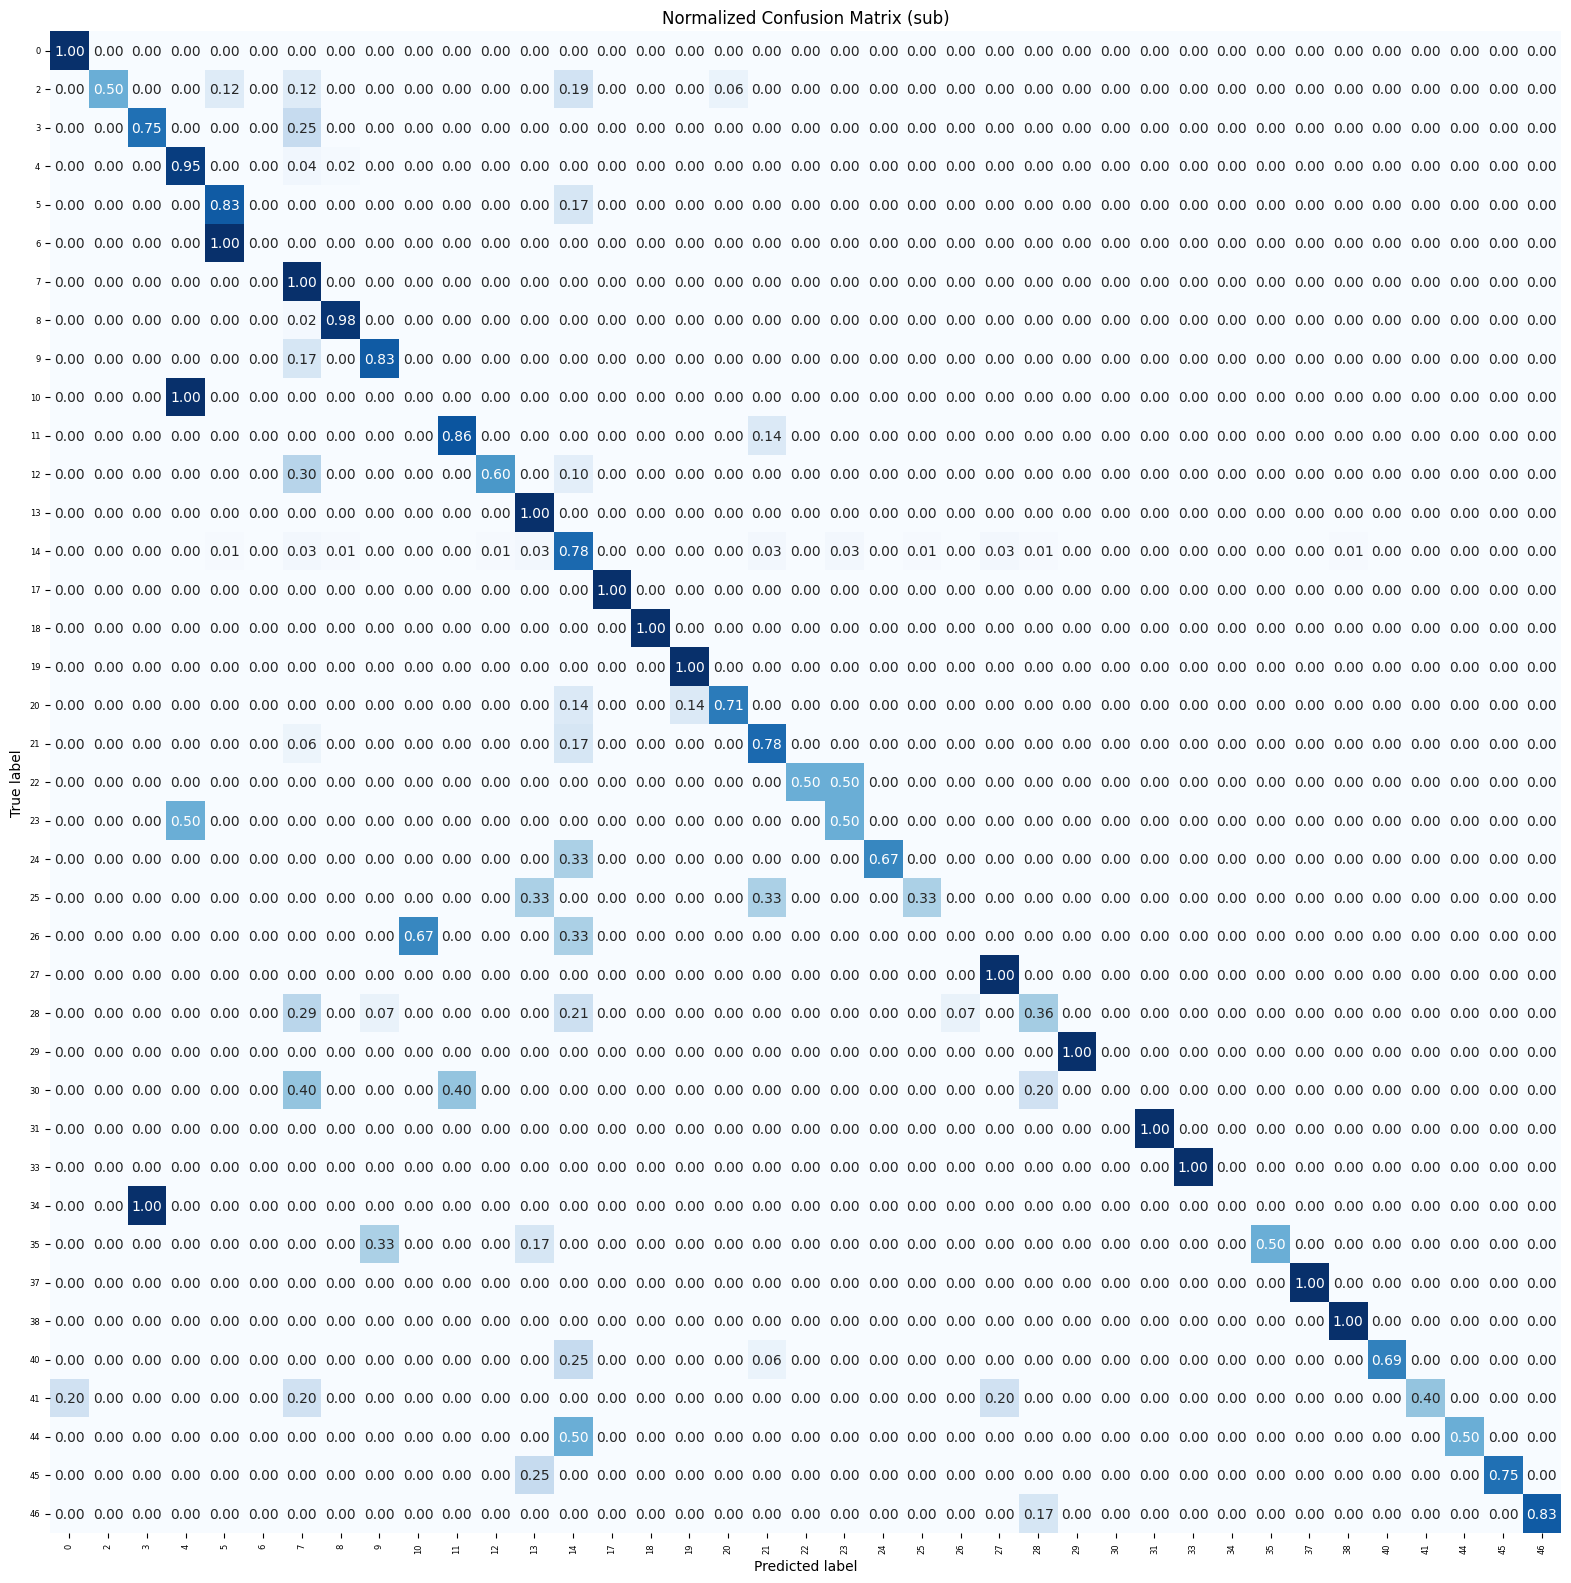

Evaluation metrics (Main):
Accuracy: 0.9120
Precision: 0.9310
Recall: 0.8876
F1-score: 0.9008
Evaluation metrics (Sub):
Accuracy: 0.8240
Precision: 0.7195
Recall: 0.6638
F1-score: 0.6704


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import warnings
from tensorflow.keras.utils import to_categorical

# Ignore all warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 100
batch_size = 32

# Function to create the LSTM model
from keras import regularizers
def create_lstm_model(input_length, h_dim):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    lstm_layer = LSTM(h_dim, activation='tanh', return_sequences=True, return_state=True)
    lstm_outputs, state_h, state_c = lstm_layer(embedding_layer)
    main_output = Dense(len(encoder_main.classes_), activation='softmax', name='main_output', kernel_regularizer=regularizers.l2(0.001))(state_h)
    sub_output = Dense(len(encoder_sub.classes_), activation='softmax', name='sub_output', kernel_regularizer=regularizers.l2(0.001))(lstm_outputs[:, -1, :])
    model = Model(inputs=input_layer, outputs=[main_output, sub_output])
    model.compile(optimizer=Adam(learning_rate=0.001), loss={'main_output': 'sparse_categorical_crossentropy', 'sub_output': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename, history, h_dim):
    with PdfPages(filename) as pdf:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        axs[0, 0].plot(history.history['main_output_accuracy'], label='Training')
        axs[0, 0].plot(history.history['val_main_output_accuracy'], label='Testing')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()
        axs[0, 0].set_title(f'Main Accuracy (h_dim = {h_dim})')

        axs[0, 1].plot(history.history['main_output_loss'], label='Training')
        axs[0, 1].plot(history.history['val_main_output_loss'], label='Testing')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()
        axs[0, 1].set_title(f'Main Loss (h_dim = {h_dim})')

        axs[1, 0].plot(history.history['sub_output_accuracy'], label='Training')
        axs[1, 0].plot(history.history['val_sub_output_accuracy'], label='Testing')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()
        axs[1, 0].set_title(f'Sub Accuracy (h_dim = {h_dim})')

        axs[1, 1].plot(history.history['sub_output_loss'], label='Training')
        axs[1, 1].plot(history.history['val_sub_output_loss'], label='Testing')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].legend()
        axs[1, 1].set_title(f'Sub Loss (h_dim = {h_dim})')

        plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

        pdf.savefig(bbox_inches='tight')

        # Show the plots
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename, label_type):
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    # Calculate the appropriate figure size based on the number of classes
    figsize = max(10, num_classes / 2)

    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)

    # Adjust the font size of the numbers inside the heatmap
    annot_fontsize = max(6, 120 // num_classes)
    plt.tick_params(axis='both', labelsize=annot_fontsize)

    # Map the class indices to their corresponding labels
    class_labels = encoder_sub.inverse_transform(unique_classes)

    plt.xticks(np.arange(num_classes) + 0.5, class_labels, rotation='vertical')
    plt.yticks(np.arange(num_classes) + 0.5, class_labels, rotation='horizontal')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Normalized Confusion Matrix ({label_type})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()

# Function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, label_type):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Evaluation metrics ({label_type}):')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert tokens to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
maxlen = max(len(seq) for seq in train_sequences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=maxlen)
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Encode main labels
encoder_main = LabelEncoder()
encoder_main.fit(train_data['label-coarse'])
train_encoded_main_labels = encoder_main.transform(train_data['label-coarse'])
test_encoded_main_labels = encoder_main.transform(test_data['label-coarse'])

# Encode sub labels
encoder_sub = LabelEncoder()
encoder_sub.fit(train_data['label-fine'])
train_encoded_sub_labels = encoder_sub.transform(train_data['label-fine'])
test_encoded_sub_labels = encoder_sub.transform(test_data['label-fine'])

# Convert main labels to one-hot vectors
y_main_train = to_categorical(train_encoded_main_labels)
y_main_test = to_categorical(test_encoded_main_labels)

# Convert sub labels to one-hot vectors
y_sub_train = to_categorical(train_encoded_sub_labels)
y_sub_test = to_categorical(test_encoded_sub_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim)

    # Fit the model
    history = model.fit(
        train_padded_sequences,
        {'main_output': train_encoded_main_labels, 'sub_output': train_encoded_sub_labels},
        validation_data=(test_padded_sequences, {'main_output': test_encoded_main_labels, 'sub_output': test_encoded_sub_labels}),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save plots and confusion matrices
    timestamp = str(int(time.time()))
    save_plots_to_pdf(f'plots_{h_dim}_{timestamp}.pdf', history, h_dim)

    # Only plot confusion matrices for the test data
    main_output_predictions, sub_output_predictions = model.predict(test_padded_sequences)
    main_output_predictions = np.argmax(main_output_predictions, axis=1)
    sub_output_predictions = np.argmax(sub_output_predictions, axis=1)

    save_confusion_matrix_to_pdf(
        test_encoded_main_labels,
        main_output_predictions,
        f'confusion_matrix_test_main_{h_dim}_{timestamp}.pdf',
        'main'
    )
    save_confusion_matrix_to_pdf(
        test_encoded_sub_labels,
        sub_output_predictions,
        f'confusion_matrix_test_sub_{h_dim}_{timestamp}.pdf',
        'sub'
    )

    print_evaluation_metrics(test_encoded_main_labels, main_output_predictions, 'Main')
    print_evaluation_metrics(test_encoded_sub_labels, sub_output_predictions, 'Sub')


### Method1 (Val = Val)

Training model with h_dim = 25
Epoch 1/50
69/69 [==============================] - 4s 21ms/step - loss: 5.0472 - main_output_loss: 1.5435 - sub_output_loss: 3.5037 - main_output_accuracy: 0.3738 - sub_output_accuracy: 0.1672 - val_loss: 4.4427 - val_main_output_loss: 1.3283 - val_sub_output_loss: 3.1144 - val_main_output_accuracy: 0.5023 - val_sub_output_accuracy: 0.2924
Epoch 2/50
69/69 [==============================] - 1s 10ms/step - loss: 3.9729 - main_output_loss: 1.1645 - sub_output_loss: 2.8084 - main_output_accuracy: 0.5719 - sub_output_accuracy: 0.3401 - val_loss: 3.7066 - val_main_output_loss: 1.0429 - val_sub_output_loss: 2.6637 - val_main_output_accuracy: 0.6251 - val_sub_output_accuracy: 0.3648
Epoch 3/50
69/69 [==============================] - 1s 7ms/step - loss: 3.3855 - main_output_loss: 0.9149 - sub_output_loss: 2.4706 - main_output_accuracy: 0.6677 - sub_output_accuracy: 0.4109 - val_loss: 3.2443 - val_main_output_loss: 0.8439 - val_sub_output_loss: 2.4003 - val_main

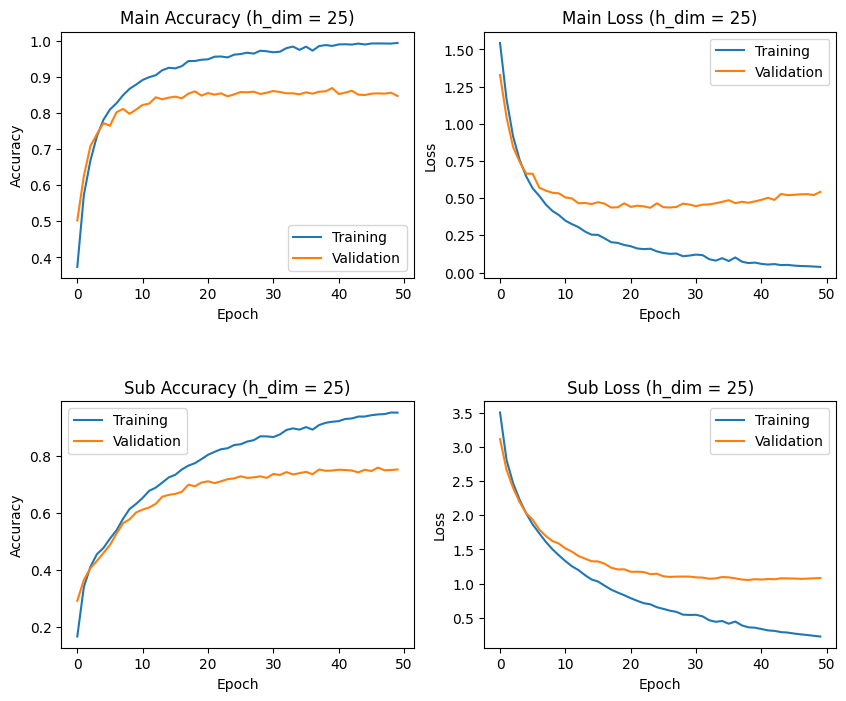

16/16 [==============================] - 0s 2ms/step


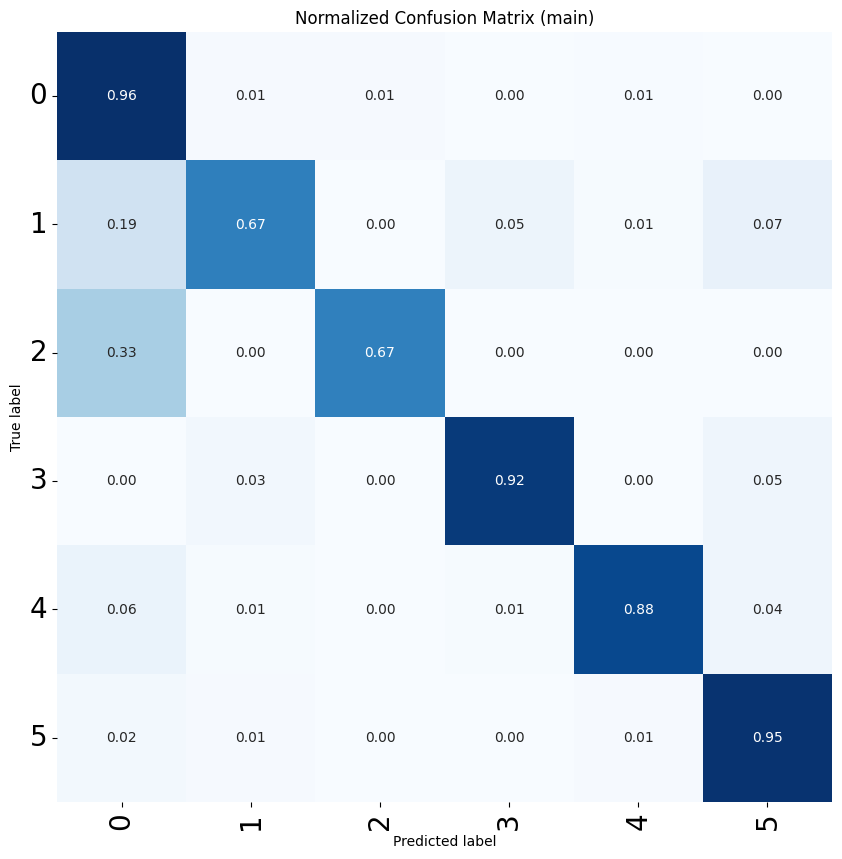

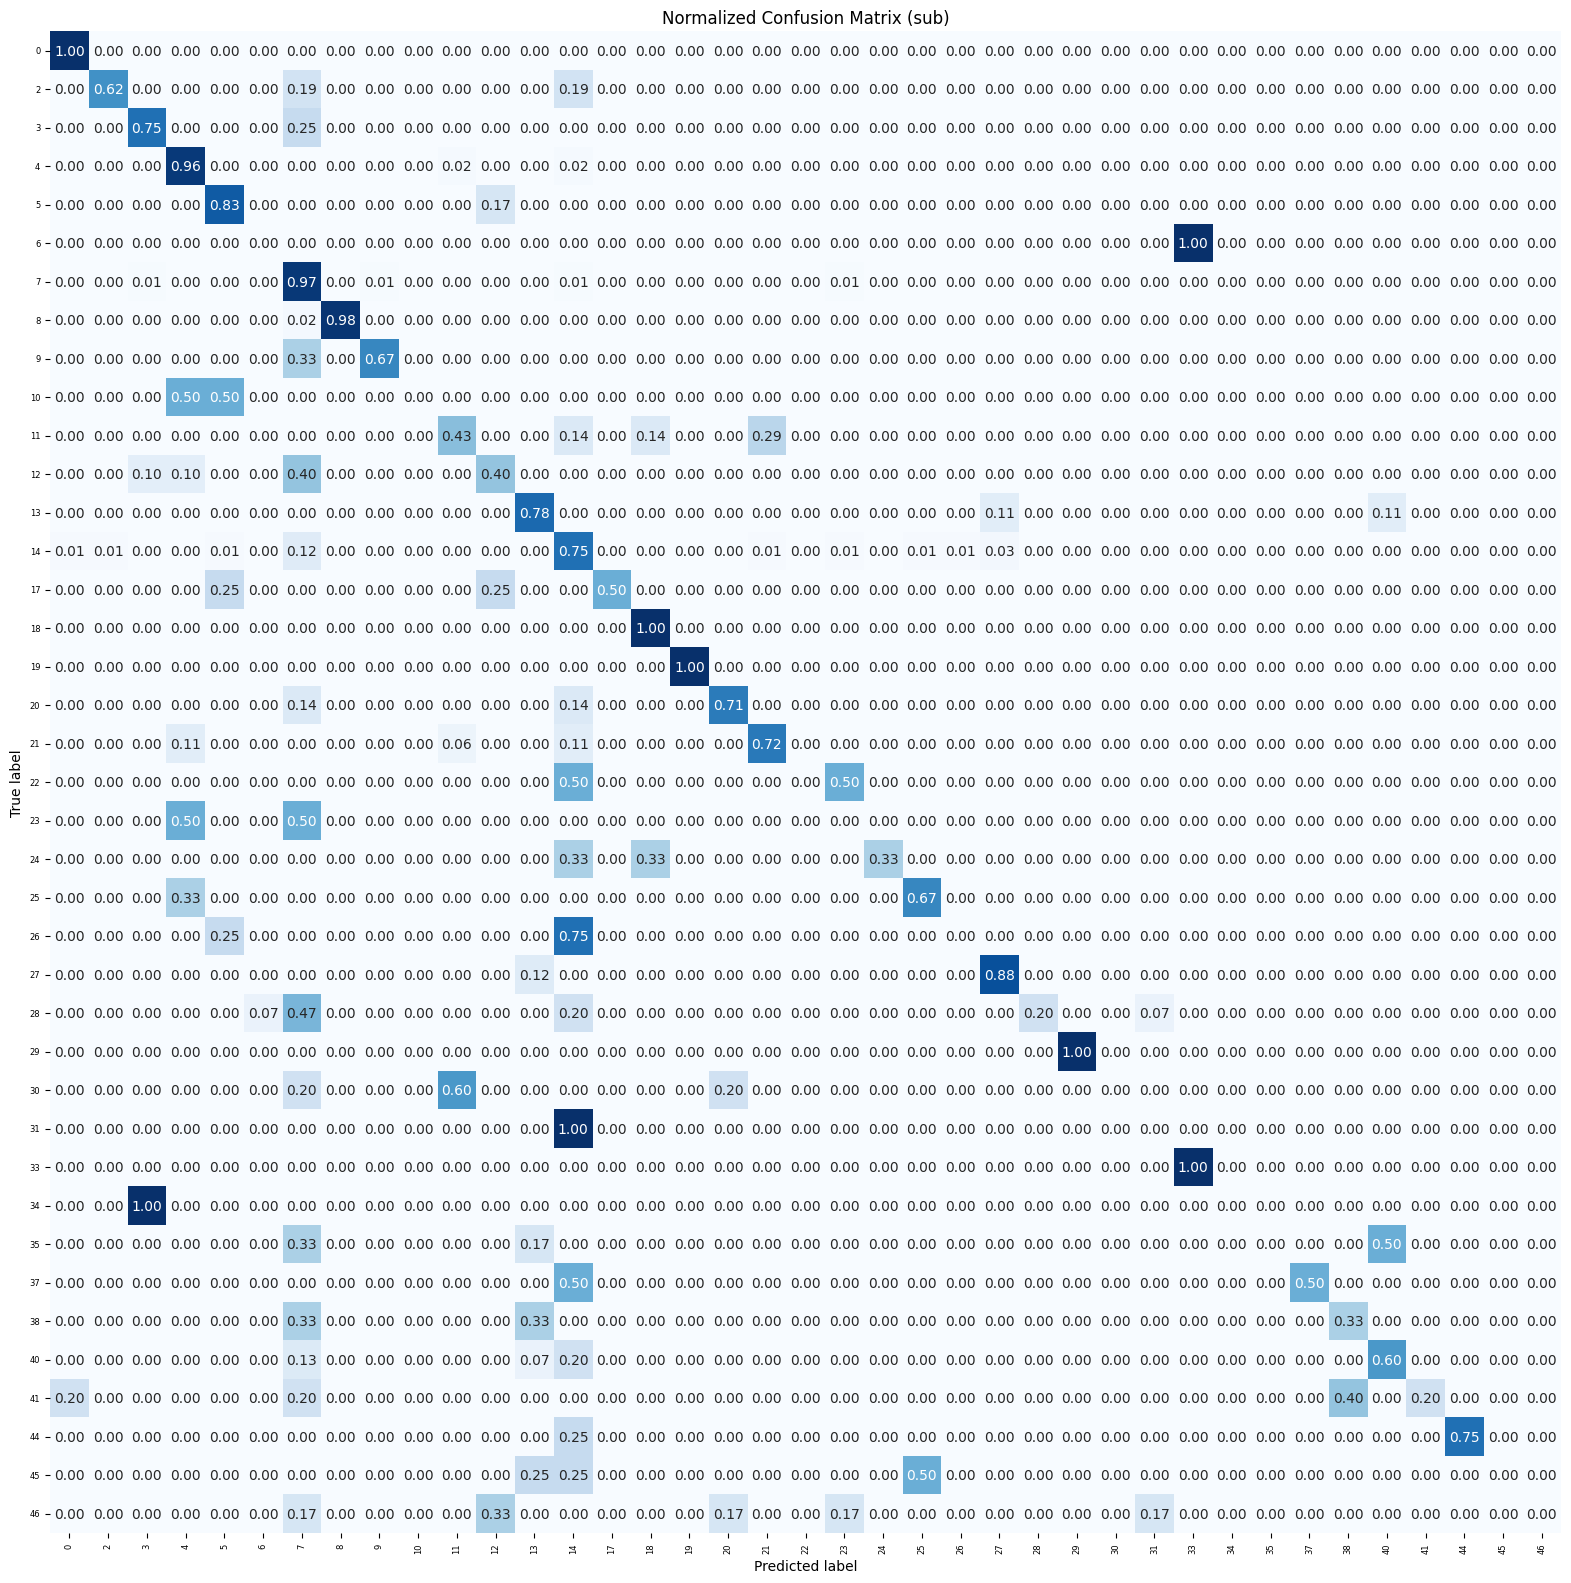

Evaluation metrics (Main):
Accuracy: 0.8760
Precision: 0.8659
Recall: 0.8417
F1-score: 0.8483
Evaluation metrics (Sub):
Accuracy: 0.7520
Precision: 0.5121
Recall: 0.4749
F1-score: 0.4629
Training model with h_dim = 50
Epoch 1/50
69/69 [==============================] - 4s 15ms/step - loss: 4.6665 - main_output_loss: 1.4864 - sub_output_loss: 3.1801 - main_output_accuracy: 0.4127 - sub_output_accuracy: 0.2293 - val_loss: 3.9048 - val_main_output_loss: 1.1781 - val_sub_output_loss: 2.7267 - val_main_output_accuracy: 0.5545 - val_sub_output_accuracy: 0.3272
Epoch 2/50
69/69 [==============================] - 1s 7ms/step - loss: 3.4308 - main_output_loss: 0.9826 - sub_output_loss: 2.4481 - main_output_accuracy: 0.6448 - sub_output_accuracy: 0.4082 - val_loss: 3.0452 - val_main_output_loss: 0.8114 - val_sub_output_loss: 2.2338 - val_main_output_accuracy: 0.7085 - val_sub_output_accuracy: 0.4106
Epoch 3/50
69/69 [==============================] - 1s 8ms/step - loss: 2.6958 - main_output_loss

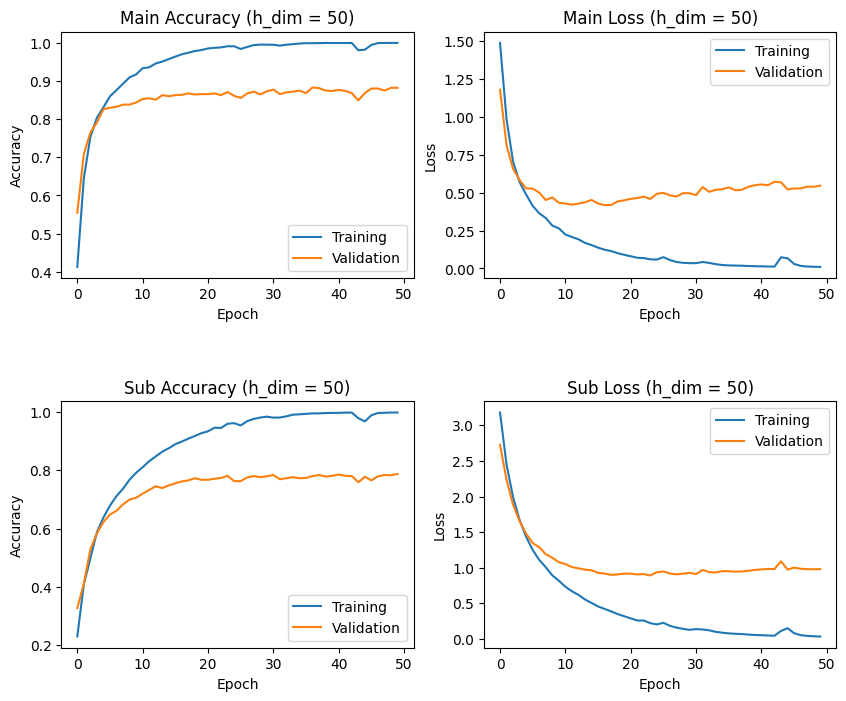

16/16 [==============================] - 0s 3ms/step


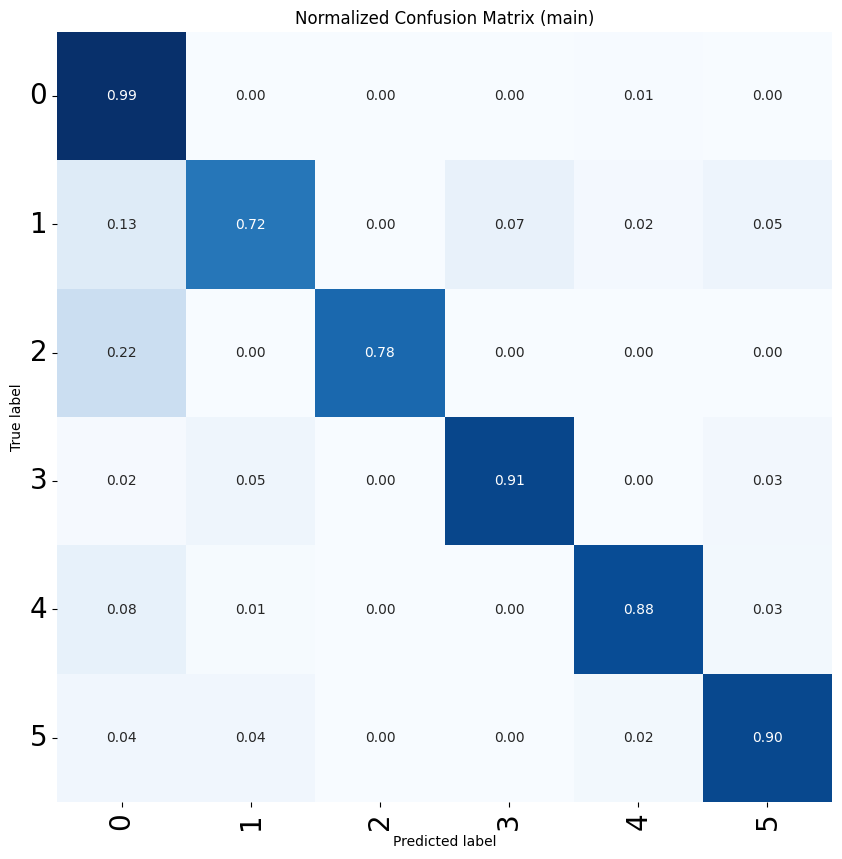

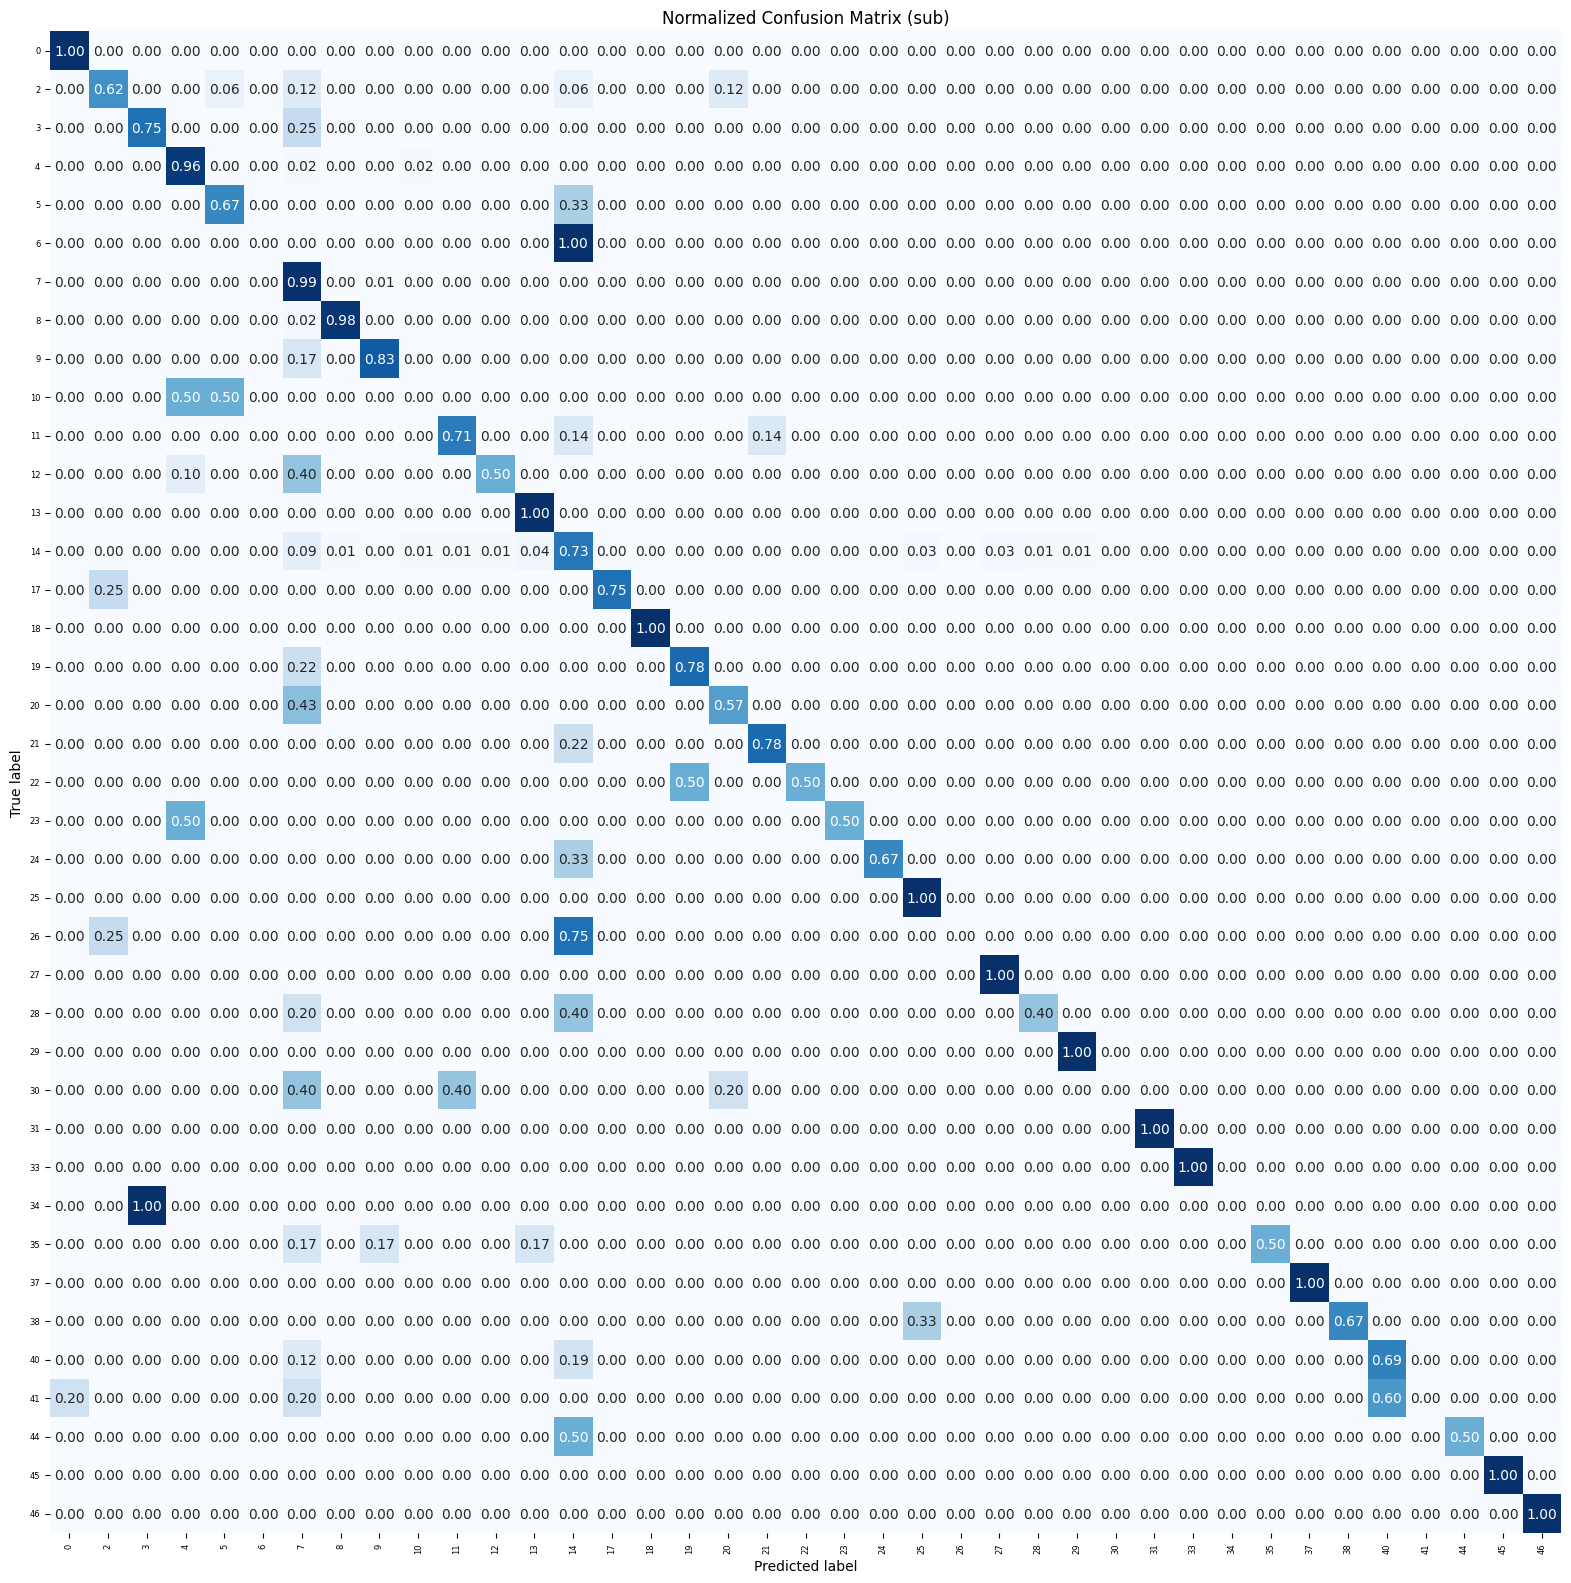

Evaluation metrics (Main):
Accuracy: 0.8880
Precision: 0.9113
Recall: 0.8646
F1-score: 0.8826
Evaluation metrics (Sub):
Accuracy: 0.8120
Precision: 0.7030
Recall: 0.6493
F1-score: 0.6552
Training model with h_dim = 75
Epoch 1/50
69/69 [==============================] - 4s 18ms/step - loss: 4.4716 - main_output_loss: 1.4199 - sub_output_loss: 3.0518 - main_output_accuracy: 0.4361 - sub_output_accuracy: 0.2417 - val_loss: 3.6575 - val_main_output_loss: 1.1271 - val_sub_output_loss: 2.5304 - val_main_output_accuracy: 0.5903 - val_sub_output_accuracy: 0.3593
Epoch 2/50
69/69 [==============================] - 1s 11ms/step - loss: 3.0205 - main_output_loss: 0.8602 - sub_output_loss: 2.1603 - main_output_accuracy: 0.6760 - sub_output_accuracy: 0.4517 - val_loss: 2.5725 - val_main_output_loss: 0.6694 - val_sub_output_loss: 1.9031 - val_main_output_accuracy: 0.7745 - val_sub_output_accuracy: 0.4986
Epoch 3/50
69/69 [==============================] - 1s 10ms/step - loss: 2.2832 - main_output_lo

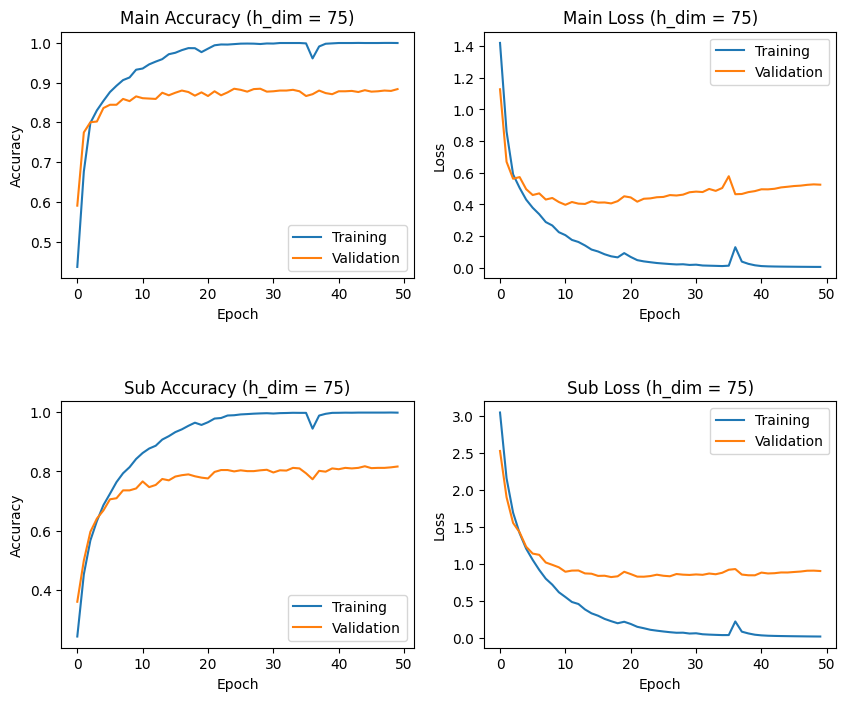

16/16 [==============================] - 0s 3ms/step


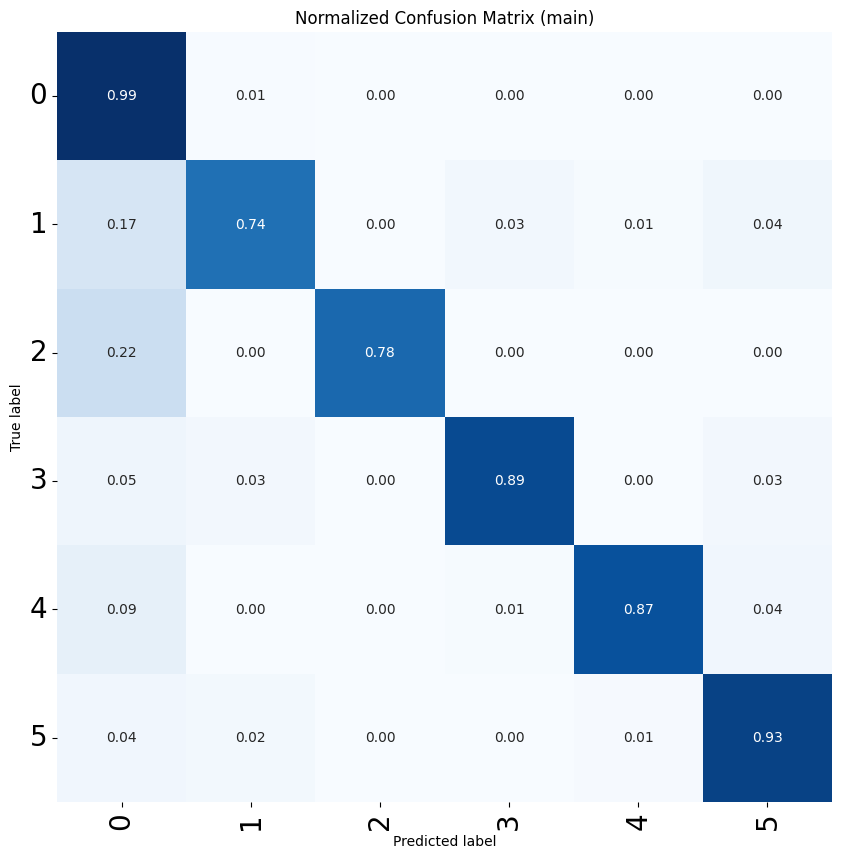

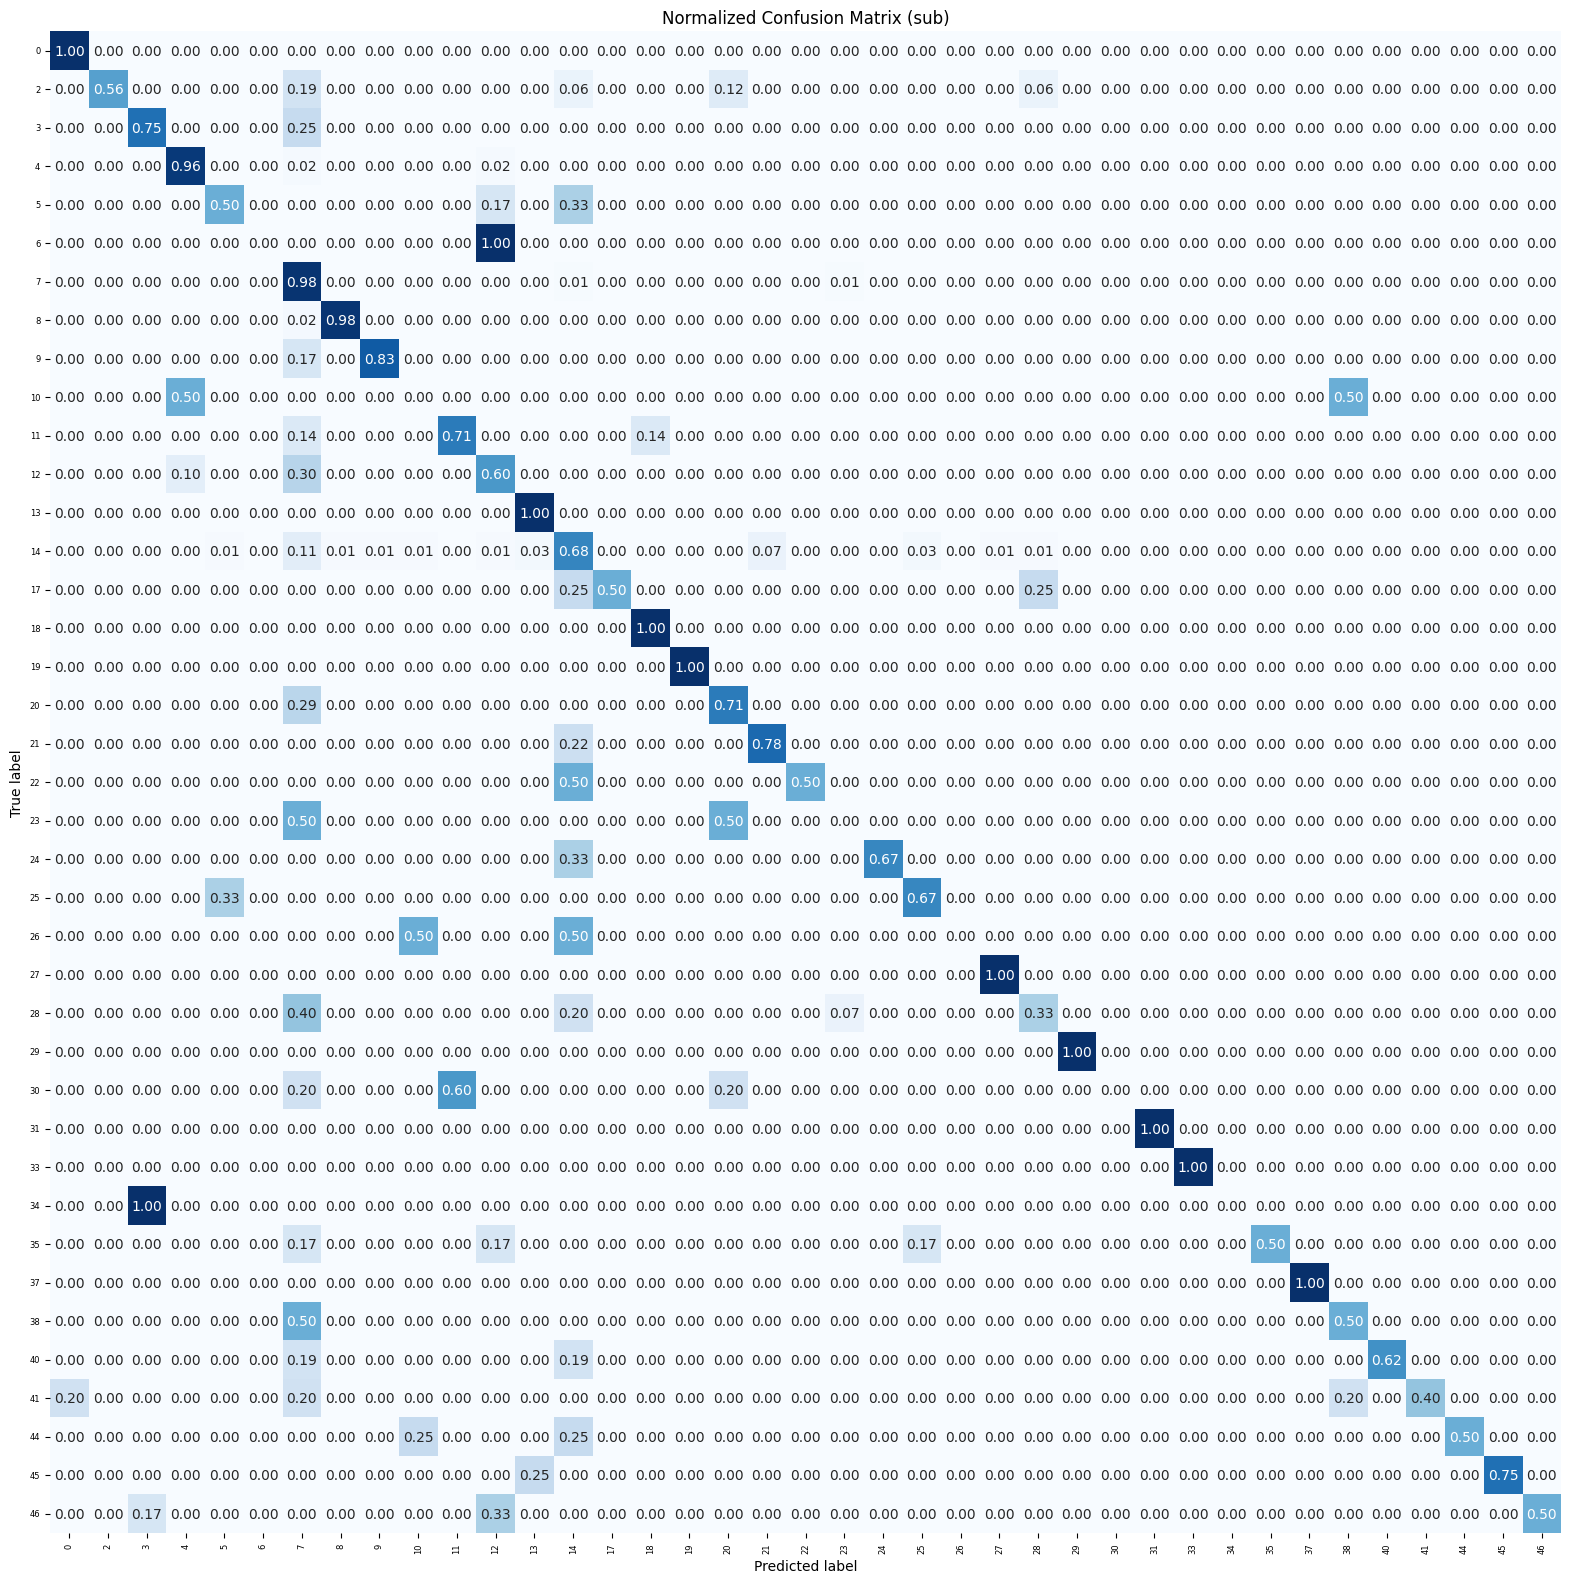

Evaluation metrics (Main):
Accuracy: 0.8900
Precision: 0.9221
Recall: 0.8668
F1-score: 0.8879
Evaluation metrics (Sub):
Accuracy: 0.7920
Precision: 0.6851
Recall: 0.6082
F1-score: 0.6244
Training model with h_dim = 100
Epoch 1/50
69/69 [==============================] - 4s 17ms/step - loss: 4.2407 - main_output_loss: 1.3236 - sub_output_loss: 2.9171 - main_output_accuracy: 0.4870 - sub_output_accuracy: 0.2958 - val_loss: 3.2772 - val_main_output_loss: 0.9691 - val_sub_output_loss: 2.3081 - val_main_output_accuracy: 0.6554 - val_sub_output_accuracy: 0.4015
Epoch 2/50
69/69 [==============================] - 1s 10ms/step - loss: 2.7240 - main_output_loss: 0.7453 - sub_output_loss: 1.9787 - main_output_accuracy: 0.7294 - sub_output_accuracy: 0.4914 - val_loss: 2.4813 - val_main_output_loss: 0.6860 - val_sub_output_loss: 1.7953 - val_main_output_accuracy: 0.7544 - val_sub_output_accuracy: 0.5371
Epoch 3/50
69/69 [==============================] - 1s 9ms/step - loss: 2.0732 - main_output_lo

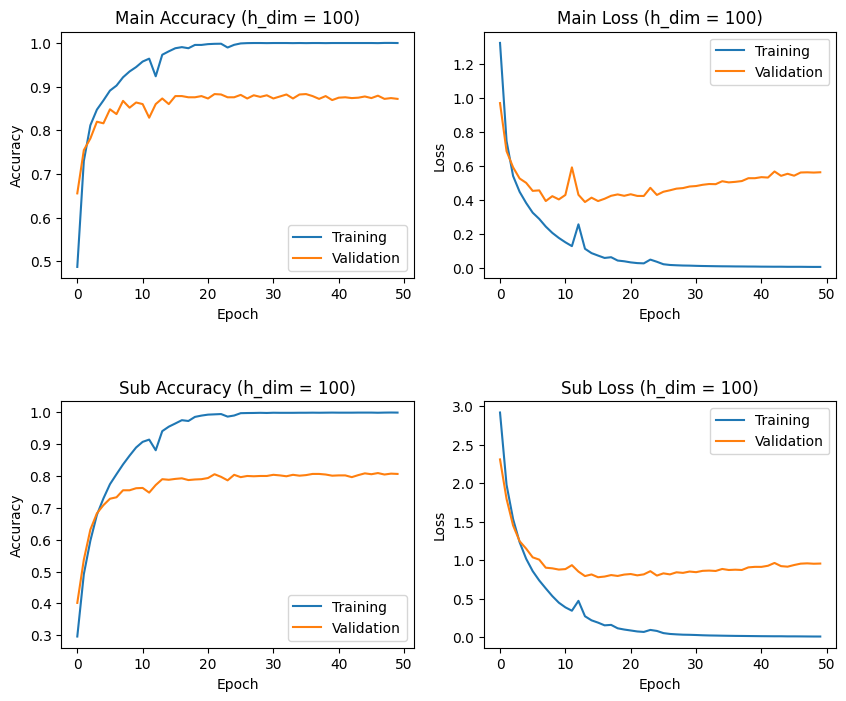

16/16 [==============================] - 1s 3ms/step


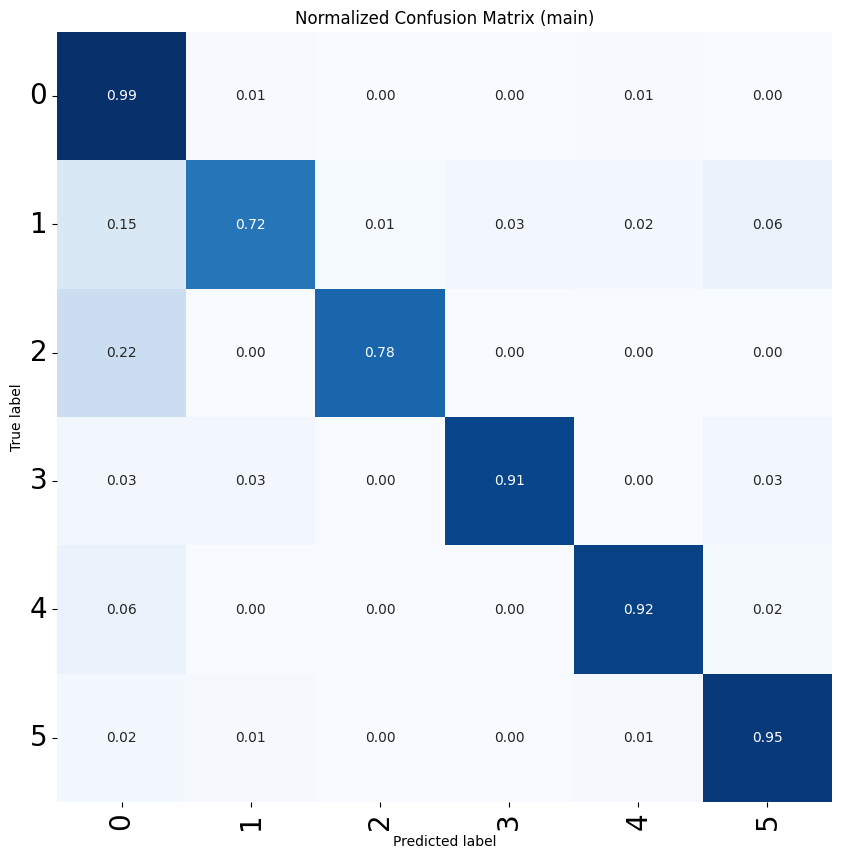

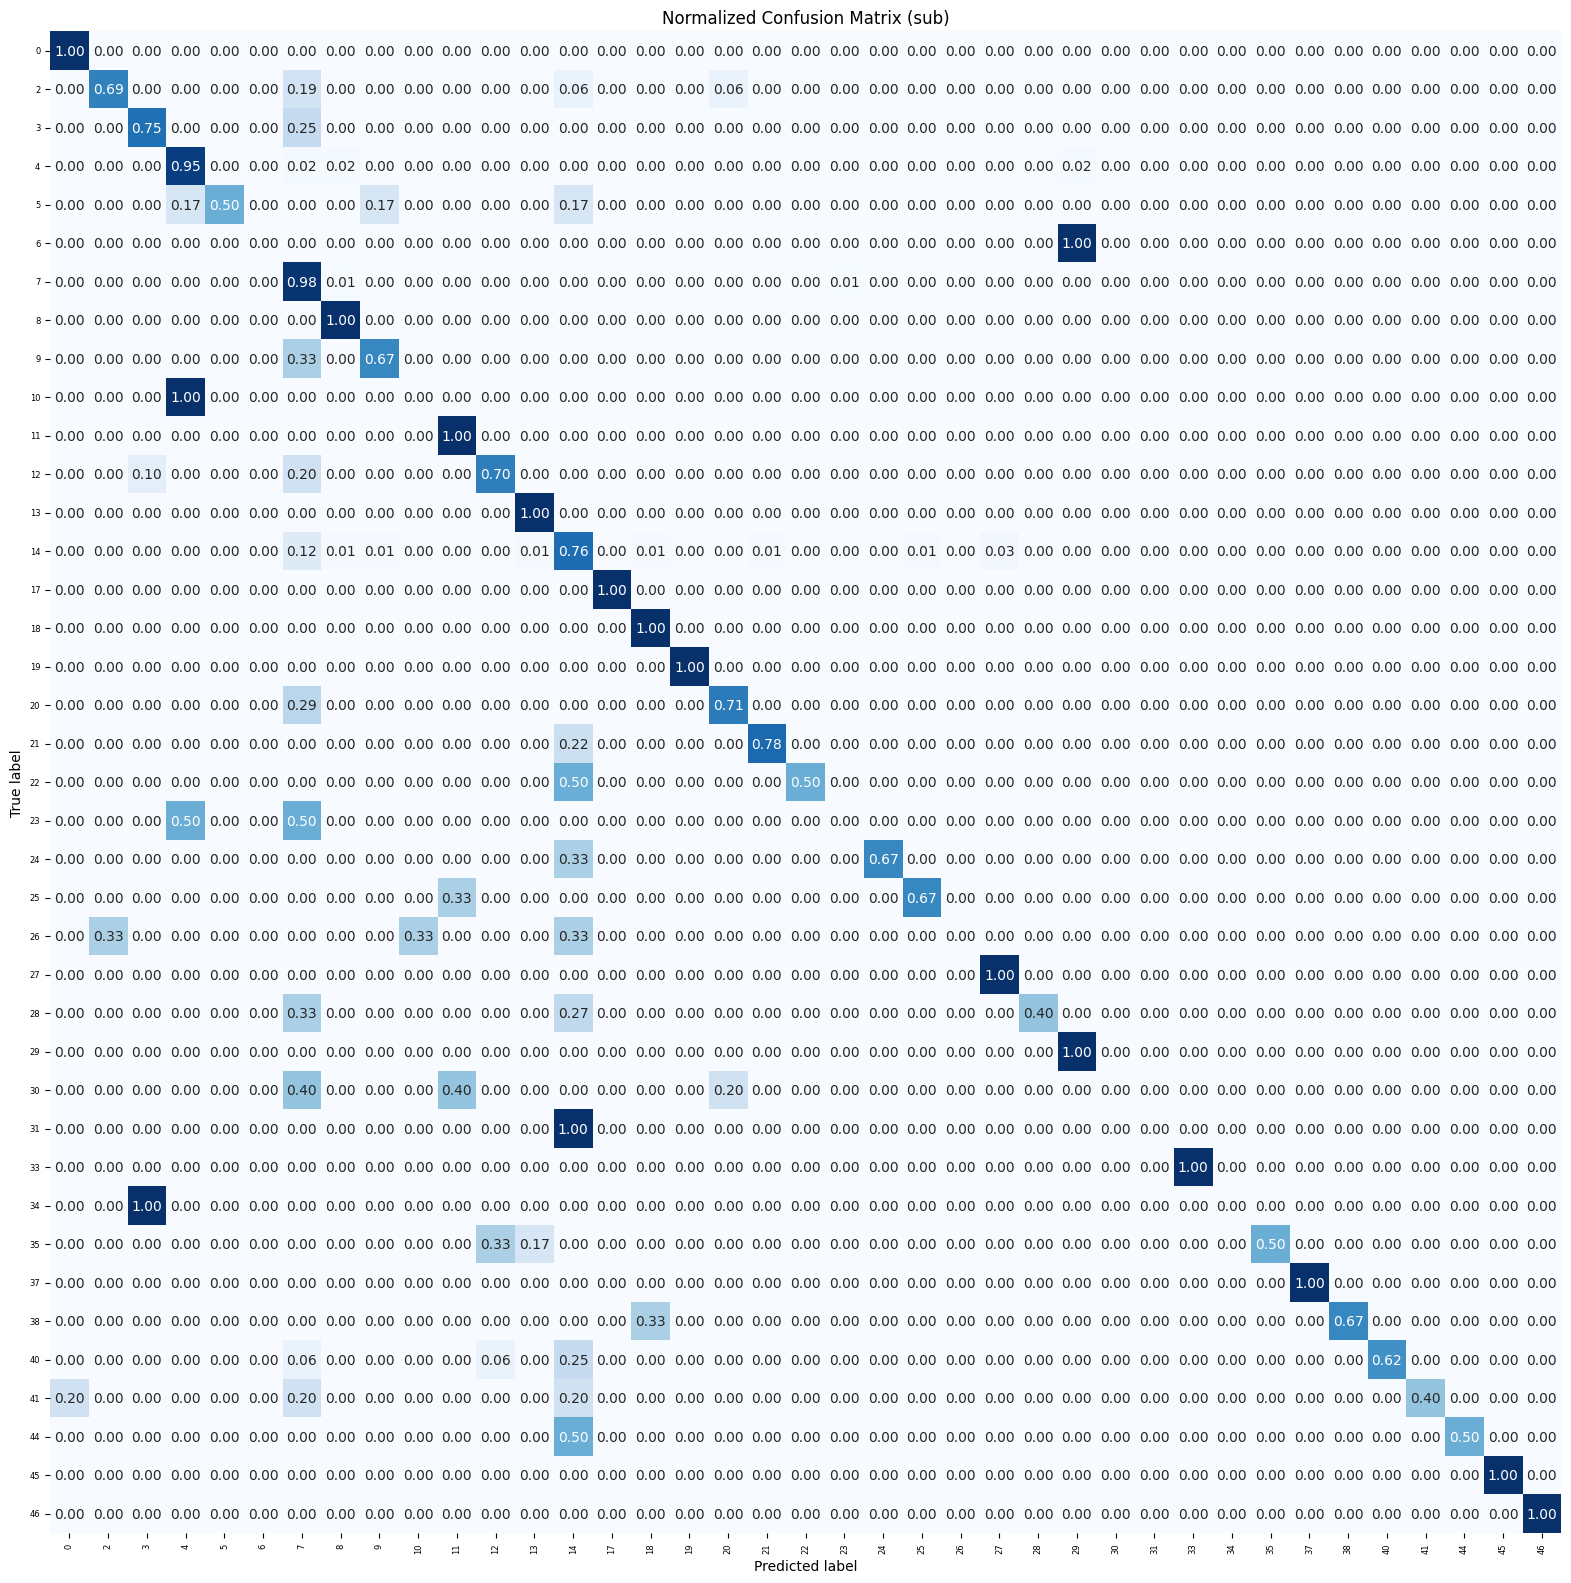

Evaluation metrics (Main):
Accuracy: 0.9020
Precision: 0.9089
Recall: 0.8776
F1-score: 0.8889
Evaluation metrics (Sub):
Accuracy: 0.8240
Precision: 0.6914
Recall: 0.6348
F1-score: 0.6373


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import warnings
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Ignore all warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 50
batch_size = 64

# Function to create the LSTM model
def create_lstm_model(input_length, h_dim):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    lstm_layer = LSTM(h_dim, activation='tanh', return_sequences=True, return_state=True)
    lstm_outputs, state_h, state_c = lstm_layer(embedding_layer)
    main_output = Dense(len(encoder_main.classes_), activation='softmax', name='main_output')(state_h)
    sub_output = Dense(len(encoder_sub.classes_), activation='softmax', name='sub_output')(lstm_outputs[:, -1, :])
    model = Model(inputs=input_layer, outputs=[main_output, sub_output])
    model.compile(optimizer=Adam(learning_rate=0.001), loss={'main_output': 'sparse_categorical_crossentropy', 'sub_output': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename, history, h_dim):
    with PdfPages(filename) as pdf:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        axs[0, 0].plot(history.history['main_output_accuracy'], label='Training')
        axs[0, 0].plot(history.history['val_main_output_accuracy'], label='Validation')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()
        axs[0, 0].set_title(f'Main Accuracy (h_dim = {h_dim})')

        axs[0, 1].plot(history.history['main_output_loss'], label='Training')
        axs[0, 1].plot(history.history['val_main_output_loss'], label='Validation')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()
        axs[0, 1].set_title(f'Main Loss (h_dim = {h_dim})')

        axs[1, 0].plot(history.history['sub_output_accuracy'], label='Training')
        axs[1, 0].plot(history.history['val_sub_output_accuracy'], label='Validation')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()
        axs[1, 0].set_title(f'Sub Accuracy (h_dim = {h_dim})')

        axs[1, 1].plot(history.history['sub_output_loss'], label='Training')
        axs[1, 1].plot(history.history['val_sub_output_loss'], label='Validation')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].legend()
        axs[1, 1].set_title(f'Sub Loss (h_dim = {h_dim})')

        plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

        pdf.savefig(bbox_inches='tight')

        # Show the plots
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename, label_type):
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    # Calculate the appropriate figure size based on the number of classes
    figsize = max(10, num_classes / 2)

    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)

    # Adjust the font size of the numbers inside the heatmap
    annot_fontsize = max(6, 120 // num_classes)
    plt.tick_params(axis='both', labelsize=annot_fontsize)

    # Map the class indices to their corresponding labels
    class_labels = encoder_sub.inverse_transform(unique_classes)

    plt.xticks(np.arange(num_classes) + 0.5, class_labels, rotation='vertical')
    plt.yticks(np.arange(num_classes) + 0.5, class_labels, rotation='horizontal')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Normalized Confusion Matrix ({label_type})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()

# Function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, label_type):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Evaluation metrics ({label_type}):')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert tokens to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
maxlen = max(len(seq) for seq in train_sequences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=maxlen)
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Encode main labels
encoder_main = LabelEncoder()
encoder_main.fit(train_data['label-coarse'])
train_encoded_main_labels = encoder_main.transform(train_data['label-coarse'])
test_encoded_main_labels = encoder_main.transform(test_data['label-coarse'])

# Encode sub labels
encoder_sub = LabelEncoder()
encoder_sub.fit(train_data['label-fine'])
train_encoded_sub_labels = encoder_sub.transform(train_data['label-fine'])
test_encoded_sub_labels = encoder_sub.transform(test_data['label-fine'])

# Convert main labels to one-hot vectors
y_main_train = to_categorical(train_encoded_main_labels)
y_main_test = to_categorical(test_encoded_main_labels)

# Convert sub labels to one-hot vectors
y_sub_train = to_categorical(train_encoded_sub_labels)
y_sub_test = to_categorical(test_encoded_sub_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split train data into train and validation sets
train_padded_sequences, val_padded_sequences, train_encoded_main_labels, val_encoded_main_labels, train_encoded_sub_labels, val_encoded_sub_labels = train_test_split(
    train_padded_sequences,
    train_encoded_main_labels,
    train_encoded_sub_labels,
    test_size=0.2,
    random_state=42
)

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim)

    # Fit the model
    history = model.fit(
        train_padded_sequences,
        {'main_output': train_encoded_main_labels, 'sub_output': train_encoded_sub_labels},
        validation_data=(val_padded_sequences, {'main_output': val_encoded_main_labels, 'sub_output': val_encoded_sub_labels}),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save plots and confusion matrices
    timestamp = str(int(time.time()))
    save_plots_to_pdf(f'plots_{h_dim}_{timestamp}.pdf', history, h_dim)

    # Only plot confusion matrices for the test data
    main_output_predictions, sub_output_predictions = model.predict(test_padded_sequences)
    main_output_predictions = np.argmax(main_output_predictions, axis=1)
    sub_output_predictions = np.argmax(sub_output_predictions, axis=1)

    save_confusion_matrix_to_pdf(
        test_encoded_main_labels,
        main_output_predictions,
        f'confusion_matrix_test_main_{h_dim}_{timestamp}.pdf',
        'main'
    )
    save_confusion_matrix_to_pdf(
        test_encoded_sub_labels,
        sub_output_predictions,
        f'confusion_matrix_test_sub_{h_dim}_{timestamp}.pdf',
        'sub'
    )

    print_evaluation_metrics(test_encoded_main_labels, main_output_predictions, 'Main')
    print_evaluation_metrics(test_encoded_sub_labels, sub_output_predictions, 'Sub')


### Method1 (Val = Val) + L2Norm

Training model with h_dim = 25
Epoch 1/100
69/69 [==============================] - 9s 20ms/step - loss: 5.0748 - main_output_loss: 1.5369 - sub_output_loss: 3.4944 - main_output_accuracy: 0.3726 - sub_output_accuracy: 0.1795 - val_loss: 4.4245 - val_main_output_loss: 1.3076 - val_sub_output_loss: 3.0720 - val_main_output_accuracy: 0.4840 - val_sub_output_accuracy: 0.2704
Epoch 2/100
69/69 [==============================] - 1s 10ms/step - loss: 3.9751 - main_output_loss: 1.1489 - sub_output_loss: 2.7791 - main_output_accuracy: 0.5664 - sub_output_accuracy: 0.3414 - val_loss: 3.6754 - val_main_output_loss: 0.9951 - val_sub_output_loss: 2.6310 - val_main_output_accuracy: 0.6425 - val_sub_output_accuracy: 0.3639
Epoch 3/100
69/69 [==============================] - 1s 10ms/step - loss: 3.3513 - main_output_loss: 0.8591 - sub_output_loss: 2.4411 - main_output_accuracy: 0.7067 - sub_output_accuracy: 0.4219 - val_loss: 3.2188 - val_main_output_loss: 0.7854 - val_sub_output_loss: 2.3802 - val_

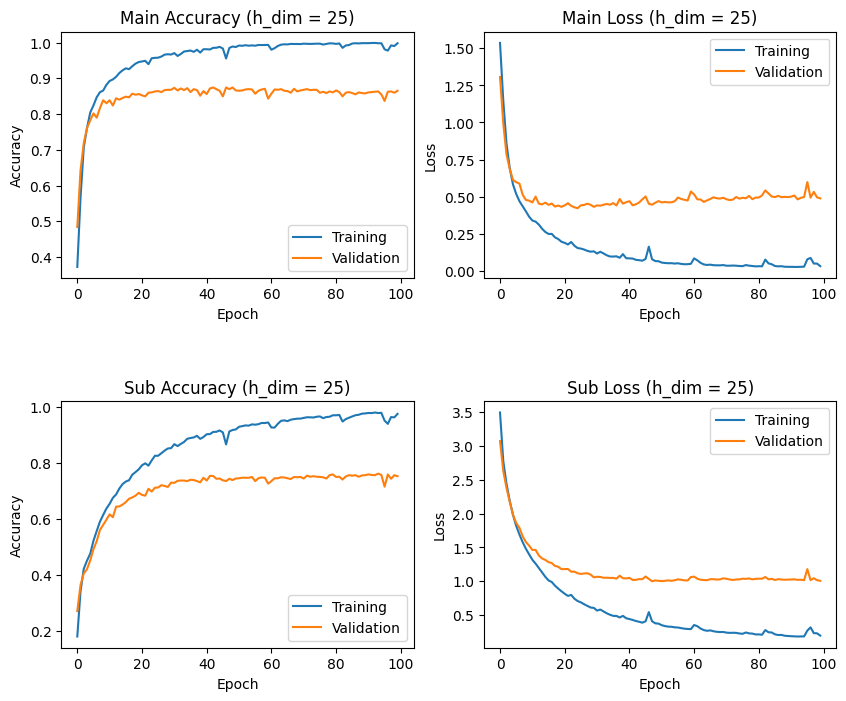

16/16 [==============================] - 0s 2ms/step


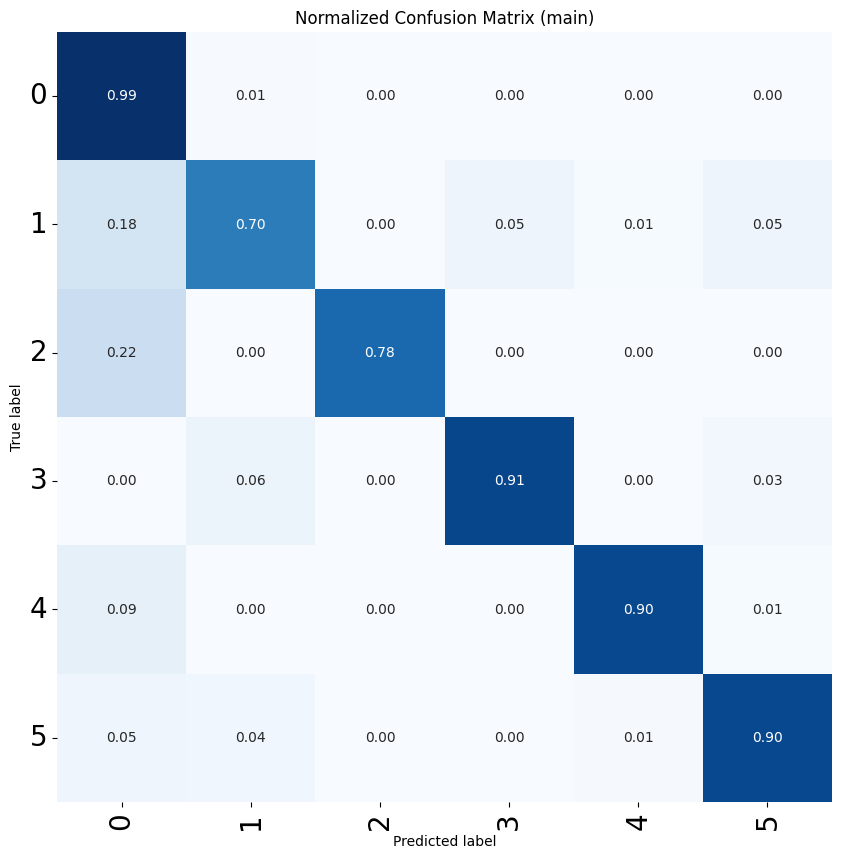

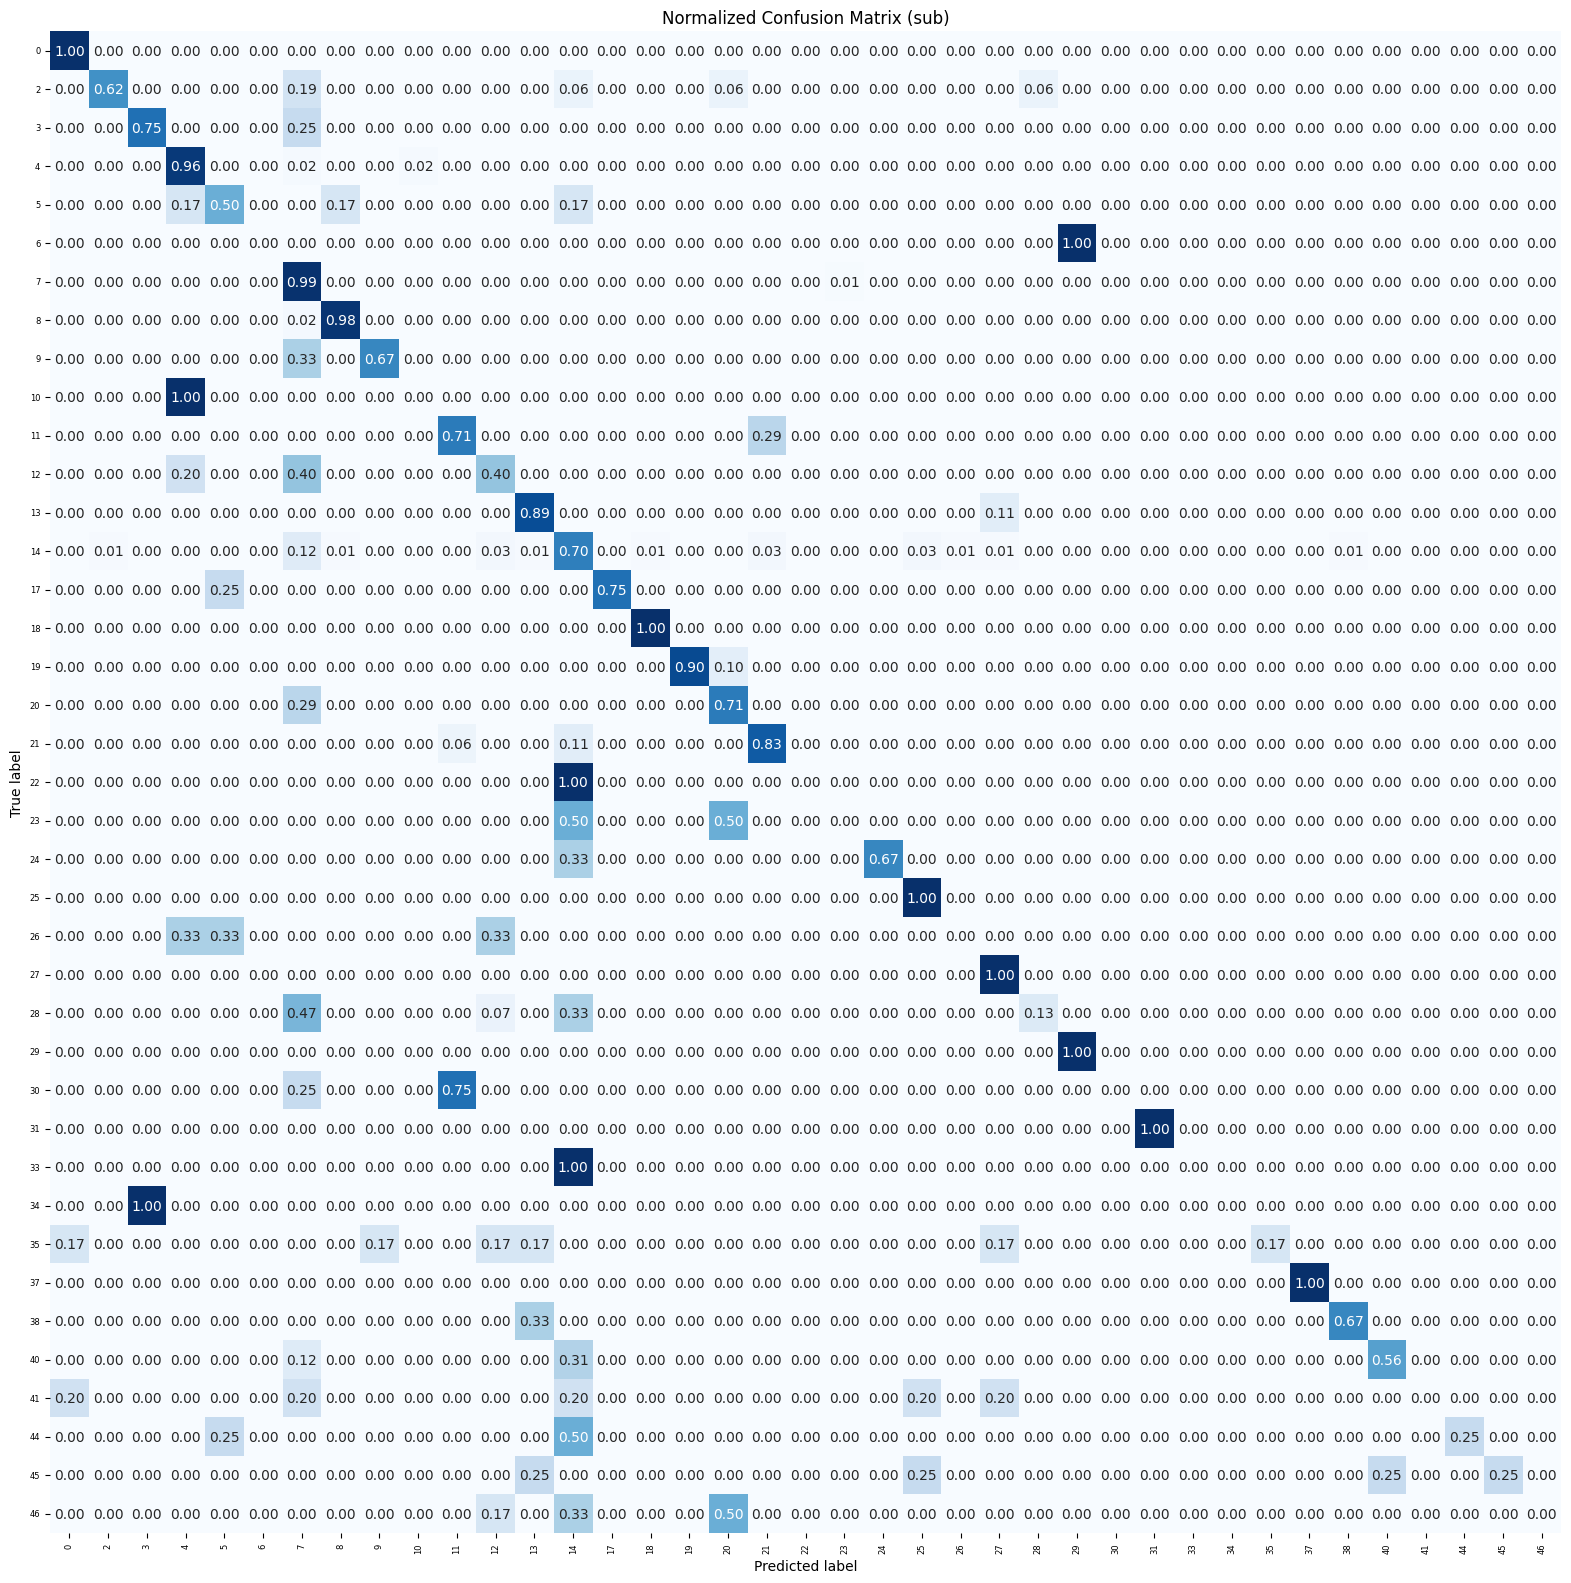

Evaluation metrics (Main):
Accuracy: 0.8880
Precision: 0.9169
Recall: 0.8640
F1-score: 0.8844
Evaluation metrics (Sub):
Accuracy: 0.7620
Precision: 0.5445
Recall: 0.5015
F1-score: 0.4855
Training model with h_dim = 50
Epoch 1/100
69/69 [==============================] - 4s 16ms/step - loss: 4.6871 - main_output_loss: 1.4557 - sub_output_loss: 3.1733 - main_output_accuracy: 0.4173 - sub_output_accuracy: 0.2155 - val_loss: 3.9444 - val_main_output_loss: 1.1543 - val_sub_output_loss: 2.7310 - val_main_output_accuracy: 0.5692 - val_sub_output_accuracy: 0.3538
Epoch 2/100
69/69 [==============================] - 0s 7ms/step - loss: 3.4182 - main_output_loss: 0.9339 - sub_output_loss: 2.4239 - main_output_accuracy: 0.6666 - sub_output_accuracy: 0.4233 - val_loss: 3.0458 - val_main_output_loss: 0.7780 - val_sub_output_loss: 2.2059 - val_main_output_accuracy: 0.7140 - val_sub_output_accuracy: 0.4189
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 2.7114 - main_output_l

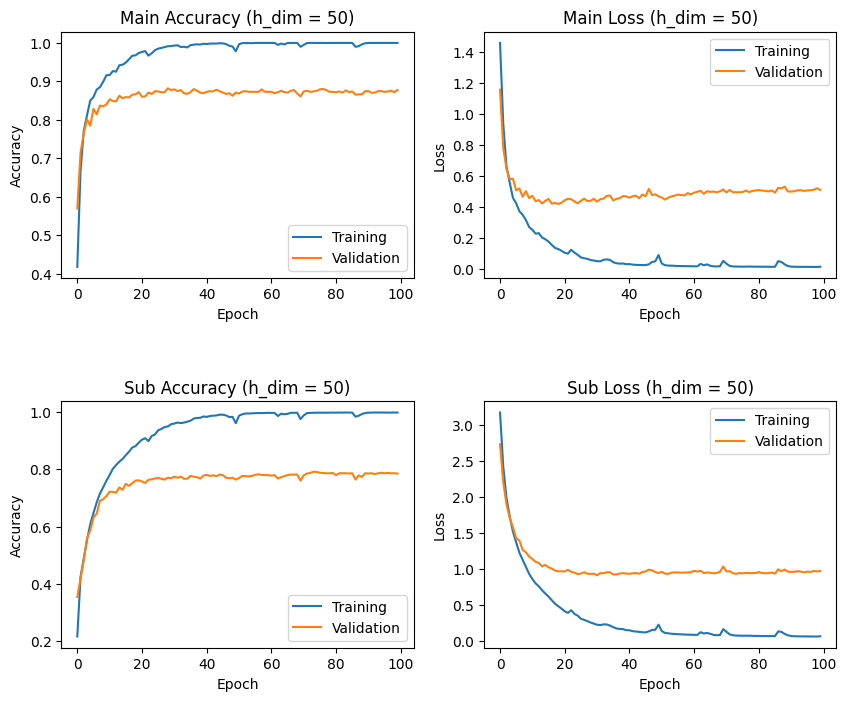

16/16 [==============================] - 0s 3ms/step


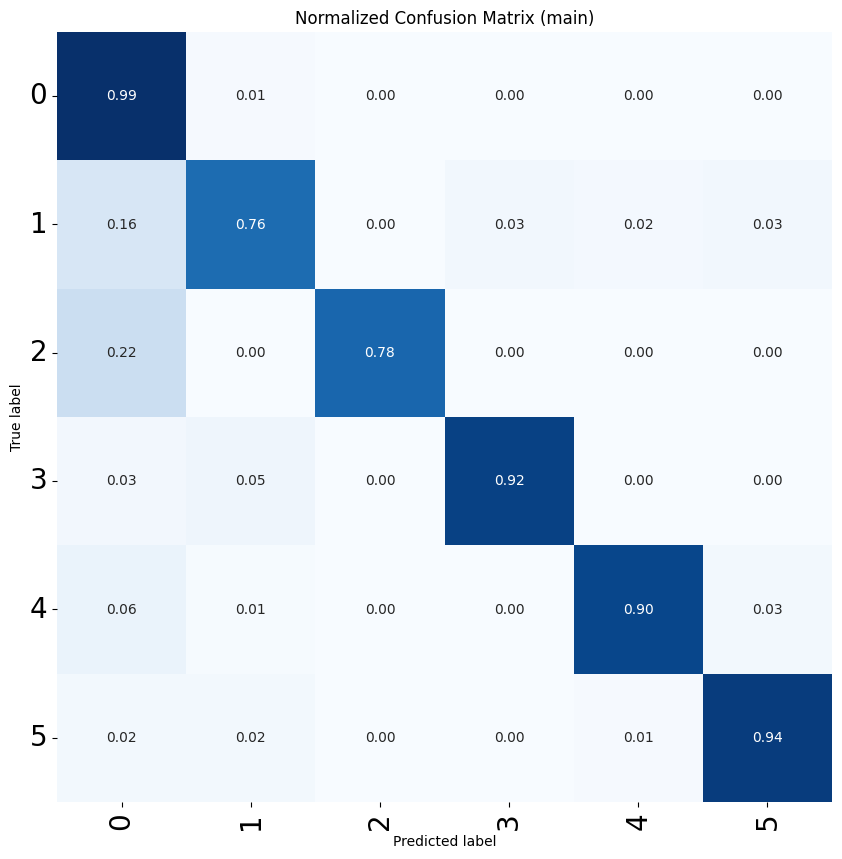

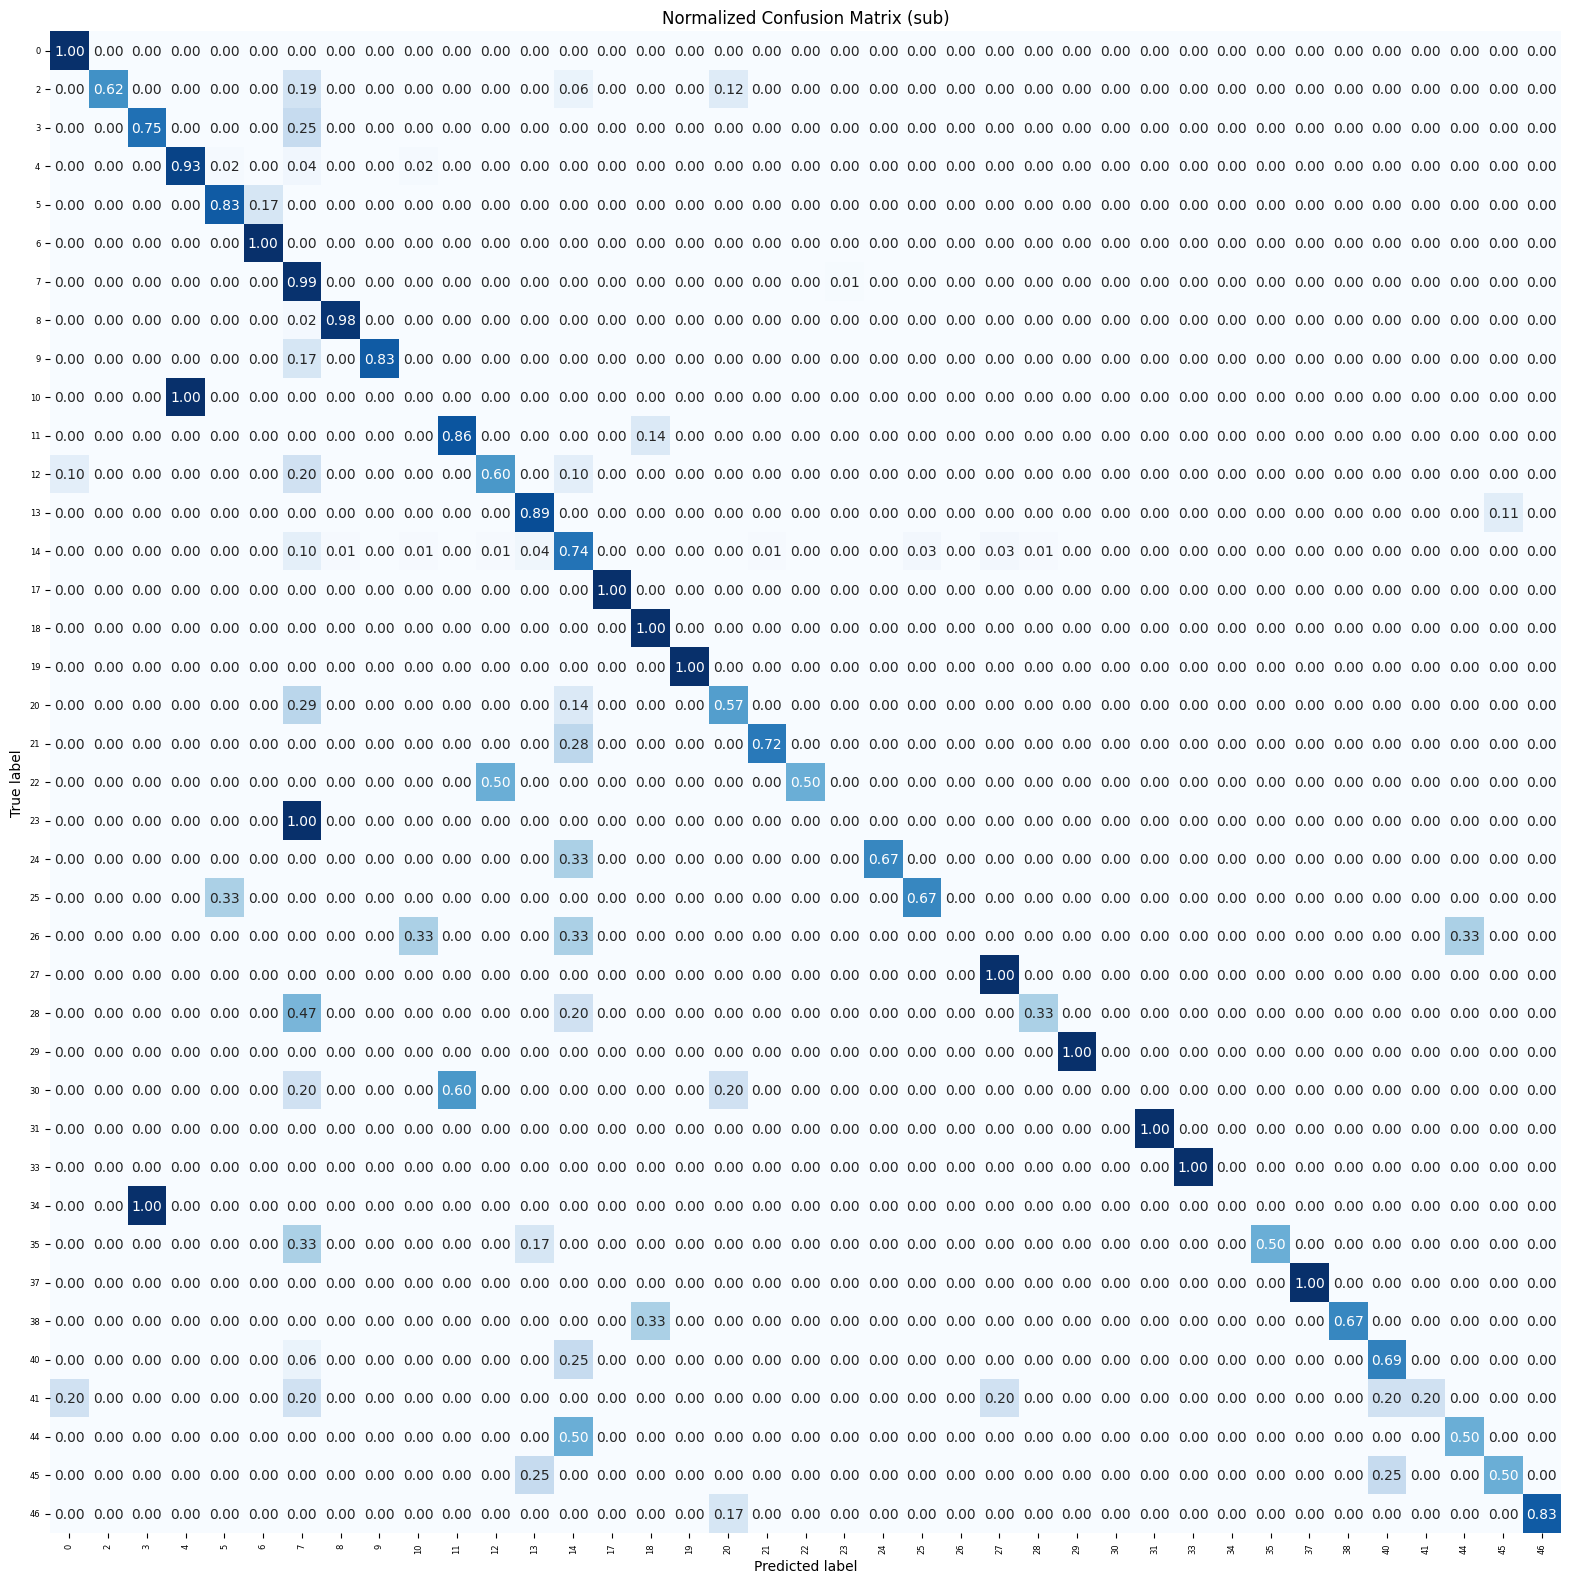

Evaluation metrics (Main):
Accuracy: 0.9040
Precision: 0.9298
Recall: 0.8804
F1-score: 0.9004
Evaluation metrics (Sub):
Accuracy: 0.8100
Precision: 0.7084
Recall: 0.6591
F1-score: 0.6580
Training model with h_dim = 75
Epoch 1/100
69/69 [==============================] - 4s 16ms/step - loss: 4.5351 - main_output_loss: 1.3778 - sub_output_loss: 3.0868 - main_output_accuracy: 0.4625 - sub_output_accuracy: 0.2662 - val_loss: 3.5942 - val_main_output_loss: 1.0310 - val_sub_output_loss: 2.4914 - val_main_output_accuracy: 0.6251 - val_sub_output_accuracy: 0.3721
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 3.0100 - main_output_loss: 0.7942 - sub_output_loss: 2.1426 - main_output_accuracy: 0.7120 - sub_output_accuracy: 0.4632 - val_loss: 2.6823 - val_main_output_loss: 0.6886 - val_sub_output_loss: 1.9188 - val_main_output_accuracy: 0.7599 - val_sub_output_accuracy: 0.4858
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 2.3563 - main_output_l

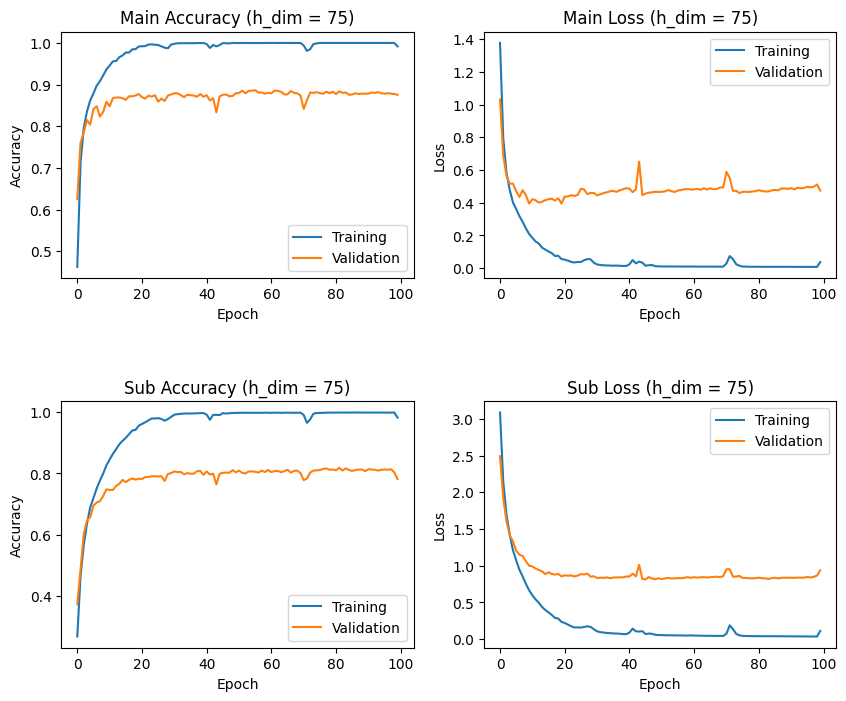

16/16 [==============================] - 0s 3ms/step


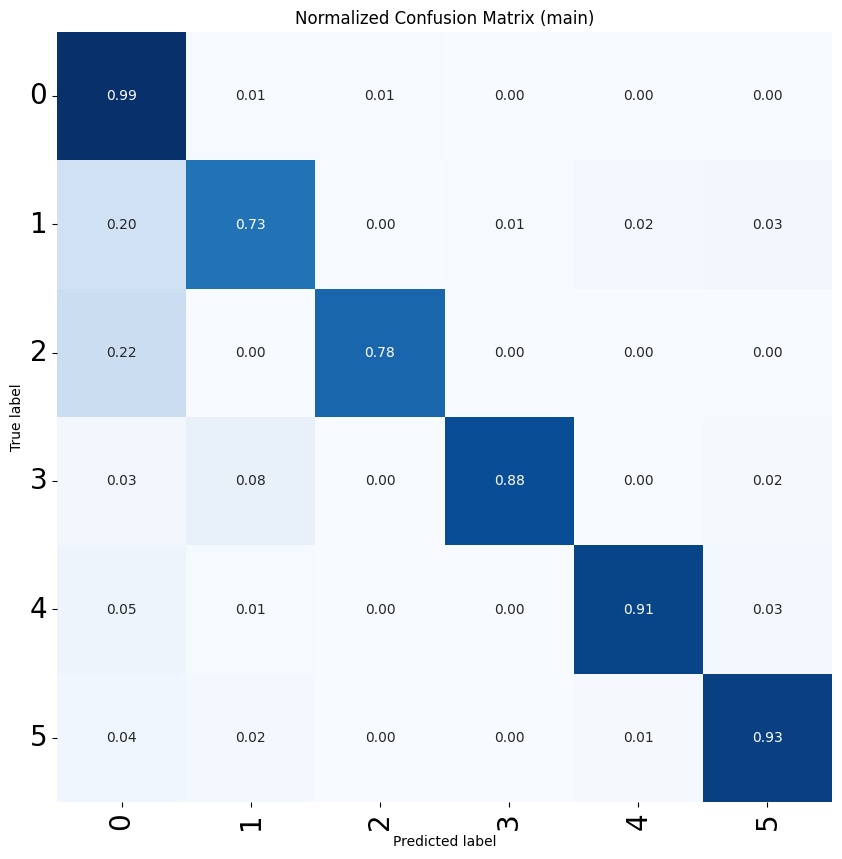

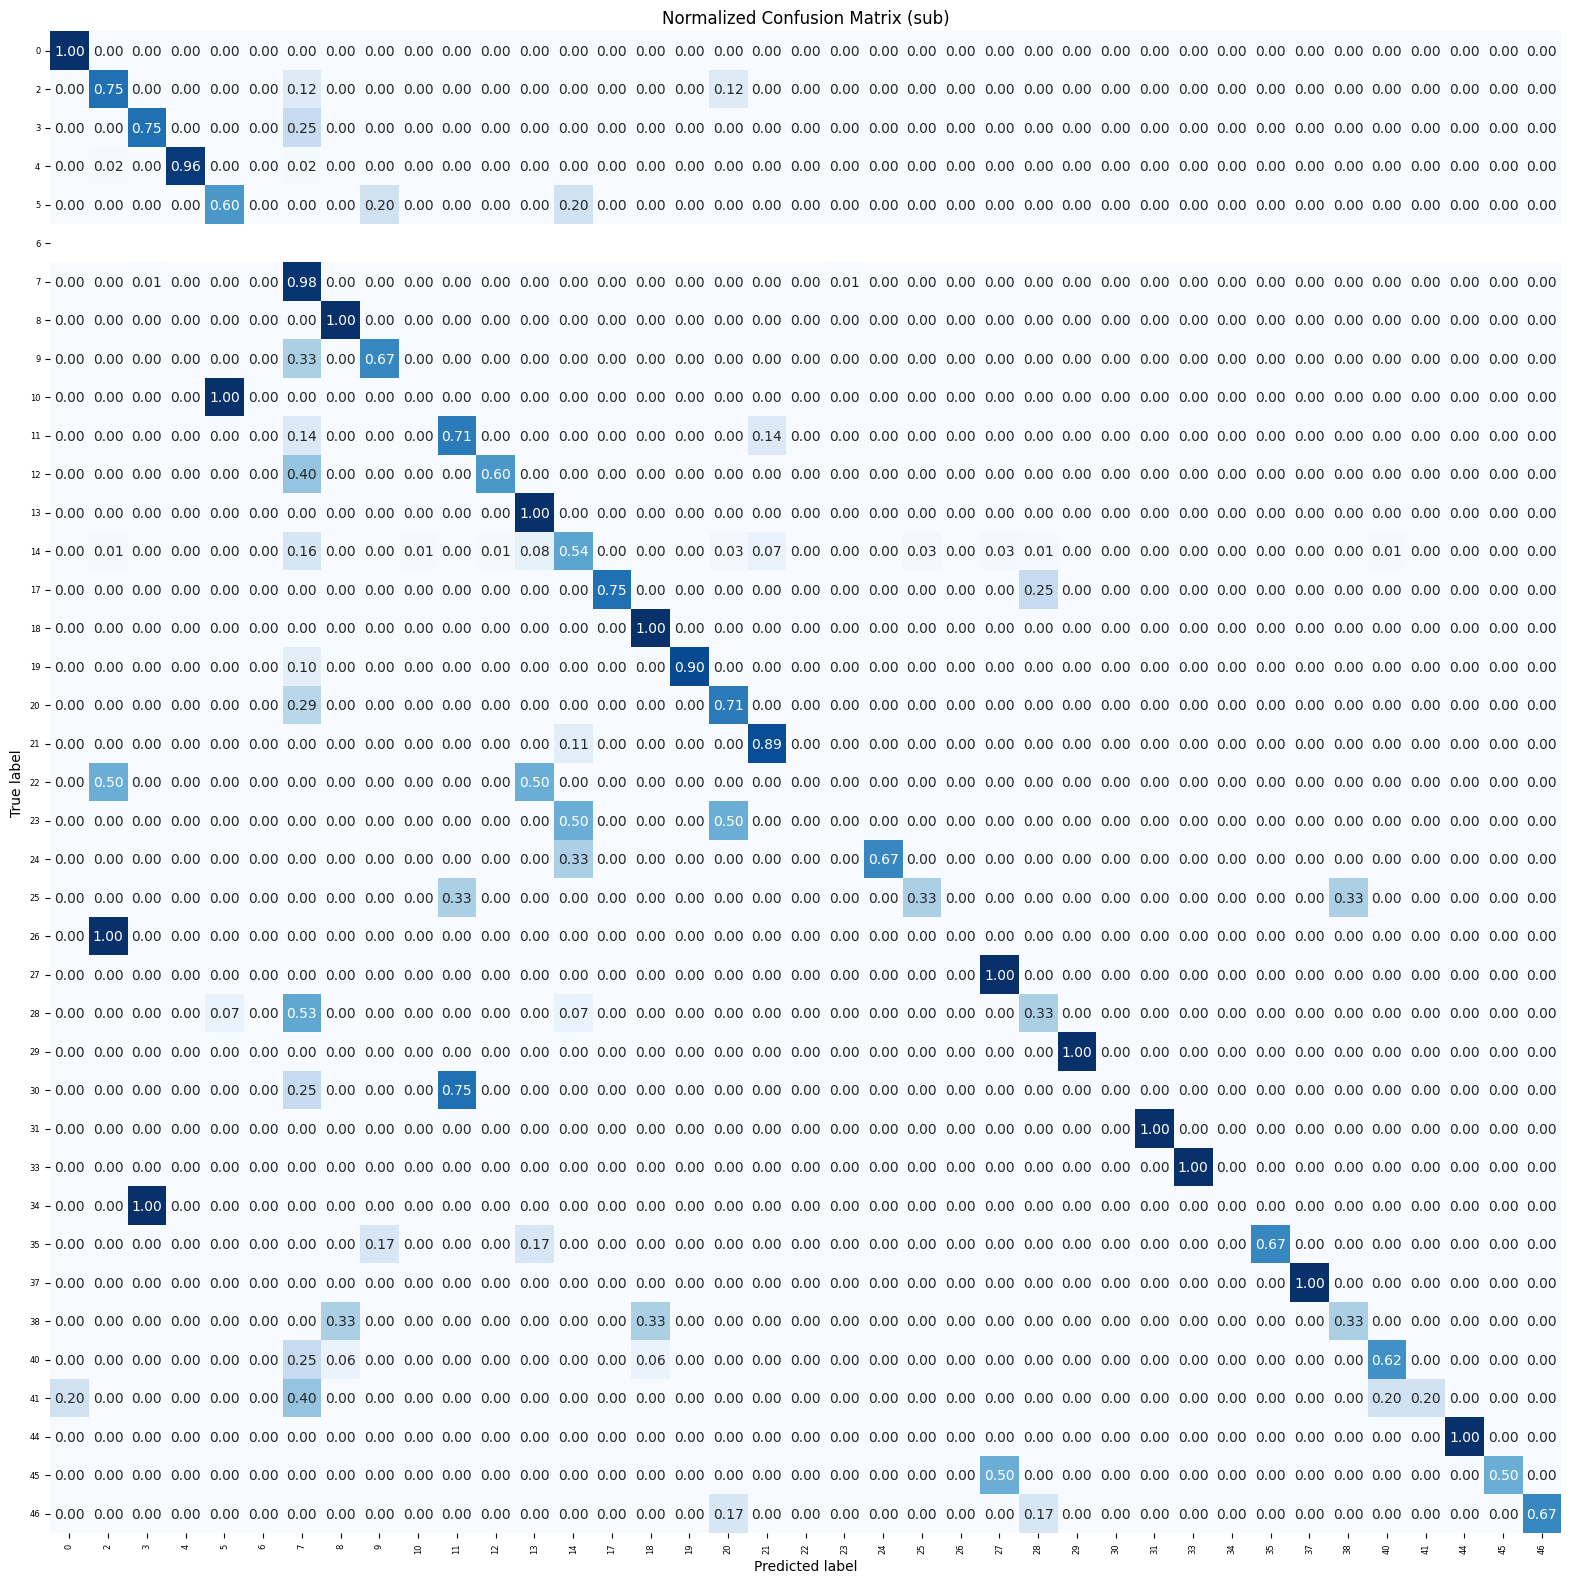

Evaluation metrics (Main):
Accuracy: 0.8940
Precision: 0.9064
Recall: 0.8686
F1-score: 0.8837
Evaluation metrics (Sub):
Accuracy: 0.7800
Precision: 0.6422
Recall: 0.6007
F1-score: 0.5998
Training model with h_dim = 100
Epoch 1/100
69/69 [==============================] - 4s 17ms/step - loss: 4.3405 - main_output_loss: 1.3390 - sub_output_loss: 2.9273 - main_output_accuracy: 0.4731 - sub_output_accuracy: 0.2862 - val_loss: 3.4921 - val_main_output_loss: 1.0583 - val_sub_output_loss: 2.3589 - val_main_output_accuracy: 0.5985 - val_sub_output_accuracy: 0.3868
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 2.8354 - main_output_loss: 0.7786 - sub_output_loss: 1.9806 - main_output_accuracy: 0.7150 - sub_output_accuracy: 0.4921 - val_loss: 2.5167 - val_main_output_loss: 0.6561 - val_sub_output_loss: 1.7827 - val_main_output_accuracy: 0.7736 - val_sub_output_accuracy: 0.5289
Epoch 3/100
69/69 [==============================] - 1s 9ms/step - loss: 2.1739 - main_output_

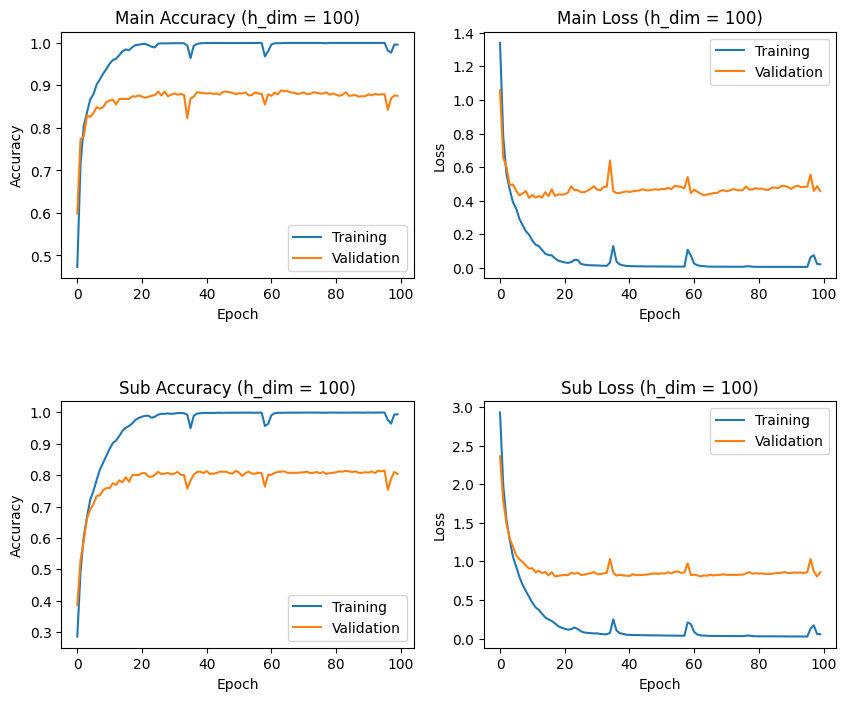

16/16 [==============================] - 0s 3ms/step


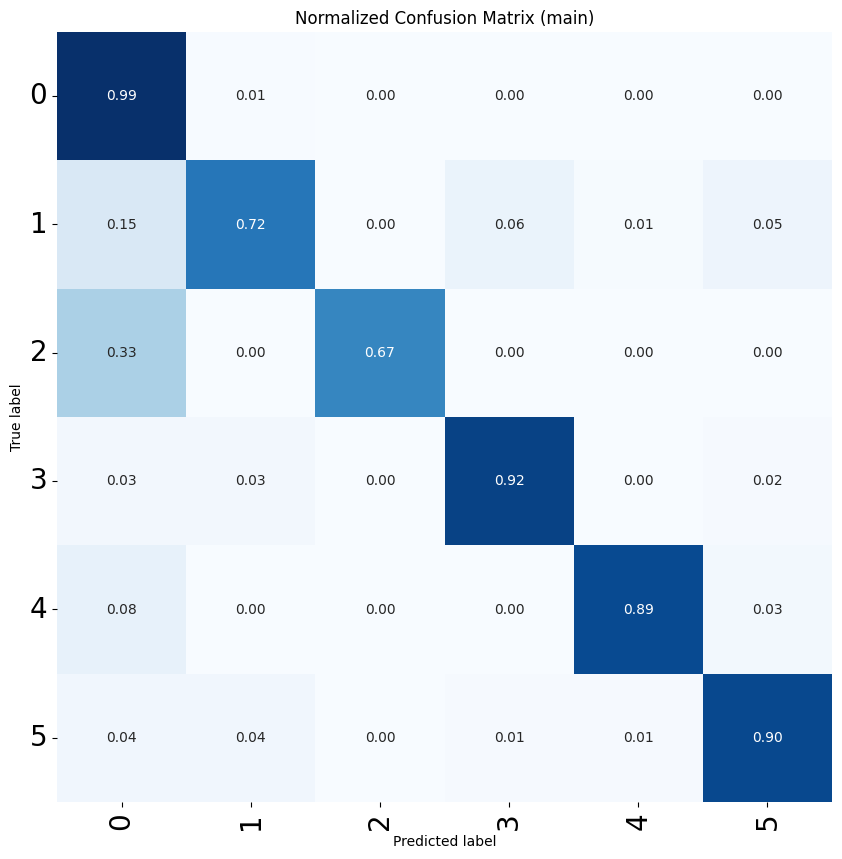

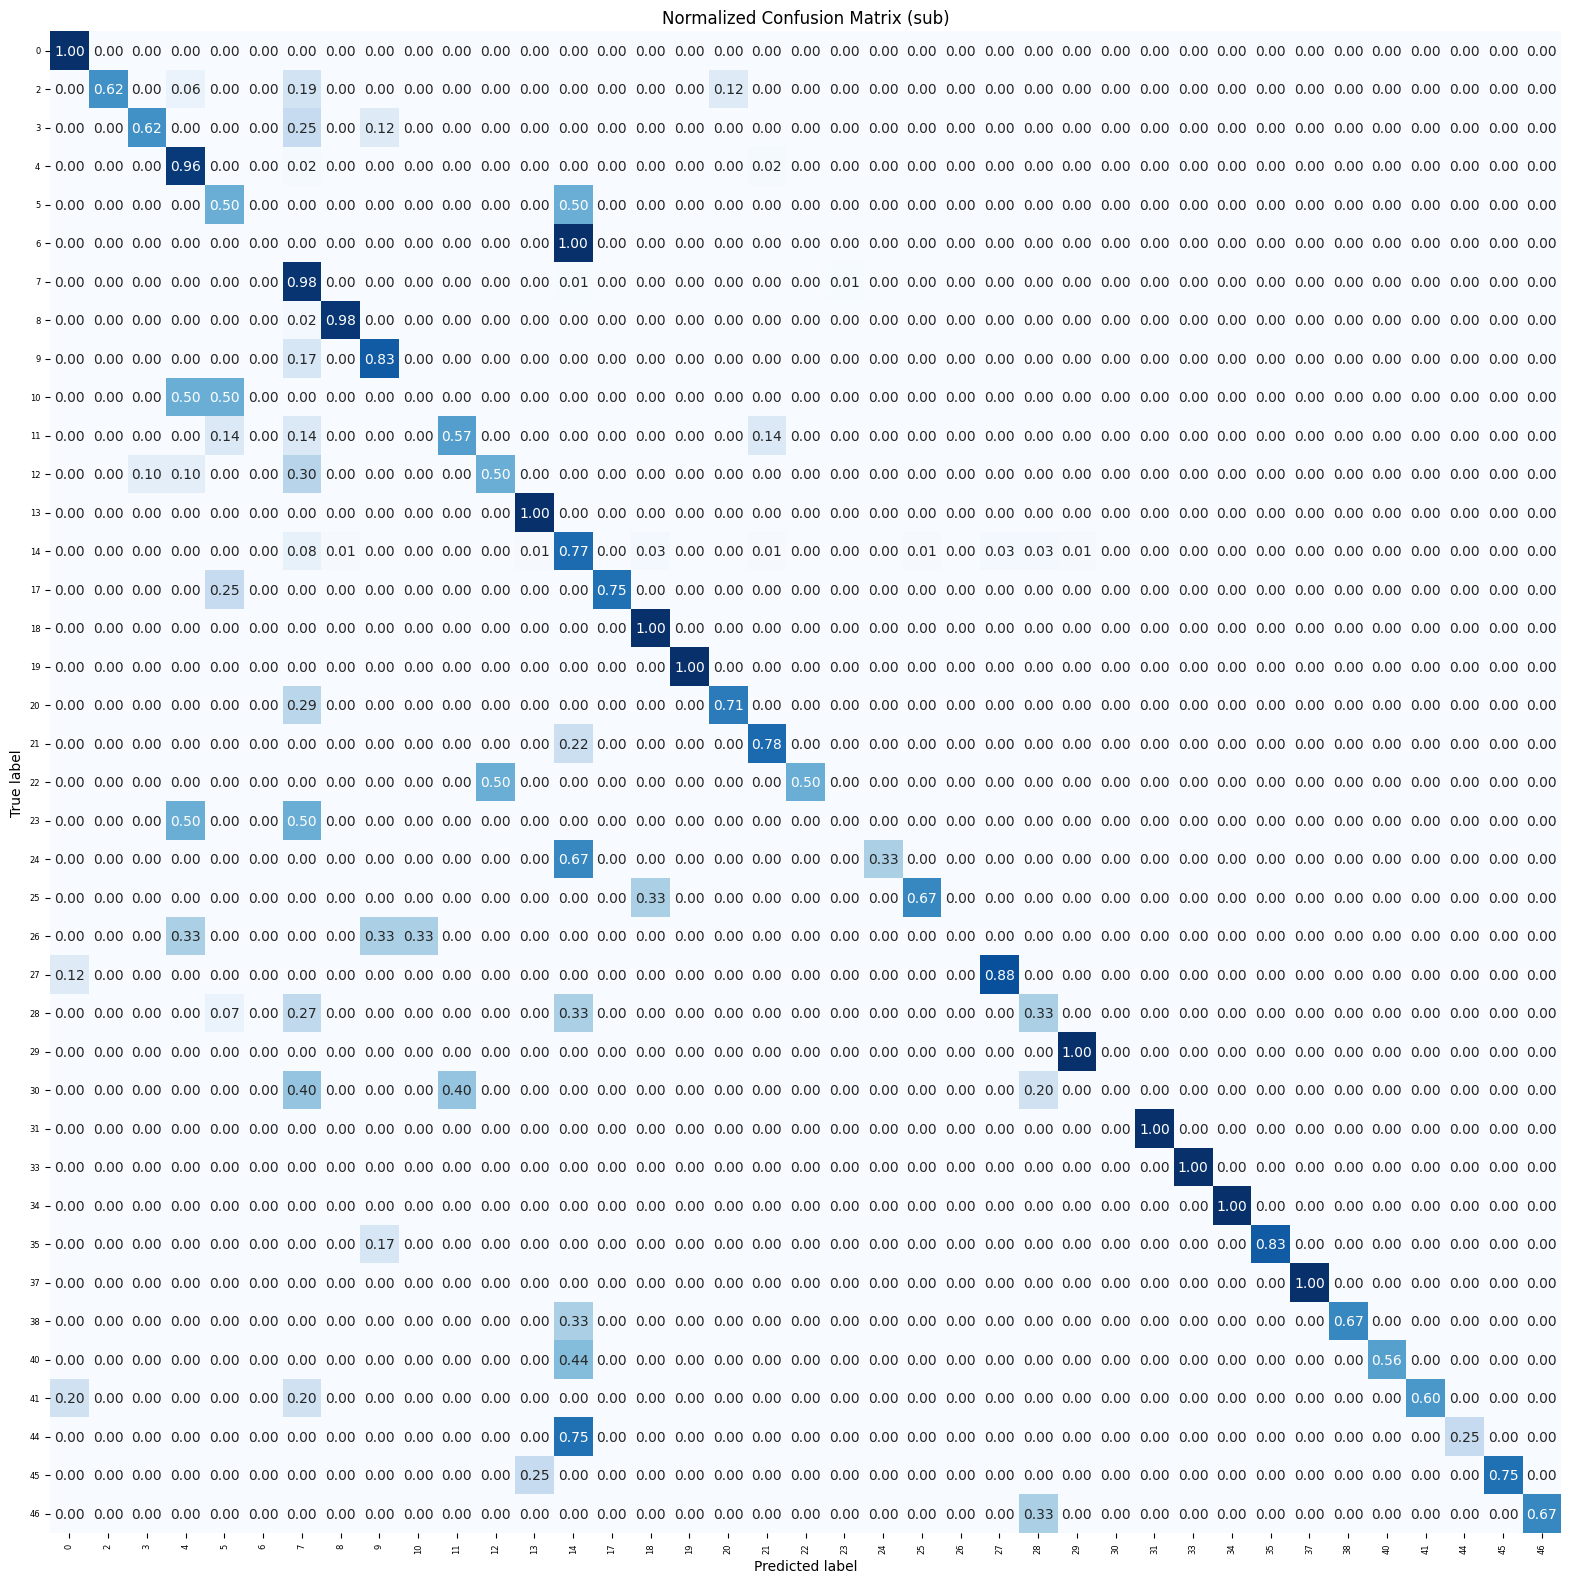

Evaluation metrics (Main):
Accuracy: 0.8900
Precision: 0.9168
Recall: 0.8502
F1-score: 0.8742
Evaluation metrics (Sub):
Accuracy: 0.8080
Precision: 0.7143
Recall: 0.6408
F1-score: 0.6498


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import warnings
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Ignore all warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set hyperparameters
h_dimensions = [25, 50, 75, 100]
epochs = 100
batch_size = 64

# Function to create the LSTM model
from keras import regularizers
def create_lstm_model(input_length, h_dim):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    lstm_layer = LSTM(h_dim, activation='tanh', return_sequences=True, return_state=True)
    lstm_outputs, state_h, state_c = lstm_layer(embedding_layer)
    main_output = Dense(len(encoder_main.classes_), activation='softmax', name='main_output', kernel_regularizer=regularizers.l2(0.001))(state_h)
    sub_output = Dense(len(encoder_sub.classes_), activation='softmax', name='sub_output', kernel_regularizer=regularizers.l2(0.001))(lstm_outputs[:, -1, :])
    model = Model(inputs=input_layer, outputs=[main_output, sub_output])
    model.compile(optimizer=Adam(learning_rate=0.001), loss={'main_output': 'sparse_categorical_crossentropy', 'sub_output': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return model

# Function to save plots to PDF
def save_plots_to_pdf(filename, history, h_dim):
    with PdfPages(filename) as pdf:
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        axs[0, 0].plot(history.history['main_output_accuracy'], label='Training')
        axs[0, 0].plot(history.history['val_main_output_accuracy'], label='Validation')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()
        axs[0, 0].set_title(f'Main Accuracy (h_dim = {h_dim})')

        axs[0, 1].plot(history.history['main_output_loss'], label='Training')
        axs[0, 1].plot(history.history['val_main_output_loss'], label='Validation')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()
        axs[0, 1].set_title(f'Main Loss (h_dim = {h_dim})')

        axs[1, 0].plot(history.history['sub_output_accuracy'], label='Training')
        axs[1, 0].plot(history.history['val_sub_output_accuracy'], label='Validation')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].legend()
        axs[1, 0].set_title(f'Sub Accuracy (h_dim = {h_dim})')

        axs[1, 1].plot(history.history['sub_output_loss'], label='Training')
        axs[1, 1].plot(history.history['val_sub_output_loss'], label='Validation')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].legend()
        axs[1, 1].set_title(f'Sub Loss (h_dim = {h_dim})')

        plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

        pdf.savefig(bbox_inches='tight')

        # Show the plots
        plt.show()

    plt.close()

# Function to save confusion matrix to PDF
def save_confusion_matrix_to_pdf(y_true, y_pred, filename, label_type):
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    # Calculate the appropriate figure size based on the number of classes
    figsize = max(10, num_classes / 2)

    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)

    # Adjust the font size of the numbers inside the heatmap
    annot_fontsize = max(6, 120 // num_classes)
    plt.tick_params(axis='both', labelsize=annot_fontsize)

    # Map the class indices to their corresponding labels
    class_labels = encoder_sub.inverse_transform(unique_classes)

    plt.xticks(np.arange(num_classes) + 0.5, class_labels, rotation='vertical')
    plt.yticks(np.arange(num_classes) + 0.5, class_labels, rotation='horizontal')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Normalized Confusion Matrix ({label_type})')
    plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()

# Function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, label_type):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Evaluation metrics ({label_type}):')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert tokens to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences
maxlen = max(len(seq) for seq in train_sequences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=maxlen)
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Encode main labels
encoder_main = LabelEncoder()
encoder_main.fit(train_data['label-coarse'])
train_encoded_main_labels = encoder_main.transform(train_data['label-coarse'])
test_encoded_main_labels = encoder_main.transform(test_data['label-coarse'])

# Encode sub labels
encoder_sub = LabelEncoder()
encoder_sub.fit(train_data['label-fine'])
train_encoded_sub_labels = encoder_sub.transform(train_data['label-fine'])
test_encoded_sub_labels = encoder_sub.transform(test_data['label-fine'])

# Convert main labels to one-hot vectors
y_main_train = to_categorical(train_encoded_main_labels)
y_main_test = to_categorical(test_encoded_main_labels)

# Convert sub labels to one-hot vectors
y_sub_train = to_categorical(train_encoded_sub_labels)
y_sub_test = to_categorical(test_encoded_sub_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split train data into train and validation sets
train_padded_sequences, val_padded_sequences, train_encoded_main_labels, val_encoded_main_labels, train_encoded_sub_labels, val_encoded_sub_labels = train_test_split(
    train_padded_sequences,
    train_encoded_main_labels,
    train_encoded_sub_labels,
    test_size=0.2,
    random_state=42
)

# Iterate over h_dimensions and train the models
for h_dim in h_dimensions:
    print(f"Training model with h_dim = {h_dim}")
    model = create_lstm_model(maxlen, h_dim)

    # Fit the model
    history = model.fit(
        train_padded_sequences,
        {'main_output': train_encoded_main_labels, 'sub_output': train_encoded_sub_labels},
        validation_data=(val_padded_sequences, {'main_output': val_encoded_main_labels, 'sub_output': val_encoded_sub_labels}),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save plots and confusion matrices
    timestamp = str(int(time.time()))
    save_plots_to_pdf(f'plots_{h_dim}_{timestamp}.pdf', history, h_dim)

    # Only plot confusion matrices for the test data
    main_output_predictions, sub_output_predictions = model.predict(test_padded_sequences)
    main_output_predictions = np.argmax(main_output_predictions, axis=1)
    sub_output_predictions = np.argmax(sub_output_predictions, axis=1)

    save_confusion_matrix_to_pdf(
        test_encoded_main_labels,
        main_output_predictions,
        f'confusion_matrix_test_main_{h_dim}_{timestamp}.pdf',
        'main'
    )
    save_confusion_matrix_to_pdf(
        test_encoded_sub_labels,
        sub_output_predictions,
        f'confusion_matrix_test_sub_{h_dim}_{timestamp}.pdf',
        'sub'
    )

    print_evaluation_metrics(test_encoded_main_labels, main_output_predictions, 'Main')
    print_evaluation_metrics(test_encoded_sub_labels, sub_output_predictions, 'Sub')


# **4. Prototype Responder**

In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

# Load the QA_data
qa_data = pd.read_csv('QA_data.csv', encoding='latin1')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(qa_data['text'])
sequences = tokenizer.texts_to_sequences(qa_data['text'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_sequence_length)

# One-hot encode the answers
answers = qa_data['answer']
answer_labels = np.unique(answers)
label_to_index = {label: index for index, label in enumerate(answer_labels)}
answers_encoded = np.array([label_to_index[answer] for answer in answers])

num_classes = len(answer_labels)

# Define the Responder model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = LSTM(100, return_sequences=True)(embedding_layer)
lstm_last_hidden_state = lstm_layer[:, -1, :]
lstm_last_cell_state = lstm_layer[:, -1, :]
bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(lstm_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
# bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(embedding_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, answers_encoded, epochs=100, batch_size=8)

# Test the model on Table 3 questions
test_questions = [
    'How many people speak French?',
    'What day is today?',
    'Who will win the war?',
    'Who is Italian first minister?',
    'When World War II ended?',
    'When Gandhi was assassinated?'
]

# Normalize test questions
test_questions = [normalize_text(question) for question in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_X = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_X)
predicted_labels = [answer_labels[np.argmax(pred)] for pred in predictions]

# Print the predicted answers
for question, answer in zip(test_questions, predicted_labels):
    print(f'Question: {question}')
    print(f'Predicted Answer: {answer}\n')


Epoch 1/100
63/63 [==============================] - 20s 12ms/step - loss: 6.1963 - accuracy: 0.0000e+00
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 6.1649 - accuracy: 0.0040
Epoch 3/100
63/63 [==============================] - 1s 10ms/step - loss: 6.0444 - accuracy: 0.0060
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 5.7150 - accuracy: 0.0240
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 5.2290 - accuracy: 0.0260
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 4.5735 - accuracy: 0.1160
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: 3.8916 - accuracy: 0.2300
Epoch 8/100
63/63 [==============================] - 1s 12ms/step - loss: 3.2277 - accuracy: 0.4160
Epoch 9/100
63/63 [==============================] - 1s 12ms/step - loss: 2.6015 - accuracy: 0.5760
Epoch 10/100
63/63 [==============================] - 1s 12ms/step - loss: 2.0551 - accuracy: 0

Epoch 1/100
63/63 [==============================] - 9s 11ms/step - loss: 6.1849 - accuracy: 0.0000e+00
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 6.1699 - accuracy: 0.0060
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 6.0564 - accuracy: 0.0080
Epoch 4/100
63/63 [==============================] - 1s 10ms/step - loss: 5.7506 - accuracy: 0.0240
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: 5.2427 - accuracy: 0.0520
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 4.5737 - accuracy: 0.1160
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: 3.8701 - accuracy: 0.2780
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: 3.2464 - accuracy: 0.3720
Epoch 9/100
63/63 [==============================] - 1s 11ms/step - loss: 2.6036 - accuracy: 0.5360
Epoch 10/100
63/63 [==============================] - 1s 10ms/step - loss: 2.0692 - accuracy: 0.

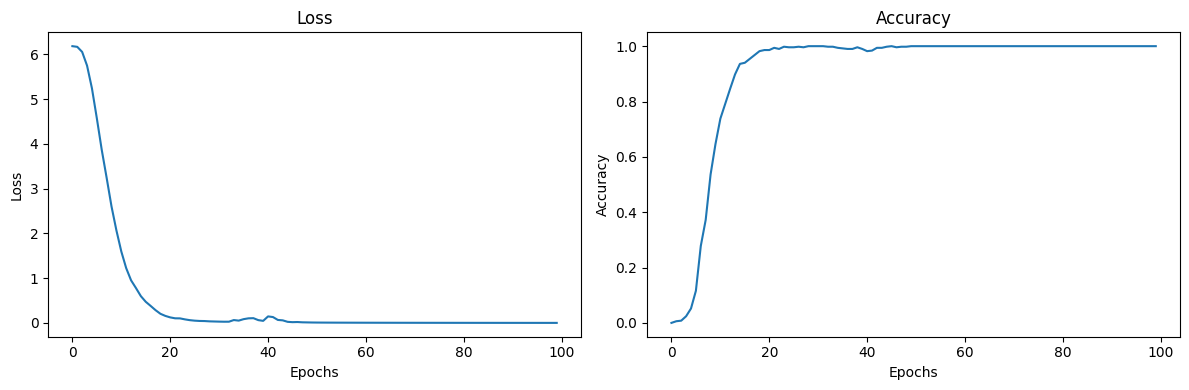

1/1 [==============================] - 1s 908ms/step
Question: how many people speak french?
Predicted Answer: 5,280

Question: what day is today?
Predicted Answer: deliberate killing of a people

Question: who will win the war?
Predicted Answer: Paris

Question: who is italian first minister?
Predicted Answer: 16th US president

Question: when world war ii ended?
Predicted Answer: June 21st

Question: when gandhi was assassinated?
Predicted Answer: 1743



In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense

# Load the QA_data
qa_data = pd.read_csv('QA_data.csv', encoding='latin1')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(qa_data['text'])
sequences = tokenizer.texts_to_sequences(qa_data['text'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_sequence_length)

# One-hot encode the answers
answers = qa_data['answer']
answer_labels = np.unique(answers)
label_to_index = {label: index for index, label in enumerate(answer_labels)}
answers_encoded = np.array([label_to_index[answer] for answer in answers])

num_classes = len(answer_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the Responder model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = LSTM(100, return_sequences=True)(embedding_layer)
lstm_last_hidden_state = lstm_layer[:, -1, :]
lstm_last_cell_state = lstm_layer[:, -1, :]
bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(lstm_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, answers_encoded, epochs=100, batch_size=8)

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('lossaccuracyplot.pdf')
plt.show()

# Test the model on Table 3 questions
test_questions = [
    'How many people speak French?',
    'What day is today?',
    'Who will win the war?',
    'Who is Italian first minister?',
    'When World War II ended?',
    'When Gandhi was assassinated?'
]

# Normalize test questions
test_questions = [normalize_text(question) for question in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_X = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_X)
predicted_labels = [answer_labels[np.argmax(pred)] for pred in predictions]

# Save predictions as pandas DataFrame
results = pd.DataFrame({'Question': test_questions, 'Predicted Answer': predicted_labels})
results.to_csv('predictions.csv', index=False)

# Print the predicted answers
for question, answer in zip(test_questions, predicted_labels):
    print(f'Question: {question}')
    print(f'Predicted Answer: {answer}\n')


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense

# Load the QA_data
qa_data = pd.read_csv('QA_data.csv', encoding='latin1')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(qa_data['text'])
sequences = tokenizer.texts_to_sequences(qa_data['text'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_sequence_length)

# One-hot encode the answers
answers = qa_data['answer']
answer_labels = np.unique(answers)
label_to_index = {label: index for index, label in enumerate(answer_labels)}
answers_encoded = np.array([label_to_index[answer] for answer in answers])

num_classes = len(answer_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the Responder model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = LSTM(100, return_sequences=True)(embedding_layer)
lstm_last_hidden_state = lstm_layer[:, -1, :]
lstm_last_cell_state = lstm_layer[:, -1, :]
bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(lstm_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
# bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(embedding_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
# model.add(LSTM(100, return_sequences=True))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100)))
# model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, answers_encoded, epochs=100, batch_size=8)

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('lossaccuracyplot2.pdf')
plt.show()

# Test the model on Table 3 questions
test_questions = [
    'How many people speak French?',
    'What day is today?',
    'Who will win the war?',
    'Who is Italian first minister?',
    'When World War II ended?',
    'When Gandhi was assassinated?'
]

# Normalize test questions
test_questions = [normalize_text(question) for question in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_X = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_X)
predicted_labels = [answer_labels[np.argmax(pred)] for pred in predictions]

# Save predictions as pandas DataFrame
results = pd.DataFrame({'Question': test_questions, 'Predicted Answer': predicted_labels})
results.to_csv('predictions.csv', index=False)

# Print the predicted answers
for question, answer in zip(test_questions, predicted_labels):
    print(f'Question: {question}')
    print(f'Predicted Answer: {answer}\n')


In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

# Load the QA_data
qa_data = pd.read_csv('QA_data.csv', encoding='latin1')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(qa_data['text'])
sequences = tokenizer.texts_to_sequences(qa_data['text'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_sequence_length)

# One-hot encode the answers
answers = qa_data['answer']
answer_labels = np.unique(answers)
label_to_index = {label: index for index, label in enumerate(answer_labels)}
answers_encoded = np.array([label_to_index[answer] for answer in answers])

num_classes = len(answer_labels)

# Define the Responder model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(100, return_sequences=True))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, answers_encoded, epochs=100, batch_size=8)

# Test the model on Table 3 questions
test_questions = [
    'How many people speak French?',
    'What day is today?',
    'Who will win the war?',
    'Who is Italian first minister?',
    'When World War II ended?',
    'When Gandhi was assassinated?'
]

# Normalize test questions
test_questions = [normalize_text(question) for question in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_X = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_X)
predicted_labels = [answer_labels[np.argmax(pred)] for pred in predictions]

# Print the predicted answers
for question, answer in zip(test_questions, predicted_labels):
    print(f'Question: {question}')
    print(f'Predicted Answer: {answer}\n')


Epoch 1/100
63/63 [==============================] - 27s 85ms/step - loss: 6.1738 - accuracy: 0.0000e+00
Epoch 2/100
63/63 [==============================] - 2s 33ms/step - loss: 6.1908 - accuracy: 0.0020
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: 6.1799 - accuracy: 0.0040
Epoch 4/100
63/63 [==============================] - 1s 12ms/step - loss: 6.1417 - accuracy: 0.0000e+00
Epoch 5/100
63/63 [==============================] - 1s 20ms/step - loss: 6.0266 - accuracy: 0.0060
Epoch 6/100
63/63 [==============================] - 1s 23ms/step - loss: 5.8370 - accuracy: 0.0040
Epoch 7/100
63/63 [==============================] - 1s 12ms/step - loss: 5.5686 - accuracy: 0.0100
Epoch 8/100
63/63 [==============================] - 1s 15ms/step - loss: 5.2756 - accuracy: 0.0080
Epoch 9/100
63/63 [==============================] - 1s 12ms/step - loss: 4.9464 - accuracy: 0.0180
Epoch 10/100
63/63 [==============================] - 1s 16ms/step - loss: 4.6138 - accurac

Epoch 1/150
63/63 [==============================] - 6s 8ms/step - loss: 6.1846 - accuracy: 0.0000e+00
Epoch 2/150
63/63 [==============================] - 0s 7ms/step - loss: 6.1620 - accuracy: 0.0020
Epoch 3/150
63/63 [==============================] - 0s 8ms/step - loss: 6.0464 - accuracy: 0.0180
Epoch 4/150
63/63 [==============================] - 0s 8ms/step - loss: 5.6941 - accuracy: 0.0380
Epoch 5/150
63/63 [==============================] - 0s 8ms/step - loss: 5.1095 - accuracy: 0.0520
Epoch 6/150
63/63 [==============================] - 0s 7ms/step - loss: 4.4274 - accuracy: 0.1200
Epoch 7/150
63/63 [==============================] - 0s 8ms/step - loss: 3.7005 - accuracy: 0.2520
Epoch 8/150
63/63 [==============================] - 0s 8ms/step - loss: 3.0273 - accuracy: 0.4360
Epoch 9/150
63/63 [==============================] - 0s 8ms/step - loss: 2.4458 - accuracy: 0.5840
Epoch 10/150
63/63 [==============================] - 1s 11ms/step - loss: 1.8923 - accuracy: 0.7000
Epoc

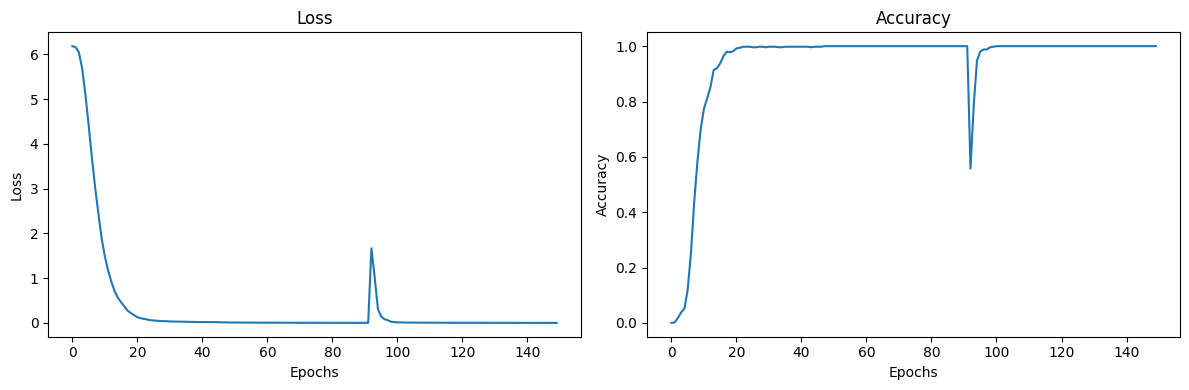

1/1 [==============================] - 1s 1s/step
Question: how many people speak french?
Predicted Answer: drought-resistant plants

Question: what day is today?
Predicted Answer: tennis tournament

Question: who will win the war?
Predicted Answer: Richard James

Question: who is italian first minister?
Predicted Answer: Immanuel Kant

Question: when world war ii ended?
Predicted Answer: 1939

Question: when gandhi was assassinated?
Predicted Answer: 1830



In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense

# Load the QA_data
qa_data = pd.read_csv('QA_data.csv', encoding='latin1')

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(qa_data['text'])
sequences = tokenizer.texts_to_sequences(qa_data['text'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)

X = pad_sequences(sequences, maxlen=max_sequence_length)

# One-hot encode the answers
answers = qa_data['answer']
answer_labels = np.unique(answers)
label_to_index = {label: index for index, label in enumerate(answer_labels)}
answers_encoded = np.array([label_to_index[answer] for answer in answers])

num_classes = len(answer_labels)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the Responder model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = LSTM(100, return_sequences=True)(embedding_layer)
lstm_last_hidden_state = lstm_layer[:, -1, :]
lstm_last_cell_state = lstm_layer[:, -1, :]
bilstm_layer = Bidirectional(LSTM(100, return_sequences=False), merge_mode='concat')(lstm_layer, initial_state=[lstm_last_hidden_state, lstm_last_cell_state, lstm_last_hidden_state, lstm_last_cell_state])
output_layer = Dense(num_classes, activation='softmax')(bilstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, answers_encoded, epochs=150, batch_size=8)

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('lossaccuracyplot4.pdf')
plt.show()

# Test the model on Table 3 questions
test_questions = [
    'How many people speak French?',
    'What day is today?',
    'Who will win the war?',
    'Who is Italian first minister?',
    'When World War II ended?',
    'When Gandhi was assassinated?'
]

# Normalize test questions
test_questions = [normalize_text(question) for question in test_questions]

test_sequences = tokenizer.texts_to_sequences(test_questions)
test_X = pad_sequences(test_sequences, maxlen=max_sequence_length)

predictions = model.predict(test_X)
predicted_labels = [answer_labels[np.argmax(pred)] for pred in predictions]

# Save predictions as pandas DataFrame
results = pd.DataFrame({'Question': test_questions, 'Predicted Answer': predicted_labels})
results.to_csv('predictions4.csv', index=False)

# Print the predicted answers
for question, answer in zip(test_questions, predicted_labels):
    print(f'Question: {question}')
    print(f'Predicted Answer: {answer}\n')


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Read 'QA_data.csv' with 'errors' parameter and pass the file object to 'pd.read_csv()'
with open('QA_data.csv', 'r', encoding='utf-8', errors='replace') as file:
    qa_data = pd.read_csv(file)

# Define function for text normalization
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z0-9\?]+', ' ', text)
    text = text.lower()
    return text

# Normalize text
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)
qa_data['text'] = qa_data['text'].apply(normalize_text)

# Tokenize the text
train_data['tokens'] = train_data['text'].apply(word_tokenize)
test_data['tokens'] = test_data['text'].apply(word_tokenize)
qa_data['tokens'] = qa_data['text'].apply(word_tokenize)

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tokens'])

# Convert tokens to sequences
train_data['sequences'] = tokenizer.texts_to_sequences(train_data['tokens'])
test_data['sequences'] = tokenizer.texts_to_sequences(test_data['tokens'])
qa_data['sequences'] = tokenizer.texts_to_sequences(qa_data['tokens'])

# Pad sequences
maxlen = max(train_data['sequences'].apply(len))
train_padded_sequences = pad_sequences(train_data['sequences'], maxlen=maxlen)
test_padded_sequences = pad_sequences(test_data['sequences'], maxlen=maxlen)
qa_padded_sequences = pad_sequences(qa_data['sequences'], maxlen=maxlen)

# Encode labels
encoder = LabelEncoder()
encoder.fit(train_data['label-coarse'])
train_data['encoded_labels'] = encoder.transform(train_data['label-coarse'])
test_data['encoded_labels'] = encoder.transform(test_data['label-coarse'])
qa_data['encoded_labels'] = encoder.transform(qa_data['label-coarse'])

# Create an embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
